In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

decode_dir = 'C:\\Users\\Ping\\Desktop\\Analysis_practice'
animalID = ['M7E', 'M117B']

callhist_all = np.array([]).reshape(20,10,68,0)
callhist_type_all = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode_10ms.mat')
    print(path)
    mat_dict = io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all = np.append(callhist_all,mat_dict['callhist'],-1)
    callhist_type_all = np.append(callhist_type_all, mat_dict['callhist_type'])


C:\Users\Ping\Desktop\Analysis_practice\M7E_batch\decode_10ms.mat
C:\Users\Ping\Desktop\Analysis_practice\M117B_batch\decode_10ms.mat


In [3]:
callhist_all.shape

(20, 10, 68, 337)

In [4]:
callhist_type_all.shape

(337,)

In [2]:
# Loop for nsims - initially set to 1
def sim_decode(callhist, nsims=1,nunits=1,LDA=True):

    # Shuffle - select a random trial for each
    # Leave out and train the rest
    # Callhist dimensions are (stim, rep, time bin, unit)
    
    # Optionally don't calculate LDA to minimize computation time
   
    conf = np.empty((callhist.shape[0],callhist.shape[0]))
    conf.fill(0)    # Test actual (row), test predicted (column)

    conf2 = np.empty((callhist.shape[0],callhist.shape[0]))
    conf2.fill(0)    # Test actual (row), test predicted (column)

    for sim in range(nsims):
        rand_units = random.sample(range(callhist.shape[3]), nunits)  # without replacement
        rand_rep = random.choices(range(callhist.shape[1]), k=nunits)  # with replacement

        leftout =  np.empty((callhist.shape[0],1,callhist.shape[2],nunits))
        leftout.fill(np.nan)
        leftin = np.empty((callhist.shape[0],callhist.shape[1]-1,callhist.shape[2],nunits))
        leftin.fill(np.nan)
        leftout_y = np.empty((callhist.shape[0],nunits))
        leftout_y.fill(np.nan)

        for unit in range(nunits):
            leftout[:,:,:,unit] = np.expand_dims(callhist[:,rand_rep[unit],:,rand_units[unit]],1)
            leftin[:,:,:,unit] = np.delete(callhist[:,:,:,rand_units[unit]],rand_rep[unit],1)

        temp = leftout[:,0,:,:]     # np.squeeze causes issues when collapsing across time 
        temp = np.moveaxis(temp,1,-1)   # Now time is last index, will move fastest in order C reshape (default)
        temp = temp.reshape((callhist.shape[0],temp.shape[1]*temp.shape[2]), order='C')

        temp2 = np.moveaxis(leftin,2,-1)
        temp2 = temp2.reshape((temp2.shape[0],temp2.shape[1],temp2.shape[2]*temp2.shape[3]), order='C')
        print(temp2.shape)
        X = temp2.reshape(-1,temp2.shape[-1], order='C')
        print('X:',X.shape)

        y = np.tile(np.expand_dims(np.array(range(temp2.shape[0])),-1),(1,temp2.shape[1]))
        y = y.reshape((y.shape[0]*y.shape[1]), order='C')
        print('\ny:',y.shape)
        print(y)
        print(X[3,:])
         
        temp3 = np.moveaxis(leftout,2,-1)
        temp3 = temp3.reshape((temp3.shape[0],temp3.shape[1],temp3.shape[2]*temp3.shape[3]), order='C')
        X_leftout = temp3.reshape(-1,temp3.shape[-1], order='C')
        print('X_leftout:',X_leftout.shape)
        
        y_leftout = np.tile(np.expand_dims(np.array(range(temp3.shape[0])),-1),(1,temp3.shape[1]))
        y_leftout = y_leftout.reshape((y_leftout.shape[0]*y_leftout.shape[1]), order='C')
        print('y_leftout:', y_leftout.shape)

        if LDA:
            model = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.01)
            model.fit(X,y)
            print(X_leftout[1,:])

            yhat = model.predict(X_leftout)
            print('y_test_actual:', y_leftout)
            print('y_test_predicted:',yhat)
            for m in range(y_leftout.shape[0]):
                conf[m,yhat[m]]=conf[m,yhat[m]]+1
            #calc percent corr
        
        # Mean templates for max correlation
        X2 = np.mean(temp2,1)
        print(X2[0,:])
        print(X_leftout[0,:])
        print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        
        cor_mat = np.empty((temp3.shape[0],temp3.shape[0]))
        yhat2 = np.empty(temp3.shape[0])
        
        for test in range(temp3.shape[0]): 
            for target in range(temp3.shape[0]):
                cor_mat[test,target] = np.corrcoef(X_leftout[test,:],X2[target,:])[1,0]
            maxinds = np.where(cor_mat[test,:]==np.amax(cor_mat[test,:]))
            for k in maxinds:
                conf2[test,k] = conf2[test,k]+1/len(maxinds)
                # If tied, distribute equally
        print(cor_mat)
        
        print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        print(np.corrcoef(X_leftout[1,:],X2[1,:]))
        print(X_leftout[0,:])
        print(X2[0,:])

    fig = plt.figure()
    ax = fig.subplots(2,1)
    ax[1].imshow(conf2)
    accu = np.trace(conf2)/np.sum(conf2)
    print('Accu:', accu_mcc)
    if LDA:
        ax[0].imshow(conf)
        accu_lda = np.trace(conf)/np.sum(conf)
        print('Accu LDA:', accu_lda)
        accu = {'lda':accu_lda,'mcc':accu}
    
    return accu

(2, 2, 15)
X: (4, 15)

y: (4,)
[0 0 1 1]
[ 4.5  3.   2.   1.2  0.   4.   3.2  2.   1.  -0.2  4.   3.   2.   1.
  0. ]
X_leftout: (2, 15)
y_leftout: (2,)
[6.5 5.  4.  3.2 2.  6.  5.2 4.  3.  1.8 6.  5.  4.  3.  2. ]
y_test_actual: [0 1]
y_test_predicted: [0 1]
[0.5 1.7 2.5 3.5 5.  0.3 1.5 2.5 3.7 4.5 0.5 1.5 2.5 3.5 4.5]
[2.2 3.4 4.2 5.2 6.7 1.9 3.1 4.1 5.3 6.1 2.  3.  4.  5.  6. ]
[[1.         0.99850307]
 [0.99850307 1.        ]]
[[ 0.99850307 -0.9851325 ]
 [-0.99080594  1.        ]]
[[1.         0.99850307]
 [0.99850307 1.        ]]
[[1. 1.]
 [1. 1.]]
[2.2 3.4 4.2 5.2 6.7 1.9 3.1 4.1 5.3 6.1 2.  3.  4.  5.  6. ]
[0.5 1.7 2.5 3.5 5.  0.3 1.5 2.5 3.7 4.5 0.5 1.5 2.5 3.5 4.5]
(2, 2, 15)
X: (4, 15)

y: (4,)
[0 0 1 1]
[ 6.   5.   4.   3.   2.   4.   3.2  2.   1.  -0.2  4.5  3.   2.   1.2
  0. ]
X_leftout: (2, 15)
y_leftout: (2,)
[4.  3.  2.  1.  0.  6.  5.2 4.  3.  1.8 5.5 4.  3.  2.2 1. ]
y_test_actual: [0 1]
y_test_predicted: [0 1]
[1.5 2.5 3.5 4.5 5.5 0.3 1.5 2.5 3.7 4.5 1.1 2.3 3.1 4.

1.0

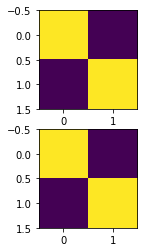

In [3]:
nsims = 10
nunits = 3   # Number of units to subsample
#nunits = callhist.shape[3]

# Test data
# 2 stims, 3 units, 3 reps
callhist_test = np.empty((2,3,5,3))
callhist_test[0,0,:,0] = [1,2,3,4,5]
callhist_test[0,0,:,1] = [1,2.2,3,4,5.5]
callhist_test[0,0,:,2] = [0.8,2,3,4.2,5]

callhist_test[1,0,:,0] = np.flipud([1,2,3,4,5])
callhist_test[1,0,:,1] = np.flipud([1,2.2,3,4,5.5])
callhist_test[1,0,:,2] = np.flipud([0.8,2,3,4.2,5])

callhist_test[0,1,:,0] = callhist_test[0,0,:,0]+1
callhist_test[0,1,:,1] = callhist_test[0,0,:,1]+1.2    # If these are exactly 1, the cor_mat becomes artificially symmetric
callhist_test[0,1,:,2] = callhist_test[0,0,:,2]+1.1

callhist_test[1,1,:,0] = callhist_test[1,0,:,0]+1
callhist_test[1,1,:,1] = callhist_test[1,0,:,1]+1
callhist_test[1,1,:,2] = callhist_test[1,0,:,2]+1

callhist_test[0,2,:,0] = callhist_test[0,0,:,0]-1
callhist_test[0,2,:,1] = callhist_test[0,0,:,1]-1
callhist_test[0,2,:,2] = callhist_test[0,0,:,2]-1

callhist_test[1,2,:,0] = callhist_test[1,0,:,0]-1
callhist_test[1,2,:,1] = callhist_test[1,0,:,1]-1
callhist_test[1,2,:,2] = callhist_test[1,0,:,2]-1

sim_decode(callhist_test,nsims,nunits)


(20, 10, 68, 54)
(20, 9, 3400)
X: (180, 3400)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3400)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.38583347]
 [0.38583347 1.        ]]
[[ 3.85833468e-01  1.95237049e-02 -3.03830974e-03  

[0. 0. 0. ... 0. 0. 1.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.      0.06167]
 [0.06167 1.     ]]
[[ 6.16700039e-02  8.37251862e-03  3.24457043e-02  2.74705945e-03
  -1.72850371e-03  3.33397800e-02 -5.33827669e-03  1.71313093e-02
   4.48359571e-03  3.16462463e-03  1.08714467e-02  1.79891798e-02
  -1.47958121e-03 -1.73544338e-02 -1.19246778e-02  1.24219039e-02
   1.12354292e-02  1.05661575e-03  3.08971184e-02 -5.16563542e-03]
 [-8.03123087e-03  1.28708773e-01  5.84728851e-03  1.02034325e-02
   2.51387470e-02  2.90557290e-02 -1.76000036e-03 -1.79000842e-02
  -1.17521702e-02  1.27208172e-02  1.15792296e-04  1.97525517e-02
   1.27148383e-01  2.36532046e-02  1.36287761e-02  1.41298075e-02
  -6.18491549e-03 -3.64631696e-03  8.14647075e-02  4.66920122e-02]
 [ 1.47455991e-02  7.68201313e-03  3.47688016e-01  4.64807396e-02
   4

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.46810043]
 [0.46810043 1.        ]]
[[ 4.68100433e-01  3.23590541e-02  2.84757663e-03 -9.67634524e-03
   2.77952087e-02  1.68413544e-01 -8.06981363e-03  1.43879376e-01
   2.16516406e-02  1.71799796e-02 -1.63920735e-03 -3.93807768e-03
   4.38113235e-03  2.19930220e-02  9.66755995e-02  4.93874369e-02
  -3.67507846e-03  1.64634944e-02  5.83939790e-02  1.18804298e-02]
 [ 2.53429249e-02  1.19472858e-01  1.64964718e-02  1.18704767e-03
   4.27547871e-02  4.44836609e-02 -5.80401885e-03  1.00253590e-02
   3.57362132e-03 -3.75288209e-04 -3.54091785e-04  3.73743492e-02
   4.43707275e-03  7.50217877e-03  9.01083975e-03  2.13010339e-02
   2.42173686e-02 -3.63095078e-03  3.77245168e-02  5.46596687e-02]
 [-7.99151380e-03 -1.89751272e-02  3.50700889e-01  1.15554

[0. 0. 1. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.49493039]
 [0.49493039 1.        ]]
[[ 4.94930385e-01  1.58665311e-02 -1.72709152e-03  1.65954433e-02
   2.13535955e-02  1.29098723e-01  3.22863343e-03  1.47658100e-01
   3.93615180e-02  7.13671741e-02 -5.32086224e-03  1.11846987e-02
   7.33193473e-05  5.86014792e-03  3.96634245e-02  8.69392157e-02
   3.25915025e-02  4.59120240e-03  2.80879038e-02  3.92154817e-03]
 [ 4.62346693e-02  1.57141818e-01 -7.05603116e-03 -4.49970546e-03
   4.36590917e-02  3.97288925e-02  4.47886726e-04  3.02928465e-02
   1.50528849e-02  2.00303739e-02  2.27287605e-02  1.20157857e-17
   1.02967159e-01  1.30134374e-02  6.22474407e-03  2.43017352e-02
   7.96939846e-04  1.56640279e-03  9.24999674e-02  4.29887586e-02]
 [-1.32375803e-02  1.54234492e-02  3.26118910e-01  6.70957

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.46357046]
 [0.46357046 1.        ]]
[[ 4.63570463e-01  4.07908784e-02 -1.20347444e-02  1.86758425e-02
  -1.38583539e-03  2.07407410e-01 -9.07538168e-03  1.36967096e-01
   2.97385385e-02  1.72838447e-02 -1.15126016e-02  1.49092167e-02
  -5.34594787e-04  1.30329902e-02  3.37184293e-02  2.94314241e-02
  -4.82398333e-03  2.16593047e-02  4.92668139e-02  6.12674995e-03]
 [ 2.97142569e-02  1.23211164e-01  1.94305143e-02 -4.64728262e-03
   2.36443465e-03  6.87677185e-02  1.92755171e-02  2.79761446e-02
   2.63203372e-02 -7.58249156e-03  9.78950342e-02  6.54506304e-02
   5.83662326e-03  2.14763483e-02  1.22361933e-02  2.40257697e-03
   1.54416965e-02  5.19417917e-03  2.21346659e-02  1.75479736e-02]
 [ 1.54313945e-02  1.11139534e-02  2.98682752e-01  2.27534

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.         0.11111111 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.41524445]
 [0.41524445 1.        ]]
[[ 4.15244449e-01  1.16001949e-01 -5.05533076e-03 -1.03894026e-04
   2.57191732e-02  2.33443539e-01  6.92515526e-03  1.52282555e-01
   1.29203308e-02  1.59226665e-02  1.68677157e-02  1.35383045e-02
   1.59122119e-02  6.11619952e-03  5.83943423e-04  3.11127434e-02
  -1.09330073e-03  3.29261092e-02  6.38526418e-02  3.09390847e-03]
 [ 1.61253490e-02  2.19624205e-01  5.97438785e-04  1.72791209e-02
  -1.06890986e-02  5.74517242e-02  3.17680821e-02 -1.30297376e-02
  -1.82034892e-02  2.25196805e-02  5.18744340e-02  1.88642367e-03
   6.24351540e-02  1.57649798e-02  2.58093739e-02  1.57466146e-03
   4.12564661e-02  8.40874754e-03  1.01593435e-01  4.41452318e-02]
 [ 3.79740

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.41992244]
 [0.41992244 1.        ]]
[[ 4.19922442e-01  2.47263351e-02 -2.08475883e-02 -6.97319589e-03
   9.43973474e-03  1.08841042e-01  8.16321049e-03  7.83327927e-02
   2.71481676e-02  1.92222646e-02  5.35238962e-03  5.32580112e-03
  -1.61312165e-02 -1.40009278e-02 -1.27237781e-02  5.43881034e-02
  -2.39078205e-03 -1.12250680e-02  1.60963775e-02  1.13468453e-02]
 [ 1.25121830e-01  1.62540652e-01 -3.58511044e-03  4.37327414e-02
   5.00769309e-02  9.11612681e-02 -6.18216157e-04  8.96257818e-03
   1.16802175e-02  1.50149769e-02  1.67942172e-02  2.18381026e-02
   6.14696136e-02 -4.22455690e-03  1.35110671e-02  1.25311457e-02
   7.70065350e-03  1.28625760e-02  9.14959417e-02  4.05197146e-02]
 [ 7.84532501e-03  3.53333624e-02  2.08789376e-01  2.67376

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[[1.         0.11841782]
 [0.11841782 1.        ]]
[[ 1.18417818e-01 -1.09352542e-02 -4.23427686e-03  3.78957882e-03
  -8.46599657e-03  1.38364026e-02  1.91414776e-02  3.43117991e-02
  -1.52637361e-02  5.52256135e-02  3.00253517e-02  1.76828854e-02
   1.21477655e-02 -1.49986192e-04 -9.77520722e-03 -1.24057767e-04
  -1.01893466e-02  3.18436372e-02  4.93304929e-02  6.03450437e-03]
 [ 1.41815433e-02  1.43178052e-01  7.64264427e-03  3.77856133e-03
   3.11036578e-02  4.90188453e-02  8.33873605e-03  1.68646676e-03
   5.08943936e-03  2.31705529e-02  5.89381569e-02  1.14477173e-02
   2.87516643e-02 -2.19505836e-03 -2.74540017e-03  9.80437092e-03
   3.65029957e-03  1.25340385e-02  2.74859328e-02  1.78100123e-02]
 [ 2.65809700e-03  5.42780705e-03  3.39402629e-01  3.46701

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.48929128]
 [0.48929128 1.        ]]
[[ 4.89291277e-01  1.06277478e-02 -4.44336711e-03  2.44560688e-02
   8.46254006e-03  1.40053403e-01 -6.42453160e-03  1.44740704e-01
   2.15505745e-02  1.72561878e-02 -2.87839943e-03  3.78091717e-04
  -2.08263214e-03  2.69219057e-03  4.78930150e-02  8.36176268e-02
  -1.03898081e-04  6.48562773e-03  2.48371964e-02  1.18002008e-02]
 [ 5.05219338e-02  9.38340419e-02 -2.41381927e-03  1.40293550e-02
   1.43676670e-02  5.08362129e-02 -2.12331433e-04  6.04555344e-02
   1.17080471e-02  3.14733068e-02 -3.23735031e-03 -1.79102957e-02
   2.49985340e-02  1.98652138e-02  6.63731095e-03 -2.55725350e-03
  -3.88367564e-03  7.61919185e-03  6.19255715e-02  3.25340315e-02]
 [ 2.18391153e-03 -8.28531173e-03  4.24928069e-01  1.01134

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.50635826]
 [0.50635826 1.        ]]
[[ 5.06358260e-01  3.05309971e-03 -1.32702783e-02  2.48951959e-02
   9.46508447e-03  1.24943263e-01 -6.78480891e-04  1.60709702e-01
   1.98584485e-02  2.75309162e-02 -9.48668997e-03 -1.76050197e-03
  -1.43537620e-02 -5.22516884e-03  5.88618045e-02  1.11438257e-01
   2.73784663e-02  1.73197124e-03  3.52808883e-02  1.30080194e-02]
 [ 1.09480103e-01  7.57333839e-02  6.14308790e-03  3.93558474e-02
   2.54162990e-02  4.40242576e-02  2.91090786e-03  6.41827326e-02
   1.61401894e-02  5.86958410e-03  1.12760657e-02 -1.70722872e-02
   3.83170281e-03 -6.30405019e-04  2.50061287e-02  8.10263024e-03
   1.09415823e-02 -5.09433482e-03  4.51745696e-02  2.66491772e-02]
 [-1.68433014e-02 -3.65672891e-04  3.41193126e-01  3.48099

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.38877389]
 [0.38877389 1.        ]]
[[ 3.88773892e-01  1.15042420e-01 -7.64024396e-03 -9.32662874e-03
   6.80197498e-03  2.16656860e-01  1.30667802e-03  9.62784273e-02
   8.81284841e-03  5.93581320e-02 -6.69961317e-03 -3.28604634e-04
  -6.58370311e-04 -1.05039748e-02 -1.41595482e-02  6.20355847e-02
  -1.39276426e-02 -4.47952710e-03  5.47671021e-02  6.35804671e-03]
 [ 4.62411564e-02  2.06211203e-01 -4.48628120e-03  9.96352480e-03
   2.97547087e-02  8.97289117e-02  8.54272185e-03 -2.63124180e-03
  -3.38506539e-04 -7.05873565e-04  3.89711322e-02 -4.98226245e-03
   2.02241299e-02  1.74809348e-03 -9.92934093e-04  2.22241705e-02
   6.91921740e-03  9.33039852e-03  9.58766715e-02  2.16371478e-02]
 [ 1.71803692e-02  1.79392008e-03  3.41242412e-01  3.70920

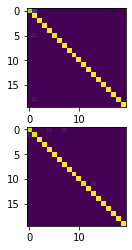

In [8]:
callhist_bu = callhist_all[:,:,:, (callhist_type_all == 'Burster_h') | (callhist_type_all == 'Burster_l')]

print(callhist_bu.shape)    

nsims = 20
nunits = 50

accu50_bu = sim_decode(callhist_bu,nsims,nunits)

In [ ]:
callhist_RS = callhist_all[:,:,:, (callhist_type_all == 'RS')]

print(callhist_RS.shape)    

nsims = 20
nunits = 50

accu50_RS = sim_decode(callhist_RS,nsims,nunits)

(20, 10, 68, 110)
(20, 9, 3400)
X: (180, 3400)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3400)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  0  2  3  5  5  5  5  8  5  0 11 13 11 14 15  9 17  4  0]
[0.11111111 0.         0.11111111 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.08572254]
 [0.08572254 1.        ]]
[[

[0. 0. 0. ... 0. 0. 1.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  2  4  0  6  7  8  9 10 11 13 13 14 15 17  7  4 17]
[0.         0.         0.11111111 ... 0.22222222 0.22222222 0.66666667]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.25839698]
 [0.25839698 1.        ]]
[[0.25839698 0.16975144 0.04472557 0.03647724 0.06686628 0.2391862
  0.06279116 0.1370181  0.10051102 0.05057941 0.09444216 0.09767715
  0.07598433 0.04198937 0.10256941 0.0808495  0.0748181  0.07271947
  0.11794225 0.11732717]
 [0.23104158 0.42201128 0.03655632 0.03092541 0.10566193 0.1660839
  0.06712592 0.09215217 0.05812098 0.06663066 0.03481398 0.09624272
  0.0347604  0.05493707 0.09494513 0.07618861 0.07934399 0.07324891
  0.08149957 0.05040242]
 [0.01181652 0.05185111 0.31205861 0.3310695  0.19837854 0.06657947
  0.12439689 0.1207307  0.14121795 0.13259005 0.13543717 0.11600657
  0.21691676 0.26914268 0.22647149 0.28698147 0.05510255 0.08208991
  0.11651175

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 1  5  5  2  4  5  5  9  5  5 12 11  1  5 14 14  3 17  5  5]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.06209959]
 [0.06209959 1.        ]]
[[ 6.20995871e-02  1.29148662e-01 -1.38243489e-02 -1.10953094e-02
   2.03041341e-03  3.25927114e-02  3.99915618e-02  3.97763367e-02
   8.57132828e-03 -5.39430259e-03  7.21165822e-03  3.19267123e-04
  -1.07489462e-02 -7.13805265e-03  2.90155729e-02  9.92525885e-03
   4.03591251e-02  2.59042647e-02  4.02928527e-02  3.40135265e-02]
 [ 2.48616487e-02  4.90680066e-02  2.48071384e-02  4.26296252e-02
   1.36892126e-02  2.28232929e-02  5.66185159e-02  1.85946679e-02
   1.24098648e-02  4.36420625e-02  1.50496390e-02  3.11175962e-02
   1.00286232e-02  2.69883880e-02 -1.13706818e-03  1.51693956e-02
   2.82256952e-02  2.20904988e-02  5.36709122e-02  3.18747306e-02]
 [ 8.56356137e-02  7.37534194e-02  1.71769546e-01  1.28429

[1. 1. 1. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  9  5  6  7  8  3 10  3 12 13 14 15 16 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.33601865]
 [0.33601865 1.        ]]
[[0.33601865 0.31334157 0.08322796 0.08179715 0.14428327 0.23083581
  0.12016621 0.10055903 0.13516118 0.0975028  0.07896679 0.09226313
  0.10181125 0.10147944 0.04928185 0.03324363 0.09923167 0.09567563
  0.13738425 0.15311621]
 [0.23492411 0.26239725 0.03865274 0.0230735  0.08252731 0.20178627
  0.10457921 0.1189982  0.07715507 0.11222069 0.06359976 0.06478768
  0.07052267 0.07565273 0.07729396 0.05506266 0.04526588 0.15474244
  0.07141133 0.07816866]
 [0.06846366 0.06938525 0.26523076 0.20695635 0.16147963 0.06907683
  0.06770241 0.04876734 0.07316532 0.0687773  0.08511155 0.05855535
  0.09041353 0.15543302 0.04993182 0.06850236 0.05618346 0.11291939
  0.10212365 0.08732983]
 [0.05378928 0.05177023 0.1193268

In [8]:
nsims = 20
nunits_list = [10, 25, 54]

accu_bu = np.empty(len(nunits_list))
accu_bu.fill(np.nan)

for i in range(len(nunits_list)):
    accu_bu[i] = sim_decode(callhist_bu,nsims,nunits_list[i],LDA=False)
    
accu_bu

NameError: name 'callhist_bu' is not defined

(20, 9, 680)
X: (180, 680)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[ 1.         -0.00822022]
 [-0.00822022  1.        ]]
[[-8.22021847e-03  1.85024975e-02  1.50759970e-01  7.72225875e-02
   1.22811410e-01 -4.15084557e-02  1.36915790e-02  9.52738396e-02
   1.95046259e-02  1.85323564e-01  1.35859738e-01  9.54511432e-02
   1.67563115e-01  1.30550120e-01  9.79861612e-02  1.51763083e-01
   7.96951110e-02  6.66456444e-02  1.31564873e-02 -3.76567046e-02]
 [ 4.34159257e-02  1.09187306e-01  5.04901637e-02  4.66360960e-02
   1.84496310e-01 -3.24405474e-02  6.27090677e-02  5.10595971e-02
   1.82984318e-01 -1.19929478e-02  9.69347928e-02  9.38820072e-02
   8.46242146e-02  6.96561699e-02  1.79655667e-01  1.10902324e-01
  -3.52401818e-02  1.15606141e-01  8.55760831e-02  8.37795357e-02]
 [ 6.06442527e-02  4.59067492e-03  3.27919060e-01  2.26222576e-01
   2.42262446e-01  8.40694342e-02  8.52939404e-02  8.84085087e-02
   1.11121543e-01  2.43949549e-01  1.57387069e-01  2.21489896e-01
   3.73420108e-01  2.99085985e-01  2.03381482e-01  2.58654929e-01
   6.62287571e-02  

[[1.         0.29519479]
 [0.29519479 1.        ]]
[[ 2.95194794e-01  1.12611527e-01  6.29194021e-02 -2.86384379e-04
   1.62765471e-02  1.25802525e-01  8.53962805e-02  5.47382511e-02
   6.18213414e-02  3.19663847e-02 -2.01654877e-02  7.37834370e-02
   3.27776852e-02 -2.12720689e-02  1.24058035e-02 -2.97083616e-02
   9.82984223e-02  1.00861381e-01  1.28752792e-01  2.64309613e-02]
 [ 1.41768710e-01  8.70862478e-02  4.75787089e-02  6.46274082e-02
   9.19814173e-02  1.69657349e-02  6.64131257e-02  5.47382511e-02
   1.25580460e-01  9.12494981e-02  8.61212329e-03  2.35437135e-02
   6.80003259e-03 -1.77745050e-03 -1.37116776e-02 -1.02649681e-02
   9.82984223e-02  7.27178686e-02  1.28752792e-01 -6.63813471e-03]
 [ 4.12497001e-02  1.73458709e-01  2.90326013e-01  4.86316985e-01
   3.07757507e-01  3.86135795e-02  2.92419840e-01  2.99748158e-01
   3.38354203e-01  2.87849547e-01  3.03974179e-01  2.48534485e-01
   3.63822860e-01  4.24030737e-01  4.43301718e-01  3.69262636e-01
   1.06245554e-01  1.70

 0. 0. 0. 0. 0. 0. 0. 0.]
[[1.         0.06239724]
 [0.06239724 1.        ]]
[[ 6.23972379e-02  3.41304653e-02  2.83528005e-02  1.30124695e-02
   3.65126949e-02  9.73503136e-02  2.55455431e-01  7.00397303e-02
  -1.19655047e-03  2.34678706e-02  2.24328099e-01  1.67861432e-01
   2.88572630e-01  1.43102458e-01  2.29564038e-01  1.89085935e-01
   2.59057758e-01  3.86826271e-02  6.13315799e-02  2.15102323e-01]
 [ 6.43879283e-02  7.90789770e-02  1.16389780e-01  2.55038396e-01
   2.63123519e-01  2.38464684e-01  1.90363360e-01  1.37227146e-01
   5.52760392e-02  1.50872748e-01  2.32499297e-01  1.88311436e-01
   1.95440671e-01  2.20626677e-01  1.67138731e-01  1.40453450e-01
   1.06179272e-01  3.10050989e-02  7.87335431e-02  1.81558785e-01]
 [ 3.24749462e-02  1.77247652e-01  3.12127459e-01  2.94783867e-01
   3.53816109e-01  1.05105380e-01  5.63879335e-02  5.75430418e-02
   4.85548947e-02  7.12224086e-02  4.13010971e-02  9.69831698e-02
   7.26026880e-02  1.36788318e-01  5.18981562e-02  2.32801121e-

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[1.         0.06324481]
 [0.06324481 1.        ]]
[[1.         0.06995725]
 [0.06995725 1.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

(20, 9, 680)
X: (180, 680)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11111111 0.
 0.11111111 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[1.         0.14725898]
 [0.14725898 1.        ]]
[[ 1.         -0.03009167]
 [-0.03009167  1.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

[[1.         0.23168584]
 [0.23168584 1.        ]]
[[1.        0.0015429]
 [0.0015429 1.       ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

[[1.         0.31026725]
 [0.31026725 1.        ]]
[[1.         0.26841135]
 [0.26841135 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.11111111 0.         0.         ... 0.         0.         0.        ]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.11111111 0.11111111 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.42844927]
 [0.42844927 1.        ]]
[[ 

[[ 0.20852689  0.13464783  0.02428085  0.0379509   0.00932829  0.04970856
   0.0320532   0.08326854  0.04462804 -0.00156845  0.03969349  0.01447874
   0.00407497  0.03041525  0.08347883  0.02754342  0.05068218  0.08191266
   0.02479977  0.08389337]
 [ 0.10499426  0.12650767  0.02884896  0.10717465  0.05074867  0.04970856
   0.07830993  0.16732823  0.06951085  0.01582092  0.05467106  0.03410701
   0.02440992  0.06534119  0.09198788  0.03095424  0.06547608  0.11393923
   0.10631857  0.06079348]
 [ 0.03423749  0.08006569  0.20774824  0.23893661  0.07915608  0.08006606
   0.06523099  0.06309332  0.01394229  0.0246753   0.01621524 -0.00429687
   0.02865775  0.0577582   0.05623294  0.09027894  0.0075118   0.03425876
   0.08191986  0.11148877]
 [-0.01213861  0.08106097  0.09189804  0.12500514  0.02081274  0.03723642
   0.0158078   0.02708269  0.04991256  0.010525    0.02563355 -0.01291121
   0.0031505  -0.00179926  0.01742304 -0.01375759  0.00862746 -0.00117037
   0.01260598  0.04435772]
 [-0

[[ 0.15240189  0.08682697  0.1771783   0.15640183  0.06370984  0.05494209
   0.09753564  0.09570294  0.02910187  0.03824132  0.03289752  0.06012598
   0.07574721  0.09809856  0.03615154  0.04821278  0.06889407  0.00557256
   0.20244562  0.13265237]
 [ 0.0848991   0.16648739  0.02747361  0.05411248  0.08459365  0.04963305
   0.03581222  0.01967626  0.04419723  0.03353239  0.0489526   0.09970139
   0.02181035  0.06768432  0.07880096  0.05155876  0.09317339  0.00080603
   0.02082456  0.00933241]
 [ 0.10047523 -0.00318398  0.10204174  0.13232439  0.18229913  0.07647942
   0.00478506  0.10253363  0.06742127  0.0089603   0.04070315  0.09179428
   0.11198651  0.08284106  0.06245306  0.06290938  0.15913561  0.11901683
   0.07585778  0.08718727]
 [ 0.06971654  0.07569849  0.16020185  0.31092504  0.02437322  0.08300253
   0.04369539  0.01574958  0.07380491  0.10967502  0.05705291  0.09922285
   0.08956431  0.05220659  0.04808052  0.05048386  0.10473241  0.00583506
   0.12897936  0.13890099]
 [ 0

[[ 8.97791042e-03  4.04225544e-02  3.40718960e-02  2.73152955e-02
   1.04734834e-01  1.53525905e-02 -3.14842166e-02 -3.08977727e-02
   1.10950563e-02 -1.35605034e-02 -6.32261578e-03 -2.04846502e-02
   3.69383545e-02  1.17177158e-02 -1.03299501e-02  2.38357717e-02
   3.36189132e-03  6.90665248e-02  2.06756705e-04  5.37594563e-02]
 [ 6.25994133e-02  4.49585464e-02  1.60465098e-02 -2.33715678e-03
   9.94090958e-02  5.23727176e-02  3.55160428e-03  3.05152146e-02
   8.79825745e-02  4.87768353e-03  1.79095701e-02  4.64696251e-02
   2.35434913e-02 -2.67538933e-02  4.92295720e-04  2.08904297e-02
  -2.42748748e-02  2.88833023e-02  3.17285634e-02 -1.10459845e-02]
 [ 2.41607636e-02 -1.21665327e-02  9.99967350e-02  1.12617335e-01
   6.49817544e-02 -7.03462308e-03  2.83937530e-02  1.66577680e-02
   2.27104649e-02  1.93637055e-02 -3.62208600e-03  7.17356130e-02
   9.60051860e-02  4.77337281e-02  8.71354358e-02  3.69716993e-02
   5.61427936e-02  8.16593676e-02  7.03553797e-02  1.22594972e-01]
 [ 2.97

[[ 7.20925896e-02  9.89968780e-03  1.74527569e-04 -3.39860979e-03
  -8.19926751e-03 -4.25317066e-02  2.31393540e-02  4.49191637e-02
  -2.91080160e-02  3.57213423e-03  3.77216297e-02 -1.35076878e-02
   4.07182471e-02  8.09573353e-03  1.67991686e-02  5.74762769e-03
   1.11825647e-02  2.40136305e-02 -1.74765379e-02  3.71265012e-03]
 [ 9.40905507e-03  4.86563479e-02  1.52498936e-02  1.76299557e-02
   2.53697008e-02  4.21033047e-02 -2.93533716e-02 -6.65003197e-03
  -1.91148190e-02  4.38138637e-02  1.68848149e-02 -2.05285340e-03
   1.55628857e-02  2.94155416e-03 -2.52183181e-02  9.18396917e-04
   2.79089489e-02  4.06228161e-02  7.00490839e-03  6.72516865e-03]
 [ 2.30403286e-02  3.54442856e-02  1.93611934e-01  1.49298212e-01
   1.20560199e-01  1.20348309e-03 -2.79492766e-03  2.29024258e-02
   6.92336582e-02  3.95041268e-02 -1.78039039e-02  5.47718862e-03
   6.48483216e-03  2.84456775e-02 -1.39991068e-02  7.11121363e-03
   1.76324349e-02  1.14774909e-01  1.40968802e-01  8.50369349e-02]
 [ 3.73

[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.06629492]
 [0.06629492 1.        ]]
[[ 6.62949222e-02  3.51701924e-03  1.67852161e-02  1.42188745e-02
   3.32125541e-02  6.62959678e-02  1.29179872e-01  1.93337417e-03
   2.11931799e-02 -3.37198933e-02 -1.72785716e-02  5.63069617e-02
   7.07965706e-03 -3.44859597e-03  1.83855731e-03  2.73139598e-02
   9.51225074e-02  5.21783242e-02 -8.87062160e-03 -8.69558115e-03]
 [ 2.40164964e-02  5.42321363e-01  7.91878478e-03 -1.90798726e-02
  -3.05105106e-02 -4.25117282e-02  1.70197904e-02  4.06094173e-02
   2.42623634e-02  6.40561199e-02  2.67329488e-02  1.38063253e-02
   8.09202180e-03 -1.94529117e-02  4.43741202e-02 -5.78203838e-03
   8.53746384e-02  1.23963947e-01  4.60488370e-02  2.50182530e-02]
 [-3.95912455e-03  5.22957159e-02  3.07738232e-01  3.03367311e-01
   2.15946303e-01  1.30374254e-01  7.66956138e-02  6.42521902e-02
   5.22013309e-02  1.23745187e-02  5.7249023

[[ 7.18299538e-02  2.68069456e-02  3.91935906e-02  3.60369651e-02
   4.58834052e-02  4.12068094e-02  2.81848154e-02  1.25734413e-01
   1.72760867e-02  2.30329364e-02  7.45990267e-02 -2.31370871e-02
   6.26782379e-02  1.65090515e-02  7.04093266e-02  6.27088627e-02
   5.47059591e-02  3.92904698e-02  5.33988511e-02  7.38150363e-02]
 [ 1.36336613e-01  1.00795449e-01  3.55038374e-02  3.11845077e-02
   1.65461845e-02  8.64540616e-02  9.17089861e-02  8.11448740e-02
   6.98122132e-02  6.51438417e-02  9.26020130e-03  1.23271595e-01
   2.41803821e-02 -2.54253991e-03  1.02820961e-01  5.41128472e-02
   5.38486117e-02  3.14895002e-02  5.88320666e-02  7.71654394e-02]
 [ 7.82568917e-02  3.83401904e-02  1.29097868e-01  1.20004891e-01
   1.20327860e-01  3.49669683e-02  5.46989453e-02  5.90715426e-02
   7.06864337e-02 -1.08345641e-02  8.52251360e-03  7.11031532e-02
   3.22177063e-02  4.28816421e-02  7.76139802e-02 -3.56802675e-03
   5.03281546e-02  2.06868692e-03  1.27221327e-01  1.01513231e-01]
 [ 3.14

[[1.         0.08064662]
 [0.08064662 1.        ]]
[[1.         0.06405601]
 [0.06405601 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.         ... 0.         0.11111111 0.        ]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.08949488]
 [0.08949488 1.        ]]
[[ 8.94948785e-02  1.42294199e-02 -4.46671987e-03  

[[1.        0.2419579]
 [0.2419579 1.       ]]
[[1.         0.37565613]
 [0.37565613 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.11111111 0.11111111 0.         ... 0.11111111 0.         0.        ]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.         0.         0.         ... 0.         0.11111111 0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.0528697]
 [0.0528697 1.       ]]
[[ 0.052869

[[1.         0.10214951]
 [0.10214951 1.        ]]
[[1.         0.07795958]
 [0.07795958 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.29454513]
 [0.29454513 1.        ]]
[[ 2.94545132e-01  2.17102028e-01  3.40373101e-02  4.47117204e-02
   1.44443421e-01  2.18895188e-01

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.05834251]
 [0.05834251 1.        ]]
[[ 5.83425101e-02  3.92951205e-02  5.00264276e-02  2.95058878e-02
   4.17234243e-02  4.27228852e-02 -2.45153555e-03  1.51011494e-02
   3.40737775e-02  5.06433182e-02  2.50058862e-03 -7.99515977e-03
  -7.80716293e-03  4.32847233e-02  1.80806826e-02  1.86231559e-02
  -2.05370270e-03  5.14446035e-02  4.26925761e-02 -2.19489865e-02]
 [-4.26849192e-03  3.92635715e-02  2.45504898e-02  1.23560609e-02
   6.44596352e-02  5.80582837e-03  8.91239412e-03  3.18597735e-02
   5.80284526e-02 -5.25990600e-03  1.31794732e-03  4.03394099e-02
   3.20704553e-02  2.36331304e-03  8.64245242e-03 -7.01589465e-03
   3.82028449e-04  4.68294885e-02  2.32709918e-02  2.12778815e-02]
 [-6.97071121e-03 -1.87483584e-02  1.29481219e-01  5.78099744e-02
   9.92336220e-02  1.68405834e-02  5.95123902e-03 -6.45753300e-03
   2.9

[[1.         0.23140656]
 [0.23140656 1.        ]]
[[1.         0.25981808]
 [0.25981808 1.        ]]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.         0.11111111 0.         ... 0.         0.         0.        ]
[1. 0. 0. ... 0. 0. 0.]
[[1.         0.15092796]
 [0.15092796 1.        ]]
[[ 1.50927964e-01  1.51657566e-01 -5.12256037e-03 -

[[ 2.39329570e-01  2.01085556e-01  3.89156852e-02  4.54293200e-02
   8.08615409e-02  1.74893471e-01  9.35937586e-02  1.59303983e-01
   9.45105163e-02  1.00072209e-01  8.27170817e-02  7.41564326e-02
   6.78181233e-02  1.91942492e-02  9.74007256e-02  2.34338750e-02
   1.31416175e-01  9.35177241e-02  9.57793699e-02  1.07074655e-01]
 [ 2.44472848e-01  2.41151220e-01  4.66296314e-02  1.03170005e-02
   9.29706799e-02  1.79173670e-01  8.69464991e-02  1.22749970e-01
   9.52984432e-02  6.64717606e-02  6.57846002e-02  5.86780801e-02
   4.37059202e-02  4.10906460e-02  1.00071275e-01  4.76161953e-02
   8.81308140e-02  1.00872689e-01  1.08843969e-01  8.93757791e-02]
 [ 3.78060831e-02  3.54850660e-02  1.26908877e-01  9.96101050e-02
   5.82672377e-02  8.81294179e-02  1.95301762e-02  1.31942200e-02
   5.62683025e-02  9.42729608e-03  3.70730353e-02  4.49192477e-02
   1.94754482e-02  5.08290717e-02  4.42288957e-02  4.00797411e-02
   4.65183240e-02  8.51610381e-02  4.23398736e-02  5.94328858e-02]
 [ 4.27

[[1.         0.08355921]
 [0.08355921 1.        ]]
[[1.         0.28686125]
 [0.28686125 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.11111111 ... 0.         0.         0.        ]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 1. 2. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.         0.         0.         ... 0.22222222 0.22222222 0.        ]
[0. 0. 1. ... 0. 0. 0.]
[[1.         0.09966914]
 [0.09966914 1.        ]]
[[ 

[[1.         0.10896738]
 [0.10896738 1.        ]]
[[1.         0.29083698]
 [0.29083698 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.11111111 ... 0.         0.11111111 0.11111111]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.25158403]
 [0.25158403 1.        ]]
[[ 2.51584030e-01  2.64833436e-01  4.29431628e-02  

[[ 0.1171833   0.04429864  0.03880826  0.03358318  0.02365346  0.01334476
   0.04175313  0.06105895  0.04175789  0.03289747  0.00458298  0.02755489
  -0.01650233  0.01458005  0.07278606  0.04504181  0.07394606  0.0544131
   0.02980986  0.04652408]
 [ 0.08110894  0.32506966  0.04789262 -0.00275264  0.01743657  0.04306083
   0.07539415  0.0553613   0.0406896   0.10097459  0.02993667  0.01685758
   0.01975841  0.01369339  0.06375813  0.04125326  0.04502443  0.08219126
   0.06437072  0.03362748]
 [ 0.05413438  0.01555382  0.2013142   0.15435056  0.10603102  0.10803176
   0.04346729  0.02764276  0.00528043 -0.00708404  0.03671996  0.04290482
   0.04689698  0.02571723  0.02506679 -0.00359614  0.04330066  0.06034497
   0.07629983  0.03350795]
 [ 0.04282173  0.02024794  0.25990894  0.23118393  0.06441521  0.02425078
   0.04154006  0.01754476  0.01356319  0.03823956  0.02445174  0.05249682
   0.0455081   0.04000844  0.04123898  0.02820213  0.06447613  0.02692617
   0.06503322  0.10181278]
 [ 0.

X_leftout: (20, 6800)
y_leftout: (20,)
[0.11111111 0.         0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.2337954]
 [0.2337954 1.       ]]
[[0.2337954  0.11649256 0.0244659  0.02155813 0.07212971 0.15183708
  0.06493945 0.09005284 0.08682676 0.06869217 0.06056373 0.05482516
  0.06182173 0.02136959 0.0412825  0.02616771 0.05864061 0.07551867
  0.06932757 0.08838871]
 [0.20053084 0.30503354 0.02729185 0.03811266 0.06629455 0.14919254
  0.06308033 0.06549726 0.04801968 0.05038815 0.06150468 0.03541471
  0.04443389 0.01671237 0.04517051 0.01231356 0.04878203 0.06132409
  0.07447886 0.04625533]
 [0.0390646  0.02025136 0.14726789 0.09224968 0.06404991 0.03288573
  0.04516394 0.01653603 0.0337589  0.008009   0.01859565 0.00796781
  0.01851887 0.02882624 0.02874902 0.00280788 0.03983502 0.06707356
  0.03424394 0.07246346]
 [0.04079881 0.0344061  0.10896976 0.12942383 0.08126597 0.04846362
  0.04101945 0.02292846 0.04183392 0.03779674 0.03994688 0.0345

[[ 0.20367835  0.14863432  0.05329275  0.04763701  0.05539414  0.18355946
   0.05607893  0.11996748  0.0667689   0.0530056   0.08029539  0.05235368
   0.02409684  0.04662869  0.10794238  0.05295856  0.08207322  0.06336024
   0.06477162  0.07352736]
 [ 0.19323496  0.342519    0.0390219   0.03366059  0.06513043  0.17538994
   0.05853489  0.05968135  0.06406784  0.09562942  0.03512801  0.05615549
   0.04672572  0.04617544  0.07993091  0.04542154  0.0343573   0.07936774
   0.06104399  0.04610241]
 [ 0.01604938  0.01293663  0.26043557  0.20933998  0.15592311  0.04058934
   0.0937225   0.05043836  0.0539073   0.11752802  0.06613151  0.10232889
   0.16754845  0.16489038  0.11829853  0.15534611  0.07702654  0.06247752
   0.10024512  0.11373272]
 [ 0.03395809  0.05493324  0.23231563  0.28291775  0.14114521  0.04106041
   0.08654875  0.13097355  0.14245825  0.09674124  0.13830154  0.07791078
   0.09970111  0.14596691  0.12553016  0.11396431  0.12639563  0.1085409
   0.11591947  0.11814343]
 [ 0.

[[0.16909358 0.12642833 0.05151159 0.0339473  0.05432922 0.11072744
  0.04597671 0.07735949 0.05637239 0.08093108 0.04861106 0.03503763
  0.06100647 0.0423464  0.05484155 0.02951649 0.0439099  0.05218608
  0.04385435 0.04677723]
 [0.19044065 0.30394958 0.03438863 0.0018113  0.05367613 0.13267059
  0.04146464 0.0602478  0.06314178 0.05160954 0.03119077 0.04513772
  0.02989855 0.02643244 0.05645218 0.01474829 0.02401576 0.07713527
  0.06171261 0.04553896]
 [0.06241438 0.02210904 0.20638741 0.14519489 0.05752677 0.0457787
  0.06929845 0.05298839 0.04262391 0.07580515 0.09648222 0.08763443
  0.11328096 0.1184018  0.06811067 0.07351531 0.0436166  0.06671846
  0.06184202 0.06813924]
 [0.05706754 0.04945026 0.19536083 0.21407989 0.14181154 0.05189153
  0.07914257 0.07594815 0.14989204 0.10860076 0.11294661 0.14005664
  0.14260151 0.13523051 0.11764193 0.11857022 0.0441373  0.08833515
  0.13108131 0.12080704]
 [0.08443337 0.07158232 0.15470207 0.11813146 0.20525843 0.06947893
  0.02841847 0.04

[[0.13810042 0.12503512 0.05418577 0.06127147 0.06080377 0.07489067
  0.09994749 0.08495302 0.04561974 0.06405647 0.09372154 0.06995729
  0.06707509 0.05084027 0.05764799 0.06127428 0.08887849 0.07259726
  0.07340992 0.05167897]
 [0.11088851 0.29665395 0.05735811 0.06605922 0.10965556 0.13152939
  0.08779594 0.10561147 0.06294999 0.08728276 0.09102283 0.07990822
  0.0648608  0.05953861 0.08073913 0.04398524 0.0938455  0.07298635
  0.07418372 0.08752283]
 [0.03836013 0.04774875 0.21833476 0.18616491 0.16396143 0.04504818
  0.13625642 0.07909697 0.10153441 0.09660318 0.10513717 0.08130091
  0.15388019 0.14010088 0.14759032 0.12928628 0.07458366 0.06491758
  0.08860971 0.09593423]
 [0.04712903 0.04461257 0.27708924 0.30984742 0.22154336 0.0610387
  0.07770188 0.1030364  0.10179937 0.14219244 0.12009637 0.20702025
  0.28039921 0.31544577 0.17330434 0.2759847  0.15141088 0.06793001
  0.10397691 0.14222192]
 [0.07240174 0.09236598 0.0655903  0.1165141  0.20894933 0.07691029
  0.04238645 0.08

[[0.17332449 0.11177342 0.02539471 0.01071942 0.04872434 0.12214961
  0.06478541 0.07970625 0.06193617 0.0539687  0.05343507 0.05174796
  0.02902948 0.03414667 0.04138773 0.04293854 0.04700997 0.08471814
  0.05751797 0.04179113]
 [0.14363675 0.27352221 0.04129574 0.06801485 0.08177902 0.10673199
  0.06010863 0.10577995 0.10831412 0.04311707 0.0419803  0.04036078
  0.01599123 0.03748858 0.0785035  0.04277797 0.04773161 0.08548844
  0.06835431 0.04555399]
 [0.02376606 0.01774708 0.23359963 0.17435545 0.10762036 0.01556817
  0.06842484 0.03548401 0.05384345 0.08529671 0.07217242 0.09807894
  0.13015582 0.11944964 0.08168916 0.10245888 0.03094665 0.04266248
  0.03842878 0.09129388]
 [0.03462334 0.0247799  0.15069577 0.20531071 0.07087471 0.03371453
  0.01772611 0.05761544 0.05034514 0.05379284 0.07599782 0.05048463
  0.06706843 0.08557531 0.03966663 0.04603083 0.0634433  0.04447916
  0.05942127 0.09614772]
 [0.07603662 0.05837115 0.10779493 0.07990758 0.0855608  0.06423819
  0.01955502 0.0

[0.         0.         0.         ... 0.11111111 0.11111111 0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.22581013]
 [0.22581013 1.        ]]
[[0.22581013 0.11719565 0.00677905 0.04980295 0.07092442 0.13569154
  0.09399724 0.09447206 0.05667588 0.04833308 0.05185167 0.03992566
  0.04370353 0.02219111 0.05749201 0.02438708 0.057923   0.07378081
  0.08954799 0.09893269]
 [0.18227581 0.25279894 0.04554647 0.05664755 0.06955442 0.1444075
  0.08472522 0.06023998 0.0558948  0.05307603 0.08716984 0.04023541
  0.0437176  0.02154295 0.03366777 0.01235992 0.07094983 0.06895939
  0.05606915 0.07472919]
 [0.04781014 0.02913606 0.17863022 0.20903062 0.0797244  0.04171852
  0.1034718  0.05520613 0.08489853 0.03209481 0.10153415 0.10410597
  0.08238672 0.10596609 0.08318595 0.09980602 0.10651063 0.06512291
  0.0535218  0.05770858]
 [0.02252044 0.02666821 0.28243774 0.24894305 0.18534104 0.02724215
  0.09224829 0.06755296 0.10315559 0.17602679 0.13619213 0.12296619
  0.19330534 0.17990799 0.17365

[[1.         0.20689948]
 [0.20689948 1.        ]]
[[1.         0.28943519]
 [0.28943519 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.         ... 0.11111111 0.         0.        ]
(20, 9, 6800)
X: (180, 6800)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 6800)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.21059482]
 [0.21059482 1.        ]]
[[ 0.21059482  0.16781809  0.03888969  0.02535736  

[[0.2241821  0.14100412 0.05613052 0.03770509 0.08548365 0.14835637
  0.08506585 0.06840816 0.08534518 0.09785567 0.03727442 0.05181446
  0.05941074 0.02252261 0.04803208 0.02356537 0.08094694 0.05958659
  0.08592452 0.11295612]
 [0.2235322  0.27692558 0.03984972 0.0418039  0.06084866 0.12577464
  0.07940943 0.08424479 0.07667356 0.07756623 0.19272279 0.04076012
  0.09088287 0.03439689 0.02769206 0.01907635 0.0944221  0.05814447
  0.04980408 0.05150799]
 [0.0402557  0.02039958 0.32254059 0.30337591 0.20820598 0.06448161
  0.10946188 0.08779663 0.05607552 0.13732849 0.13866502 0.20647202
  0.30663054 0.30473909 0.15208452 0.26212834 0.14294128 0.0877665
  0.09357691 0.18966529]
 [0.04049777 0.03847976 0.19339139 0.23256775 0.11234829 0.05644603
  0.039872   0.05911151 0.06792533 0.13762499 0.07448815 0.09514656
  0.11219195 0.12263629 0.08667597 0.11732131 0.11280854 0.05050221
  0.05790741 0.10963992]
 [0.07941313 0.05352055 0.08327323 0.1128709  0.18707921 0.11406887
  0.05938324 0.04

[[ 0.20045194  0.11601088  0.01411092  0.03216626  0.04207931  0.11809607
   0.05681689  0.08221875  0.06048913  0.06049184  0.05388149  0.04390104
   0.02973268  0.0212      0.03667829  0.01475836  0.05383272  0.05391686
   0.03684366  0.04120539]
 [ 0.18557252  0.31812791  0.00434668  0.00234979  0.01896012  0.09756828
   0.06126916  0.05836783  0.0412321   0.07174122  0.0336533   0.02931466
   0.0069876   0.01299197  0.05409438  0.01720709  0.04401955  0.06845169
   0.04291723  0.02289497]
 [ 0.02786013  0.02726519  0.25623968  0.20452594  0.1396644   0.08375359
   0.07775994  0.07640449  0.07044197  0.10549434  0.07761762  0.15149977
   0.26142025  0.22443464  0.14549629  0.20162712  0.07767263  0.06391826
   0.09272698  0.11108861]
 [ 0.05217812  0.06105594  0.19099671  0.22277453  0.1266053   0.06571365
   0.08008521  0.09007945  0.11495237  0.06131586  0.04451328  0.06071455
   0.05899729  0.0951017   0.10143505  0.05589317  0.07081945  0.10879411
   0.1468051   0.13305566]
 [ 0

array([0.2875, 0.4575, 0.7   , 0.7775])

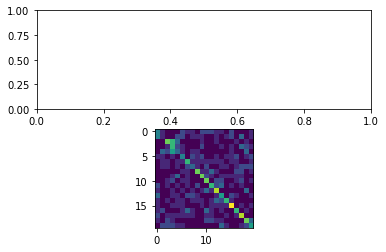

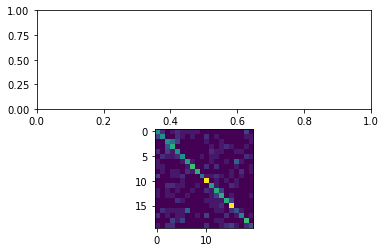

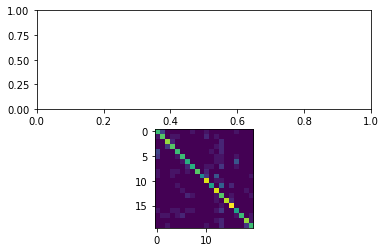

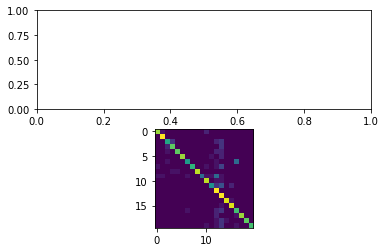

In [40]:
nunits_list = [10, 25, 54, 100]

accu_RS = np.empty(len(nunits_list))
accu_RS.fill(np.nan)

for i in range(len(nunits_list)):
    accu_RS[i] = sim_decode(callhist_RS,nsims,nunits_list[i],LDA=False)

accu_RS

(20, 9, 680)
X: (180, 680)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[1.         0.19141257]
 [0.19141257 1.        ]]
[[1.         0.51163324]
 [0.51163324 1.        ]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

[[ 1.30195054e-01 -1.89402845e-02 -3.21964118e-02 -3.03485556e-02
  -5.94535055e-02  3.08429905e-02  7.25588695e-02  5.12035728e-02
   2.04136904e-02 -4.25389749e-02  1.35895093e-02  3.34247604e-02
  -3.78346315e-03 -1.83532587e-02 -2.02873389e-02 -3.46893327e-03
   4.31511801e-02  4.18220148e-02  4.20422013e-02  7.90221491e-02]
 [ 8.96521295e-02  5.85383727e-01 -2.19987939e-02 -4.55956641e-02
  -3.26956626e-02  5.67927621e-02  4.83835941e-02  7.68573993e-02
  -8.51066334e-03  9.94592739e-03 -2.94538396e-02 -3.43833525e-02
  -4.59625783e-02 -4.94966083e-02  7.06687003e-03 -5.62825113e-02
   3.89134570e-02  6.37155925e-02  6.75831403e-02  2.19921425e-03]
 [ 6.40725860e-02  3.39293525e-03  1.71376201e-01  1.44018846e-01
   3.09625050e-01  5.32773994e-02  6.35620028e-02  2.29857935e-02
   5.21175772e-02  3.54270728e-02  5.16099979e-02  2.35961587e-01
   1.52985942e-01  2.25662738e-01  1.13131169e-01  1.66919083e-01
   3.32632779e-04  5.02004339e-02  1.78779784e-01  1.22205476e-02]
 [ 1.99

[[ 8.72530076e-03  4.11001805e-02  1.98920700e-01  8.34069739e-02
   1.67373817e-01 -3.26672314e-02  7.33058623e-02  7.06223234e-03
   1.91765429e-02  2.23554250e-01  1.42066382e-01  1.00695624e-01
   2.03377104e-01  1.72580847e-01  1.08707869e-01  2.02455650e-01
   1.51958054e-01  1.15235819e-01  1.64359016e-02 -1.94734737e-02]
 [ 8.65165141e-02  1.10211700e-01  4.53152121e-02  5.62875028e-02
   2.16258958e-01 -2.79772953e-02  1.38938601e-01  8.30141982e-02
   1.53672378e-01 -7.00886748e-03  9.07803184e-02  8.74546983e-02
   7.74363445e-02  7.05116088e-02  1.37004395e-01  9.47549159e-02
  -1.55313370e-02  9.21316027e-02  6.50062752e-02  9.53307036e-02]
 [ 3.49892975e-02 -5.29138285e-02  3.70666835e-01  1.69459607e-01
   1.73927734e-01  1.86319651e-02  5.59665904e-03  9.41032217e-02
   1.29204883e-01  2.57446932e-01  1.77076725e-01  2.44977313e-01
   3.66669776e-01  3.80667420e-01  1.45268137e-01  2.39761662e-01
   8.14123131e-02  1.26361294e-01  1.56816066e-01  1.92722077e-01]
 [ 1.46

[[ 2.32526561e-01  1.44642401e-01  8.39012965e-02  1.14097741e-01
   2.08935520e-01  2.45313562e-01  1.58219380e-01  1.67154498e-01
   1.53135708e-01  1.64122054e-01  1.45105355e-01  8.28859779e-02
   1.04860891e-01  1.36665420e-01  5.66402391e-02  6.93300130e-02
   1.65509650e-01  1.98965390e-01  1.28233427e-01  1.30627007e-01]
 [ 2.00096637e-01  4.80903879e-01  7.50052331e-02  1.16269299e-01
   1.46243134e-01  2.07521958e-01  7.96180184e-02  1.29447807e-01
   1.15084379e-01  7.67784511e-02  9.83992437e-02  6.13856552e-02
   1.02463478e-01  6.11414360e-02  9.94786281e-02  8.94453543e-02
   3.52046528e-02  2.82678177e-01  1.21238352e-01  5.45500673e-02]
 [ 6.50840146e-02  2.98014923e-02  3.22477696e-02  6.05947602e-02
   2.80688369e-02  1.13573112e-01  4.45511348e-02 -3.31173356e-02
   9.01090823e-02  6.74218756e-03  8.58355768e-03  1.34868699e-01
  -2.32292897e-02  7.69144902e-02  7.38435820e-02  3.56910497e-02
   5.09545495e-04 -1.62275049e-02 -4.36551088e-02  8.98513209e-03]
 [ 8.17

[[ 1.         -0.02870266]
 [-0.02870266  1.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[ 2.50170505e-01  1.62373694e-01  5.21512681e-02  1.30768340e-01
  -3.18680234e-02  8.29525481e-02 -5.18215330e-02  5.78688936e-02
   1.19380828e-01  1.25325170e-01  1.14539904e-01  1.96122945e-02
   1.55255314e-01  1.54785242e-01  1.14809864e-01  7.34195102e-02
   1.76491956e-02  2.05139318e-02  2.39947441e-03  1.52558256e-02]
 [ 6.21447091e-02  3.35053129e-02  5.08922408e-02  8.47060793e-02
   4.24602461e-02  5.69366738e-02  5.02151701e-02  8.35613121e-02
   1.60667033e-03  4.98772836e-02 -2.77473495e-03 -6.56768078e-03
  -5.00206794e-02  2.41914858e-03  3.35199875e-02 -1.49367137e-02
   8.33727673e-02  8.86229344e-02 -2.90636943e-04  6.88058237e-02]
 [ 4.86300800e-02  1.83686947e-02  1.51794108e-01  8.35754469e-02
   2.57387631e-02 -5.22687070e-17 -1.33934598e-02 -1.57546577e-03
   1.24367828e-01  9.72320452e-02  1.51716637e-01  5.49748484e-02
   1.01026462e-01  6.65402374e-02  7.34321442e-02  4.54814073e-02
  -8.90917475e-03 -7.36374829e-03  2.90696583e-02  6.74065791e-02]
 [ 1.68

[[1.         0.03909542]
 [0.03909542 1.        ]]
[[ 1.         -0.00883416]
 [-0.00883416  1.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.11111111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

[[ 1.         -0.00808457]
 [-0.00808457  1.        ]]
[[1.         0.11097811]
 [0.11097811 1.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.11111111 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11111111 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11111111 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

[[ 2.30495996e-01  1.68241016e-01  5.30289253e-02  2.09111317e-02
   1.72488893e-01  2.11342817e-01  8.68903758e-02  1.92365873e-01
   1.29689178e-01  1.74423914e-01  5.93353159e-02  6.01188261e-02
   6.47748736e-02 -1.49385462e-03  9.85353605e-02 -1.65422321e-03
   9.17379402e-02  1.35532714e-01  9.97513657e-02  1.02773006e-01]
 [ 2.82032551e-01  3.59068055e-01  3.64692014e-02  1.19844576e-02
   7.28695761e-02  1.66863584e-01  6.62619629e-02  1.83439942e-01
   1.17635677e-01  9.16943940e-02  2.37264844e-01  1.85528401e-02
   1.03579576e-01  6.06927583e-02  3.75968162e-02  6.15747655e-02
   1.21894611e-01  1.50474300e-01  1.02373081e-01  4.92836803e-02]
 [ 2.50207503e-02  3.21376322e-02  2.14133690e-01  3.78918459e-01
   2.92140187e-01  1.63779126e-01  1.21944376e-01  1.75807898e-01
   9.04531152e-02  1.86773336e-01  1.03101642e-01  3.90783670e-01
   4.45704738e-01  5.03066526e-01  2.70362100e-01  4.49441099e-01
   2.30180172e-01  4.56047269e-02  1.10725531e-01  2.37226740e-01]
 [ 3.91

[[1.         0.37312081]
 [0.37312081 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.         0.11111111 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.13641705]
 [0.13641705 1.        ]]
[[ 0.13641705  0.05783722  0.020731    0.01527137  0.00844969  0.05437267
   0.10259972  0.08765407  0

[[1.         0.14335426]
 [0.14335426 1.        ]]
[[1.        0.1083799]
 [0.1083799 1.       ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.14650433]
 [0.14650433 1.        ]]
[[ 1.46504326e-01  4.89647996e-02  2.54849486e-02  1.78363838e-02
   5.49214892e-02  6.39673563e-02  9.

 [0.02429645 1.        ]]
[[ 2.42964458e-02 -7.57557524e-03  2.01850681e-02  1.96348806e-02
   1.95180625e-02  4.13890834e-02  9.44357435e-03 -1.23995784e-03
   7.90413340e-03 -1.53570635e-02  5.07208703e-02  8.51191809e-02
   1.42009983e-02  6.38288986e-03  3.77531885e-02  1.17955971e-02
  -3.07364084e-02  4.86801429e-03  2.25783532e-02  1.07105461e-02]
 [-2.23677896e-02  3.18965263e-02  1.25033662e-02  2.92353035e-02
   1.33877697e-04  2.70275610e-02  1.34588906e-02  5.79052701e-02
  -5.44524223e-03  3.87374228e-02 -6.61199367e-03  3.17283538e-02
   1.76879749e-02  2.84805053e-02  4.69461371e-02  5.32827716e-02
   1.16838240e-02  1.23199100e-03  3.21784500e-02 -2.65557369e-02]
 [-4.94794544e-03  2.50787073e-02  2.70050291e-01  2.49738258e-01
   1.40596671e-02 -3.50455141e-02  1.24015438e-01 -2.66061455e-02
   2.12100243e-02 -3.35868823e-03  1.69247102e-02 -4.31825088e-03
   5.22784281e-02  1.93872187e-02  5.01839419e-03  1.65749099e-02
  -2.87619763e-02  1.61320781e-02 -1.73353512e-0

[[ 1.09998567e-02  5.35409358e-02 -3.46310331e-02  6.12707285e-02
   2.16400705e-02  2.32428016e-02  1.11228628e-02  8.31839649e-03
   2.34818962e-02  1.84625484e-02  2.62353937e-02  6.69834648e-02
  -1.80112904e-02 -9.68254857e-03 -1.93738375e-02  4.14441958e-03
   5.97008593e-02 -2.59736759e-02  1.17969655e-02  3.17677534e-02]
 [ 5.56381583e-02  8.52952803e-02  3.83996618e-02  6.12318079e-02
   3.63977990e-02  9.70786028e-02  1.12237048e-02  7.87454524e-02
   2.43268433e-02  1.98646789e-02  2.78254494e-02  4.25152625e-02
   6.05834936e-03  1.01682694e-02  4.41709293e-02 -6.47632451e-03
   3.37866062e-02  7.77015240e-02  7.56958398e-02  7.74687446e-02]
 [ 2.14019211e-03 -2.02368081e-02  9.07067441e-02  9.95681187e-02
   1.80723646e-02 -4.47877380e-03  1.14179811e-01  2.05100107e-02
  -2.46109713e-02 -1.77846205e-03  1.01805037e-01 -4.65576543e-03
   4.97818721e-03 -8.82195717e-03 -4.42974684e-03  1.01599482e-02
   4.57342144e-02  4.90236242e-02 -2.23384257e-02  1.01233715e-01]
 [ 3.40

X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.11111111 0.11111111 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[ 1.         -0.01100263]
 [-0.01100263  1.        ]]
[[-1.10026283e-02 -7.43280030e-03  1.85044271e-02 -1.20194467e-02
   1.55351189e-03  2.97489848e-02  3.46126836e-02  4.44001990e-02
   2.05420128e-02  2.10788200e-02 -3.38611374e-02  3.04847447e-02
   1.23771929

[[1.         0.24585539]
 [0.24585539 1.        ]]
[[ 0.24585539  0.15820839  0.07599793  0.08207701  0.13591784  0.21204128
   0.08521323  0.19877948  0.11547297  0.12266001  0.13357809  0.05983911
   0.09795105  0.06126325  0.07865416  0.04750805  0.11089925  0.07626579
   0.07313032  0.1395481 ]
 [ 0.25174746  0.42351292  0.05642287  0.04638452  0.0728505   0.17771899
   0.08787892  0.14334747  0.12641854  0.08246001  0.05561544  0.10418228
   0.09935403  0.1019894   0.08638215  0.03514726  0.09114631  0.09003653
   0.11258343  0.11695464]
 [ 0.09483518  0.04764243  0.19827775  0.14910352  0.1539049   0.08726092
   0.05102844  0.07555195  0.0627899   0.03172533  0.01331377  0.06073689
   0.04095279  0.01760498  0.04740388  0.02073385  0.07565932  0.09072729
   0.05641076  0.10777828]
 [ 0.05756676  0.02253399  0.23542505  0.23091058  0.16245662  0.06785874
   0.01660757  0.07202689  0.02042801  0.00305027  0.05805825  0.04887398
   0.17006163  0.09652334  0.03427706  0.00489187  0.0

[[-1.36468434e-03 -2.65255323e-02  2.66813903e-02  1.23178832e-02
  -2.50356654e-02 -2.52873681e-03  2.20186941e-04  5.71130058e-02
  -3.43307746e-02  3.34327835e-02  9.31335171e-02 -1.22120178e-02
   6.44609807e-02  8.79238174e-03  3.05914863e-02  4.29207827e-02
   1.13569230e-01  2.45308765e-02  3.90980881e-02  1.25405605e-01]
 [ 3.45788149e-02 -5.73210748e-03  3.73491583e-02  5.35558327e-02
  -1.13539797e-03  1.27115167e-02  2.92887198e-02  1.14961577e-01
  -2.84980779e-02  1.98210923e-02  1.47509190e-01  3.30998734e-02
   4.17017668e-02  1.24177698e-02  1.99302255e-02  1.13631991e-02
   1.05048552e-01  1.72618291e-02  4.38232158e-02  4.68311321e-02]
 [ 4.30095429e-02  1.39871595e-02  3.96340403e-01  2.80446656e-01
   2.23254728e-01  4.08109293e-03  2.05765698e-01  1.36224780e-01
   4.68492015e-02  2.39076383e-01  2.77641700e-01  3.22593713e-01
   4.72186714e-01  4.07692558e-01  2.44562575e-01  3.71279294e-01
   8.81054152e-02  1.05789622e-01  1.18783649e-01  2.30099135e-01]
 [ 3.25

[[1.         0.03544723]
 [0.03544723 1.        ]]
[[1.         0.56269518]
 [0.56269518 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.11111111 0.         0.22222222 ... 0.         0.         0.        ]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.         0.22222222 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.10610316]
 [0.10610316 1.        ]]
[[ 

[[1.         0.00247607]
 [0.00247607 1.        ]]
[[1.         0.54206882]
 [0.54206882 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.         ... 0.         0.33333333 0.        ]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.27938765]
 [0.27938765 1.        ]]
[[ 2.79387652e-01  2.69434632e-01  7.37660837e-02  

[[ 1.30452322e-01  1.11870207e-01  3.77438769e-02  6.12048716e-02
   8.41575488e-02  7.24524409e-02  1.83389949e-02  6.90722411e-02
   5.91727977e-02  2.92622810e-02  5.96651779e-02  9.78767569e-02
   7.56871548e-03  1.78307470e-02  5.06667963e-02  3.49315824e-02
   7.21244594e-02  5.67396042e-02  7.09246624e-02  4.20971954e-02]
 [ 7.74697203e-02  6.10135995e-02  4.30400636e-02  7.68991103e-02
   6.08604258e-02  2.02805557e-02  3.69851024e-02  3.82915152e-02
   6.00916095e-02  3.43278935e-02  4.93366981e-02  1.01480765e-01
   4.52478091e-02  7.20318678e-03  4.26442740e-02  2.58082108e-02
   1.17266620e-01  4.69391945e-02  9.11949621e-02  9.37579607e-02]
 [ 8.72705383e-02  2.69379348e-02  6.28054370e-02  5.04502991e-02
   2.76358083e-02  2.49132445e-02  6.29691023e-02  4.91042250e-02
   5.57940531e-02  1.46484071e-03  9.56941654e-02  1.82448314e-02
   3.22814607e-02  7.67750679e-02  6.23368705e-02  3.24315069e-02
   1.70125399e-02  3.08277913e-02  3.63844343e-02  8.55941069e-02]
 [ 4.15

[[0.09518271 0.09312259 0.0276241  0.03529239 0.03894705 0.04664895
  0.07330771 0.10415755 0.07688138 0.06104312 0.01974587 0.02724733
  0.03510519 0.0492245  0.01897485 0.03191537 0.07970684 0.10312493
  0.01919554 0.01582988]
 [0.144505   0.12408864 0.03193995 0.01885332 0.03609357 0.06873553
  0.09036177 0.14691382 0.01593606 0.07606295 0.03478655 0.03990103
  0.03429993 0.06617853 0.0646981  0.02503721 0.06357866 0.07517886
  0.0630495  0.04963665]
 [0.06273946 0.10576697 0.15513952 0.06104491 0.11527269 0.05332777
  0.07414501 0.04952912 0.03091939 0.04887267 0.04821052 0.07320347
  0.06548398 0.02664966 0.04106253 0.03056825 0.04566389 0.07860004
  0.06115134 0.085356  ]
 [0.11651101 0.1101773  0.0729287  0.15968602 0.07429158 0.07573808
  0.05155396 0.1048991  0.06767998 0.04406465 0.0549106  0.0753767
  0.0481401  0.09013758 0.06204661 0.05326697 0.07136101 0.02405512
  0.11789326 0.11073044]
 [0.10079963 0.05189323 0.03955548 0.09637024 0.11715383 0.10101921
  0.02911846 0.02

[[1.         0.22726286]
 [0.22726286 1.        ]]
[[1.         0.30661338]
 [0.30661338 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.20060854]
 [0.20060854 1.        ]]
[[ 0.20060854  0.16605469  0.09850357  0.11036462  0.14287161  0.21326028
   0.08350059  0.11857498

[[ 1.12576464e-01  3.28841600e-02  3.32455073e-02  7.94179587e-02
  -4.28982433e-03  4.15537326e-02  8.84777857e-03  9.55288837e-03
   1.65332464e-02  7.27274817e-02  1.04262569e-02  1.37880605e-02
   3.18114061e-02  5.86153364e-02  2.38036558e-02  3.77299727e-02
  -8.96419543e-03  2.73531428e-02  6.59273936e-02  7.40690314e-02]
 [ 3.01128532e-02  3.03715675e-01  1.41696448e-03  4.58719877e-03
   1.22794606e-02 -2.16995269e-02  1.46441870e-02  1.52551607e-02
   2.68446439e-04  7.70145866e-03  1.66324825e-02  2.24113925e-02
  -3.62525545e-03 -3.50776735e-03  1.94144397e-02 -8.57970085e-03
   2.91588476e-02  2.57184052e-02  2.37312696e-02 -6.20289198e-04]
 [ 6.15550226e-02  9.38320179e-03  1.22231413e-01  1.39534379e-01
   7.64808525e-02  4.44825899e-02  3.45861774e-02  4.27330653e-02
   7.50664413e-02  1.75347013e-02  4.64503816e-02  4.79079271e-02
   5.13062067e-02  6.66690209e-02  4.32568369e-02  5.60651261e-02
   4.59009835e-02  8.92963772e-02  2.88642854e-02  3.50107898e-02]
 [ 6.25

[[1.        0.0895263]
 [0.0895263 1.       ]]
[[1.         0.09391969]
 [0.09391969 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.1330226]
 [0.1330226 1.       ]]
[[ 0.1330226   0.1217858   0.0496053   0.04731682  0.00491906  0.07833844
   0.04090463  0.08496368  0.0298

[[1.         0.05235245]
 [0.05235245 1.        ]]
[[1.         0.23801487]
 [0.23801487 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.11111111 ... 0.         0.         0.        ]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[[1.         0.09223753]
 [0.09223753 1.        ]]
[[ 9.22375272e-02  3.93323650e-02  3.51560728e-02  

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.05800795]
 [0.05800795 1.        ]]
[[ 5.80079474e-02  3.74849143e-02  4.52405268e-02  5.06382975e-02
   2.52747429e-02  3.34068801e-02  9.36749203e-02  7.47619817e-02
   2.24351639e-02  7.37215711e-02  7.82862874e-02  5.15302900e-02
   6.30121043e-02  4.97396386e-02  9.78360875e-02  6.26373915e-02
   9.51352077e-02  4.73464561e-02  3.46009899e-02  4.06569768e-02]
 [ 7.99053284e-02  1.92415582e-01  8.15865974e-02  9.54579412e-02
   7.16161094e-02  6.55250044e-02  1.19677464e-01  8.29110997e-02
   6.69229650e-02  4.39437418e-02  1.01884490e-01  7.54252162e-02
   4.56437084e-02  4.06201579e-02  9.05511924e-02  6.66782906e-02
   6.92270021e-02  3.22359907e-02  6.87279953e-02  6.89691460e-02]
 [ 7.13906886e-02  1.01048930e-02  3.11369460e-01  1.65039669e-01
   1.38061198e-01  5.06852900e-02  5.21088058e-02  7.23557284e-02
   4.6

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.11111111 0.         0.22222222 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.09521179]
 [0.09521179 1.        ]]
[[ 0.09521179  0.05142915  0.02959614  0.0342031   0.02761952  0.05651313
   0.09097451  0.05503134  0.03934504  0.04942418  0.12591089  0.08068947
   0.0757683   0.05565004  0.09791475  0.08154489  0.06534782  0.05394721
   0.07515447  0.07091014]
 [ 0.06413666  0.04708241  0.05551685  0.09332535  0.08128336  0.06589681
   0.11565079  0.08612419  0.05700274  0.09098201  0.10710759  0.10087968
   0.06852608  0.07677168  0.0824895   0.05855721  0.06509981  0.0502918
   0.08396184  0.07908885]
 [ 0.03016181  0.05340977  0.28466843  0.33589942  0.24492422  0.08301308
   0.11292839  0.13001248  0.15681968  0.13669885  0.16060197  0.12700164
   0.21295271  0.27431609  0.20091745  0.2291965   0.03062035  0.05820628
   0.1447534   0.16447791]
 [ 0.0

[[1.         0.01984095]
 [0.01984095 1.        ]]
[[1.         0.03224649]
 [0.03224649 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Accu: 0.67
(20, 9, 7480)
X: (180, 7480)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.19257678]
 [0.19257678 1.        ]]
[[0.19257678 0.15315042 0.06418457 0.06443813 0.0471512  0.15925576
  0.091324   0.06807

[[0.16018862 0.13434157 0.06709064 0.04426186 0.07050038 0.14429592
  0.09119396 0.0909531  0.05449421 0.06320973 0.08815367 0.06668805
  0.05665406 0.04920771 0.09274512 0.06144764 0.07594455 0.06888307
  0.07197095 0.1004147 ]
 [0.10944008 0.2605313  0.05879704 0.05423523 0.09191987 0.12814336
  0.08222423 0.06691607 0.04852286 0.07216554 0.06304423 0.04483543
  0.04690547 0.03612767 0.0334024  0.02568729 0.04925879 0.05422705
  0.06670919 0.06931361]
 [0.02521442 0.04142473 0.25166894 0.30984005 0.17775296 0.06947472
  0.11047772 0.11628855 0.0971475  0.15354534 0.1760351  0.15020396
  0.21878494 0.24978373 0.16633488 0.22796899 0.11667119 0.08121641
  0.11210017 0.10747814]
 [0.03321525 0.01153372 0.25318437 0.26978121 0.17056574 0.01027304
  0.06419103 0.04473036 0.08870665 0.08464475 0.10405932 0.12571308
  0.15179325 0.14643265 0.09876567 0.15579462 0.0678577  0.0464333
  0.09292677 0.11736838]
 [0.07219743 0.07041126 0.09703902 0.15074306 0.16332207 0.16309299
  0.05712311 0.10

X: (180, 7480)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0.         0.         0.         ... 0.         0.         0.11111111]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.22366707]
 [0.22366707 1.        ]]
[[0.22366707 0.16667789 0.07317242 0.05700494 0.10073082 0.15916828
  0.07001915 0.11757288 0.10567555 0.08767782 0.08483641 0.06612021
  0.06849613 0.05349526 0.10307039 0.05746772 0.08176728 0.07177583
  0.0802025

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 1. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0.         0.11111111 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.21717366]
 [0.21717366 1.        ]]
[[0.21717366 0.14633666 0.0469406  0.03950606 0.08558369 0.15817394
  0.10569802 0.08055175 0.03939265 0.04934967 0.08702093 0.0371785
  0.038623   0.03040764 0.0363575  0.05283996 0.09190358 0.08626627
  0.07668113 0.06577486]
 [0

[[0.19104031 0.14035471 0.01743341 0.02762571 0.05185544 0.1611798
  0.03493563 0.07984606 0.04660693 0.0536862  0.01868767 0.03370572
  0.02376653 0.0106123  0.04558298 0.02951621 0.03280053 0.05553356
  0.05334813 0.06606595]
 [0.20097556 0.33112641 0.02719492 0.01104673 0.08792033 0.12623412
  0.05585954 0.06944502 0.04603873 0.04795954 0.03930554 0.03121531
  0.02139914 0.01470136 0.03167057 0.01032472 0.04029588 0.07702475
  0.05754974 0.04839392]
 [0.0371697  0.02816338 0.23019603 0.20375346 0.13034699 0.06348986
  0.06351321 0.04591257 0.02487975 0.04695026 0.07094985 0.0813442
  0.0880716  0.11506893 0.07163616 0.09620846 0.04737523 0.07329659
  0.11883729 0.09127075]
 [0.03918387 0.04174644 0.1991931  0.20309011 0.08097078 0.05679517
  0.03768467 0.03311856 0.05267636 0.08905312 0.01804254 0.03389161
  0.01980074 0.0814098  0.04446858 0.05243077 0.04818205 0.04700032
  0.09386699 0.09190619]
 [0.05041618 0.0604679  0.13525024 0.13490107 0.17172873 0.09430453
  0.07437057 0.085

[[ 0.17014001  0.13883461  0.03417312  0.05447519  0.06432929  0.16045113
   0.05522327  0.08376433  0.06165589  0.06066686  0.04289764  0.05001632
   0.03176638  0.03192638  0.05762663  0.02265918  0.05010125  0.07924225
   0.05832131  0.05697618]
 [ 0.14636093  0.35750992  0.01836849  0.02015772  0.06493477  0.11954569
   0.03902168  0.03380681  0.05904816  0.0678557   0.02967595  0.01916803
   0.01676193  0.02821274  0.03131183  0.02078512  0.02110624  0.04946339
   0.06597803  0.03741268]
 [ 0.0274316   0.03327763  0.20977975  0.18942128  0.11930271  0.02298571
   0.10562214  0.04908995  0.07369507  0.07151092  0.0934491   0.07683112
   0.12941824  0.11204816  0.11451171  0.11662114  0.05314619  0.05246979
   0.05201167  0.08114577]
 [ 0.0316957   0.02122645  0.23898225  0.27048775  0.16711268  0.03083863
   0.05781854  0.1057096   0.07864329  0.08557156  0.12523659  0.13341144
   0.1660533   0.18016062  0.10324885  0.15334439  0.09336375  0.04040199
   0.09454004  0.1316618 ]
 [ 0

[[ 1.93834868e-01  1.11042129e-01  2.64923529e-02  2.30385788e-02
   6.35506826e-02  1.68822348e-01  4.51868098e-02  5.77835092e-02
   5.33071893e-02  5.33002725e-02  3.31378040e-02  2.18450675e-02
   3.39022608e-02  3.68070173e-02  4.70086836e-02  2.07641307e-02
   5.44460522e-02  6.12614058e-02  5.78680881e-02  5.54659403e-02]
 [ 1.71364070e-01  2.93360654e-01  4.32262412e-02  6.23096456e-02
   7.61720914e-02  1.05021521e-01  8.02194469e-02  1.11894925e-01
   1.20293327e-01  5.41665106e-02  1.03753942e-01  6.60292775e-02
   2.62311028e-02  4.42831785e-02  6.88909501e-02  3.97059428e-02
   8.41877240e-02  1.13837480e-01  6.08277578e-02  6.64797391e-02]
 [ 2.05485263e-02  5.99037562e-02  2.79730134e-01  2.42875894e-01
   1.35621524e-01  7.34432816e-02  1.29753755e-01  6.91741048e-02
   5.39581073e-02  9.49576859e-02  1.39005447e-01  1.63829507e-01
   2.31078556e-01  2.04620466e-01  1.45787654e-01  2.14233580e-01
   1.05504023e-01  7.14306416e-02  8.54984984e-02  1.20248133e-01]
 [ 5.59

[[0.17637533 0.11503299 0.0367451  0.02401563 0.05559414 0.1330668
  0.08281407 0.10070365 0.05670199 0.06488145 0.07452338 0.04889312
  0.06661085 0.05019875 0.06654152 0.0298565  0.07779959 0.05336258
  0.04624695 0.06936492]
 [0.15999864 0.25017794 0.08033772 0.07876005 0.11764284 0.17654656
  0.10623286 0.11902181 0.06088216 0.10719983 0.07402663 0.14379728
  0.16261035 0.16853691 0.11009916 0.12391483 0.09668659 0.0768007
  0.08460354 0.09679017]
 [0.04203436 0.03926688 0.17326099 0.18352542 0.12283863 0.05991731
  0.06425737 0.06893716 0.07068976 0.04081413 0.05810217 0.12221791
  0.09504922 0.12841527 0.05956065 0.11533236 0.05641384 0.07569228
  0.05431572 0.0614323 ]
 [0.05527147 0.03591627 0.22142098 0.26411873 0.16542304 0.09388701
  0.07950938 0.10087671 0.02862234 0.09833845 0.13176476 0.18141314
  0.18949819 0.21646469 0.08356033 0.19661829 0.12540131 0.05759538
  0.08989784 0.11658709]
 [0.11046196 0.07817784 0.0636567  0.0876996  0.16322829 0.11233773
  0.05487248 0.073

[[ 0.15164894  0.10046626  0.01889546  0.06803442  0.11557261  0.12462332
   0.07822823  0.1107365   0.06781561  0.05186674  0.09346671  0.04974152
   0.053838    0.04147861  0.06464547  0.04668799  0.06032638  0.08752949
   0.0497744   0.06528977]
 [ 0.14008523  0.23414027  0.02832526  0.02393378  0.06660658  0.0879074
   0.03839188  0.04973505  0.04804718  0.05030646  0.03290576  0.03924166
   0.02416495  0.03373663  0.02904565  0.00539561  0.04651881  0.07434526
   0.03877239  0.04626007]
 [ 0.03652441  0.00959055  0.20203059  0.18325714  0.0940264   0.0420188
   0.09948228  0.07502706  0.05347949  0.10563599  0.12440585  0.10448097
   0.10886399  0.15432586  0.10005732  0.10823915  0.13034058  0.07275075
   0.05623434  0.09444383]
 [ 0.03721788  0.02852188  0.23537218  0.18470849  0.16256038  0.03070148
   0.11021706  0.06970562  0.07697936  0.1193062   0.12131189  0.11534038
   0.18901436  0.17178734  0.16822385  0.17986104  0.12593266  0.07593928
   0.11516866  0.10494324]
 [ 0.0

array([0.345 , 0.535 , 0.67  , 0.8675])

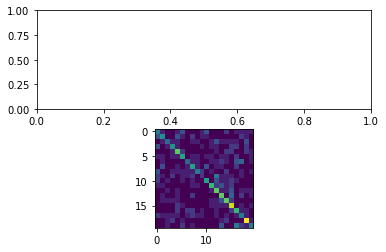

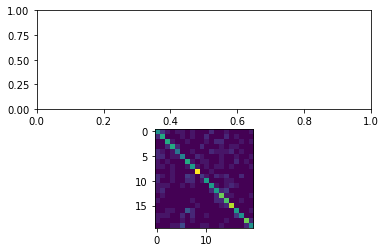

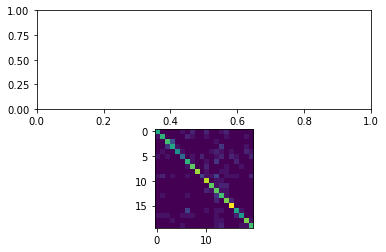

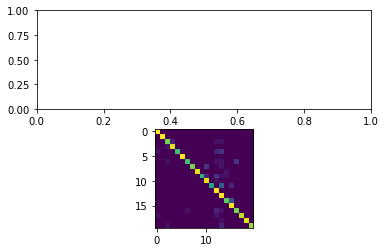

In [41]:
nunits_list = [10, 25, 54, 110]

accu_RS = np.empty(len(nunits_list))
accu_RS.fill(np.nan)

for i in range(len(nunits_list)):
    accu_RS[i] = sim_decode(callhist_RS,nsims,nunits_list[i],LDA=False)

accu_RS

(20, 9, 680)
X: (180, 680)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[ 7.76800806e-02 -1.56414849e-02 -1.51723237e-02 -7.88000631e-03
  -1.14218889e-02  5.32239405e-02  1.96291067e-04 -1.93129630e-02
   3.04371682e-02 -6.13577524e-03 -1.14013787e-02 -1.91519583e-02
  -1.38180715e-02 -7.95576171e-03 -1.63745411e-02  9.60330577e-03
  -1.05128495e-02  2.13149654e-02 -1.87296670e-02 -1.07786008e-02]
 [-1.54822696e-02 -1.27617972e-02 -1.23790113e-02 -6.42925162e-03
  -9.31905315e-03 -1.45887879e-02 -9.74019891e-03  1.11047254e-01
   4.32688663e-02 -5.00614357e-03 -9.30231902e-03 -1.56259721e-02
  -1.12740847e-02 -6.49106002e-03 -1.33598935e-02  5.67159382e-02
  -8.57737321e-03  3.25909048e-02  3.15265478e-02 -8.79419809e-03]
 [-1.89758294e-02  5.25393468e-02  1.60289923e-01  4.62452896e-02
  -1.14218889e-02 -1.78807344e-02 -1.19380658e-02 -1.93129630e-02
  -1.47533872e-02 -6.13577524e-03 -1.14013787e-02 -1.91519583e-02
   1.75028905e-02 -7.95576171e-03 -1.63745411e-02 -2.03519599e-02
  -1.05128495e-02 -1.59451284e-02 -1.87296670e-02  2.08008085e-03]
 [-1.78

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.11111111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11111111 0.         0.11111111 0.11111111
 0.         0.         0.         0.         0.22222222 0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.         0.         0.11111111 0.11111111 0.11111111
 0.         0.         0.11111111 0.11111111 0.         0.
 0.         0.         0.         0.    

[[ 0.30198699 -0.00884463  0.04969043  0.01622898 -0.00847489  0.05401283
   0.03007971  0.00942159 -0.01794342  0.02605343  0.02923352 -0.0244438
   0.03208721 -0.05230492 -0.00513249 -0.01471464 -0.0450644  -0.03243769
  -0.01454531 -0.00637365]
 [ 0.03670204  0.10935702 -0.00063312 -0.0248362   0.0078433  -0.02541383
   0.050206    0.10122402 -0.02828834 -0.02819265 -0.02467729  0.00487928
   0.06917403  0.02329081 -0.02356368 -0.00667551  0.07787454  0.00418004
   0.0443809   0.02380942]
 [ 0.0526815   0.02475292  0.30711214  0.17229541  0.30824361  0.07925711
   0.19024227  0.07059512 -0.02787976 -0.00317295  0.00522789  0.04613819
   0.14306291  0.14388914  0.13392178  0.02785808  0.11953618  0.03663723
   0.10732961  0.12399823]
 [ 0.00772228  0.10555223  0.23975619  0.28672155  0.12206283 -0.00691447
  -0.00229401 -0.02741412 -0.03386483  0.01081319  0.00479741  0.03894091
   0.08281033  0.1749844   0.06561613  0.01374529  0.14030047  0.10508508
   0.31199231  0.13207106]
 [ 0.

 0. 0. 0. 0. 0. 0. 0. 0.]
X_leftout: (20, 680)
y_leftout: (20,)
[0.         0.         0.11111111 0.         0.         0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.11111111
 0.         0.         0.         0.         0.         0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11111111 0.
 0.11111111 0.11111111 0.         0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.         0.11111111 0.
 0.11111111 0.     

[[-9.55073454e-03  7.33859826e-03  9.31545124e-02  1.33294244e-01
   1.36595452e-01  5.09122865e-03  3.68251937e-02  8.41772766e-02
   9.80955847e-02  9.23939998e-02  9.77118654e-03  1.25914656e-01
   6.92768155e-02  4.79445021e-02  5.43588592e-02  7.07289041e-02
   1.18292581e-01  1.21548623e-01  4.74773941e-02  3.06546037e-02]
 [-9.39122906e-03  6.27725087e-01  8.13629733e-03 -6.34444641e-02
  -5.19738744e-02 -1.92317859e-02 -3.75654008e-02 -3.07288693e-02
  -6.45548423e-03  8.37960812e-02 -3.33336016e-02  6.49966724e-02
  -4.99896765e-02 -3.97626736e-03 -4.51424805e-03 -3.81788654e-02
  -3.39656006e-02  7.34833687e-02  3.24176393e-02 -1.74945909e-02]
 [ 5.53312319e-02  1.31333828e-01  8.52508720e-02  7.58557255e-02
  -2.31684762e-03  1.66359598e-01  2.08582271e-01  1.29385565e-01
  -3.29136268e-03  1.05672928e-02  2.91989418e-02  3.23184582e-02
  -3.71357148e-02  5.52393747e-02  1.25689725e-01 -1.67961240e-02
  -1.94547983e-02  2.93717596e-02  1.82052622e-01  4.85331303e-02]
 [-1.49

[[ 0.07614841  0.0086971   0.01285299 -0.00072102 -0.00190695  0.05752581
   0.04709499  0.02710165 -0.02226975  0.05043366  0.13925523 -0.00117444
   0.04412639  0.01880592 -0.03156381  0.09008003  0.08815321 -0.01657632
   0.06218066  0.0154915 ]
 [ 0.07157233  0.0862043   0.1451293   0.07560414  0.13712676  0.05733521
   0.04190883  0.02555884  0.01425796  0.00959278  0.0370084   0.13500658
  -0.0321156   0.02177147  0.07292123  0.0213202   0.02595514  0.12759035
   0.09462137  0.05455044]
 [ 0.04505689 -0.04018837  0.05847924  0.03105766  0.03803318 -0.0181595
  -0.01240282  0.04100946  0.02561205  0.08653449  0.02843253 -0.04597805
   0.03849923  0.01640772  0.01209371 -0.00494468  0.129811    0.00381723
  -0.00464845  0.1092541 ]
 [ 0.00596095 -0.04088937  0.03411858  0.02085291  0.02355057 -0.04165679
  -0.02924906 -0.02747011 -0.03504459 -0.04177869 -0.0164427  -0.02200556
  -0.01986319  0.00049548  0.06102911 -0.00148949 -0.02789604 -0.01161496
  -0.02304055 -0.02358803]
 [ 0.

[[ 1.34360067e-01 -2.75398061e-02  6.01793042e-02  2.93991164e-02
   1.27841827e-01  6.84092474e-02 -3.29602158e-02  8.77351754e-02
   6.33108092e-02  3.93690515e-02  1.43272102e-02  7.73968821e-02
  -2.17156631e-02  1.28780093e-03  2.26691577e-02  4.67756243e-02
   1.10828974e-01  6.31487942e-02  3.80845298e-02  3.71468978e-02]
 [ 9.94108680e-02  2.17981736e-01  1.20549350e-01  9.67243502e-02
   9.24365546e-02  7.46336388e-02  5.51374182e-02  2.49524305e-02
   8.65987992e-02  5.86111594e-02  1.15095424e-01  3.61349015e-02
   4.94658080e-03  9.93840884e-02  5.57310861e-02  8.36176229e-03
   1.05412792e-01  6.55007295e-02  7.80969388e-02  7.54188946e-02]
 [ 1.65569187e-01  2.01296763e-01  7.94458727e-02  8.79472352e-02
   3.83511781e-02  1.67081108e-02  1.52751107e-01  9.53493633e-02
   5.43998378e-02  1.25778282e-01  1.46880747e-01  1.52242978e-01
   8.87873434e-02  4.33115141e-02  9.58994654e-02  2.18535987e-02
   1.20526495e-01  8.95482717e-02  1.06151805e-01  8.53768953e-02]
 [ 9.86

[[ 3.07285623e-02  5.64379570e-02  3.77946093e-02  1.15804831e-01
   6.34686597e-02  9.70442398e-02 -2.93688015e-02  1.29586969e-02
   4.55476237e-02  1.47016158e-01 -8.51211168e-03 -1.28391671e-03
  -3.86386021e-02  2.22305815e-02  3.14853610e-02  9.41483068e-02
   8.41843874e-04  2.08068465e-02 -3.68519853e-02  7.28303611e-02]
 [ 2.05466559e-01  1.94066065e-02  3.44058987e-02  2.48016604e-02
  -2.46101942e-04  1.19861924e-01  7.25220531e-02  4.48788885e-02
   9.40529489e-02  1.07089964e-01 -2.19075275e-02  9.14089871e-02
   1.13975303e-01 -4.52272451e-03  1.51741204e-03  1.19642376e-01
   4.55591982e-02  3.39982457e-02  4.30113524e-02  1.47921306e-02]
 [ 5.60131687e-03  3.63066314e-02  8.67096533e-02  8.07346797e-02
   4.62264796e-02 -2.63152339e-02  2.23022868e-02  5.12531624e-02
   8.47375172e-02  3.79286758e-03  4.42728748e-03 -5.46982359e-02
  -4.41024723e-02  7.86036917e-02  2.23590378e-02 -6.01765126e-03
   5.14712034e-02  2.27261553e-02 -3.75012702e-03  3.64921439e-02]
 [ 5.91

(20, 9, 680)
X: (180, 680)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

X_leftout: (20, 680)
y_leftout: (20,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.11111111
 0.11111111 0.22222222 0.44444444 0.33333333 0.22222222 0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.         0.         0.         0.         0.22222222
 0.11111111 0.11111111 0.         0.         0.         0.
 0.         0.11111111 0.11111111 0.         0.      

(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.         0.         0.11111111 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.08586226]
 [0.08586226 1.        ]]
[[ 8.58622569e-02  1.07406099e-01  7.98428652e-02  6.10648367e-02
   4.00397993e-02  8.82445803e-02  8.75809342e-02  7.87554883e-02
   5.78317895e-02  4.25009165e-03  9.94226669e-02  7.38856483e-02
   

[[ 9.74344103e-02  9.34614926e-02  1.03543845e-02  3.66201844e-02
   7.50843249e-02  3.98750252e-02  4.02894110e-03  2.96631224e-03
   4.67949710e-02  6.48188152e-02  3.94222420e-02  4.09375034e-02
   4.07620360e-02  5.16382127e-03  7.99355791e-02  1.01341982e-02
   6.17290502e-02  8.13396296e-02 -6.51085073e-03 -6.68220431e-03]
 [ 8.51281068e-02  3.69623591e-02  3.09365212e-02  1.44147796e-02
   6.93485253e-02  1.70964676e-02 -7.00410510e-03  3.60914474e-02
   1.17545415e-01  1.50967397e-04  5.82185035e-03  3.69122680e-02
   1.69548264e-02  2.01861154e-02 -1.19633610e-02  1.92490861e-02
  -9.19313230e-03  7.14212447e-02 -5.28817394e-03  1.75622520e-02]
 [ 2.56177155e-02  2.51203305e-02  1.96503009e-01  1.99757554e-02
   1.33527782e-02  8.17718800e-02  7.73391249e-02  5.36603218e-02
   2.65369377e-02  3.89087729e-02  6.18046913e-04  6.10145622e-02
   8.79989396e-03  1.95679893e-02  4.40407708e-02  1.58840071e-02
   4.12683180e-02  6.00095982e-02 -5.84965490e-03  4.24796120e-02]
 [ 8.21

[[1.         0.00727382]
 [0.00727382 1.        ]]
[[1.         0.05081055]
 [0.05081055 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.43786106]
 [0.43786106 1.        ]]
[[ 4.37861056e-01  5.48092802e-02 -4.07207554e-03 -8.92748157e-03
   1.41944862e-02  2.10271210e-01

[[1.         0.02799659]
 [0.02799659 1.        ]]
[[1.         0.05234418]
 [0.05234418 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 1700)
X: (180, 1700)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.47337746]
 [0.47337746 1.        ]]
[[ 4.73377462e-01  2.34186011e-01  6.97218144e-02  8.07402527e-02
   1.99989466e-01  3.30309410e-01

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.11111111 0.         0.11111111 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.00733775]
 [0.00733775 1.        ]]
[[ 7.33774745e-03 -2.34108117e-02 -1.69948178e-02 -2.87558739e-02
   7.36912501e-03  2.94910463e-02  1.27266808e-02 -1.38372961e-02
   7.29406325e-03  4.17986122e-02  3.55906745e-03  5.05984553e-02
  -2.83550218e-03 -3.80257962e-03  1.25906200e-02  2.72803425e-02
   3.30449864e-02 -4.96288919e-03 -1.64059626e-02  2.15786535e-02]
 [ 2.60291816e-02  6.59595990e-02  6.93081561e-02  1.51376306e-01
   2.08124435e-02  5.97671041e-02  7.80838147e-02  2.13018699e-01
   2.12243401e-01  2.18373587e-02  1.50903400e-01  5.46551880e-02
  -9.04255330e-03  2.88972266e-02  1.51583944e-01  8.04430142e-02
   5.01314198e-02  1.59700867e-01  5.88604167e-02  4.24327492e-02]
 [ 2.27444957e-02 -9.34445197e-03  3.20712941e-01  2.13571069e-01
   1.16991166e-01  4.135

[[ 4.41206265e-01  3.62163598e-01  4.89326281e-02  3.27597571e-03
   7.38506294e-02  2.68290904e-01  1.07406870e-01  1.08919244e-01
   1.45763017e-01  1.12080977e-01  7.78648561e-02  1.36719295e-01
   1.46405354e-01  1.20698184e-01  1.33952283e-01  5.30047456e-02
   6.15583230e-02  7.94590461e-02  1.04521519e-01  1.24436399e-01]
 [ 2.28856021e-01  2.56204670e-01  7.76826380e-03 -9.86236809e-04
   6.20013081e-02  2.41532927e-01  6.44575423e-02  1.44394821e-01
   1.46889332e-01  8.94958450e-02  1.00719870e-01  1.25438969e-01
   8.39817888e-02  8.33367415e-02  1.17170186e-01  5.23311735e-02
   4.09510129e-02  1.07934910e-01  5.57113884e-02  7.42614324e-02]
 [ 6.48647728e-02  3.43571211e-02  4.19076423e-01  2.38868660e-01
   8.52017911e-06  6.04188159e-03  5.10143045e-03  5.56784526e-02
   1.82783543e-02 -1.30263056e-02  3.53680468e-02  5.00105477e-03
   3.70896772e-02  2.45454221e-02 -1.78800730e-02  2.09070513e-02
   1.85580912e-02 -1.73894577e-02 -2.49783252e-02  1.23042121e-01]
 [ 2.13

[[ 1.12556335e-01 -6.35284888e-04  5.00891527e-02 -2.26174916e-02
   3.13646501e-02  4.73373905e-02  8.28486897e-03  9.75694710e-02
   1.28308374e-02  4.29792286e-03  8.04748314e-02  2.22696531e-02
   6.28041310e-02  2.96749971e-02  2.37446501e-02  5.00559079e-02
  -2.11642016e-02  1.75842359e-02  7.83893310e-02  3.44905457e-02]
 [ 1.87032834e-02  4.60832297e-01  8.32414299e-03 -2.82869665e-02
   7.57045579e-03 -3.97787490e-02 -1.86443048e-02 -8.70414385e-03
  -4.46838482e-03  1.44147556e-03 -8.73743728e-03  2.92634349e-02
  -6.18834460e-03 -4.75775743e-02 -1.53207100e-02 -3.55547346e-02
  -1.11451913e-02 -3.18989839e-04  1.37315328e-02 -4.17192618e-02]
 [ 1.12486344e-02 -7.26173479e-03  5.26031362e-02  1.16224555e-02
   1.31942305e-03  9.27663751e-03  2.55716631e-02  2.34215242e-02
  -1.35439320e-03 -3.51331867e-02  2.77195809e-02  2.31202640e-02
  -5.53338261e-03  6.62717479e-02  1.17207464e-02  3.21046448e-02
   6.52573775e-03  2.11069160e-02 -1.38751268e-02  3.01370630e-04]
 [ 8.16

X_leftout: (20, 1700)
y_leftout: (20,)
[0.11111111 0.         0.11111111 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.04164531]
 [0.04164531 1.        ]]
[[ 4.16453062e-02  3.06526433e-03  1.76772897e-02  2.15820980e-02
   1.20071882e-02  7.97132030e-02  6.01667152e-02 -7.64359699e-03
   1.50769118e-02  8.67690094e-03 -1.09578985e-02  8.51869181e-03
  -1.00858308e-02  1.14737879e-02  8.54671437e-03  1.60381904e-05
   2.16758898e-02 -6.72545287e-03  6.20210123e-03  4.26055957e-03]
 [-1.73842978e-02  3.31690008e-01  1.32660582e-01  1.30944449e-01
   6.59650935e-02  1.58061690e-01  1.19216115e-01  1.37420647e-01
   1.67541294e-02  1.36186889e-01  3.31091407e-02  2.04171651e-01
   3.02644798e-01  2.64207849e-01  2.15537995e-01  2.04499372e-01
   1.38723855e-01  7.41246988e-02  9.85507628e-02  1.14493361e-01]
 [ 2.29854988e-02  7.79347868e-02  1.02610497e-01  7.19324328e-02
   1.94522322e-03  4.48815152e-02  2.18335483e-02  6.34481913e-02
   5.53930660e-02  2

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 1700)
y_leftout: (20,)
[0.         0.         0.         ... 0.11111111 0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.07150969]
 [0.07150969 1.        ]]
[[ 7.15096881e-02 -2.66482390e-03  2.44721980e-02 -4.05924726e-03
  -2.35008402e-02  1.82836286e-02 -8.79081958e-03 -1.10283243e-03
  -1.69240753e-02 -6.47348075e-03 -3.12063217e-04  5.60093104e-03
   1.24997740e-02  1.63932052e-03  4.27540079e-02 -1.49412936e-02
  -3.18436895e-03 -1.84003636e-03 -2.20832153e-02 -2.34871487e-02]
 [ 2.97543941e-02  1.81580550e-01 -6.93023559e-03 -1.83183530e-02
   1.23985943e-03  3.50282503e-02  1.42132545e-02  7.26451513e-02
  -5.22316677e-03 -1.55479691e-02  6.35231272e-02  1.30139086e-01
   1.00161318e-01  5.31536940e-02  7.70783017e-02  2.08842786e-02
   3.26236743e-03 -1.18642373e-02  6.03848267e-02  2.23361739e-02]
 [ 5.45871551e-02  6.18896147e-02  1.43308375e-01  1.16796871e-01
   1.07931236e-01  1.553

[[1.         0.22384633]
 [0.22384633 1.        ]]
[[1.        0.0273972]
 [0.0273972 1.       ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Accu: 0.7
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.       0.338596]
 [0.338596 1.      ]]
[[ 3.38595996e-01  2.45439422e-01  1.46258098e-02  1.45442576e-02
   1.02351490e-01  2.05335711e-01  

[[ 6.54193960e-02  6.83361768e-02  5.38755813e-02  3.04373663e-02
   1.43093468e-02  4.88613543e-02  3.88604327e-02  5.69910652e-02
   4.64664100e-02  2.28615596e-02  5.31754268e-02  4.52790393e-02
   9.89957531e-03  1.74403847e-02  6.25503294e-02  6.47359194e-02
   4.11060884e-02  2.35562293e-02  3.98227079e-02  5.18216995e-02]
 [ 5.20511979e-02  4.52114408e-02  3.73276929e-02  2.66929583e-02
   1.35034807e-02  6.24590155e-02  4.93968810e-02  2.84196539e-02
   2.19350008e-02  5.55594378e-02  6.10496792e-02  9.31525085e-02
   1.75615438e-02  4.97790141e-02  7.68115020e-02  6.53301873e-02
   4.99875223e-02  1.93331755e-02  4.82288916e-02  2.90491021e-02]
 [ 1.09351826e-02  3.75966286e-02  3.39575121e-01  2.19821131e-01
   1.29310317e-01  1.04087417e-01  6.93017620e-02  6.42222184e-02
   2.11847920e-02  4.07321459e-02  3.02711396e-02  1.51136820e-01
   1.51426075e-01  1.72652815e-01  1.36527490e-01  2.31946830e-01
   4.98349679e-02  7.29435891e-02  1.06195285e-01  9.55997656e-02]
 [ 8.50

[[ 3.91045606e-01  1.57053125e-01  1.21385633e-02  4.76398833e-02
   4.87330107e-02  1.67166714e-01  6.54056165e-02  2.11189304e-01
   5.02907549e-02  1.17080300e-01  8.69983677e-02  6.69094436e-02
   9.72184862e-02  8.97348778e-02  1.33857218e-01  1.29589414e-01
   6.96793927e-02  4.51360962e-02  6.54479311e-02  7.09526630e-02]
 [ 1.48920210e-01  1.98300043e-01  5.29871809e-02  7.94689759e-02
   1.51885406e-01  1.64661805e-01  7.32933052e-02  1.37308861e-01
   7.58588916e-02  8.83688793e-02  1.72506925e-01  1.09583553e-01
   1.39528927e-01  1.28040768e-01  1.08367923e-01  8.39292143e-02
   6.24967631e-02  4.81517099e-02  1.03939755e-01  9.11902094e-02]
 [ 2.30712602e-02  2.50076171e-02  3.89306509e-01  1.34541654e-01
   1.12470687e-01  1.63523975e-02  1.82814809e-02  1.48662517e-02
   1.15383379e-02  3.47037638e-02  3.51923654e-02  2.22396913e-02
   2.31018678e-02  3.98491413e-02  2.58756771e-03  7.55670640e-02
  -7.20830502e-03  3.14413593e-02  4.07794645e-02  1.36379766e-01]
 [ 3.56

   2.55046459e-02  6.69179335e-02  1.03194680e-01  1.87716673e-01]]
[[1.         0.29080818]
 [0.29080818 1.        ]]
[[1.         0.29875909]
 [0.29875909 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.         0.         0.         ... 0.         0.11111111 0.11111111]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.28525263]
 [0.28525

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.10359964]
 [0.10359964 1.        ]]
[[ 1.03599643e-01  4.70394941e-02  3.33723492e-02  5.75090209e-02
   2.38440495e-02  3.39324965e-02  2.01468158e-02  7.38635826e-02
   1.83354238e-02  4.33907125e-03  1.15105908e-02  1.68225447e-02
  -1.91237149e-03  2.59369119e-02  4.83855594e-02  5.48811587e-02
   6.32775189e-02  3.07210474e-02  3.38941199e-02  2.74292203e-02]
 [ 5.06524490e-02  6.86611301e-02  2.19532681e-03  2.41028161e-02
   2.06828861e-02  3.46576019e-02  1.67440646e-02  3.25525878e-02
   4.41615871e-02  2.58870480e-02  3.92638435e-02  4.81439759e-02
   2.31675939e-02  2.26807854e-03  3.67100600e-02  1.07899231e-02
   5.02567359e-02  4.03747265e-02  1.06787582e-02  3.05359931e-02]
 [ 2.30953455e-02  4.59318074e-02  2.32801538e-01  1.66362604e-01
   9.64866161e-02  5.01192440e-02  1.09621269e-01  5.24677593e-02
   1.0

[[ 4.27285853e-01  6.50518611e-02  3.06949815e-02  4.86152228e-02
   2.28434242e-02  1.54841049e-01  7.35708638e-02  2.36961942e-01
   6.14476143e-02  1.09840342e-01  1.19350298e-02  3.33418332e-02
   1.98132820e-02  3.13524818e-02  8.88342577e-02  1.45535526e-01
   8.93038987e-02  6.36419439e-02  5.87454695e-02  5.46968940e-02]
 [ 9.44622268e-02  3.75910894e-02  1.57685103e-02  6.39323387e-03
   1.20036369e-02  3.68956222e-02  3.59606016e-02  1.10549572e-01
   9.14965827e-03  1.81889933e-02  5.05813450e-02  7.15746129e-03
   1.16332304e-02  9.25122556e-03  2.62610280e-02  4.53405659e-03
   5.46893047e-02  1.59041129e-02  9.71631438e-02  5.63736352e-02]
 [ 1.93411391e-02  1.80245872e-02  1.75235832e-01  1.38181353e-01
   5.05209691e-02  1.77002556e-02  2.63143285e-02  3.56454201e-03
   1.43489908e-02  2.89466621e-02  1.32237469e-02  1.70164730e-02
   6.38946663e-02  4.83649945e-02  4.26936492e-02  2.13106062e-02
   3.89849893e-02  4.00986123e-02  6.59041300e-02  6.95357483e-02]
 [ 4.16

[[ 1.21164497e-01  2.51741354e-02 -2.04453106e-03  1.59130411e-02
   4.01047384e-03 -5.85621138e-03  1.71382197e-02  1.30427976e-02
   2.65272568e-02  3.65858712e-02  8.59898637e-03  2.27042490e-02
   8.16754438e-03  1.54730099e-02  2.20143546e-03  1.26261221e-02
   1.12552806e-02  4.04395292e-03 -1.30620806e-02  1.46419258e-02]
 [ 5.86257113e-02  7.32192054e-02  1.48834547e-02 -2.56075431e-03
   6.97544716e-03  2.93442550e-02  7.80369165e-02  4.83030808e-02
   1.46734164e-03  1.93136489e-03  2.58012930e-02  9.67338064e-02
   5.04252165e-02  6.59090064e-02  1.99174452e-02  1.45154497e-02
   3.54511310e-02  2.90179560e-02  7.80569587e-02  7.18854669e-02]
 [ 2.33316946e-03  2.99993848e-02  2.26033585e-01  2.46167373e-02
   9.83676554e-02  2.35812980e-02 -1.98354070e-03  1.57746944e-03
   4.21089206e-02  1.02310160e-02  2.87944632e-02  2.17409132e-02
   7.09219872e-03  3.08983650e-02  2.88481541e-02  1.89655374e-02
   1.16426966e-02  3.40350089e-02  2.16681894e-02  6.83436676e-02]
 [ 1.11

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.1403496]
 [0.1403496 1.       ]]
[[ 1.40349602e-01  4.71780776e-02  3.99173652e-02  2.07965266e-02
   2.34765888e-02  5.48325968e-02  5.30812037e-02  4.20417768e-02
   2.20489056e-02 -2.69820121e-03  2.11543554e-02  1.38934981e-02
   1.19110684e-02  1.84406602e-02  3.20424799e-02  2.40752883e-02
   2.95521852e-04  3.36385461e-02  6.63494066e-03  6.10594096e-03]
 [ 5.48164704e-02  3.71450672e-01 -4.94856830e-03  7.30048941e-03
   4.50397644e-04  6.61298508e-02  3.38188719e-02  1.21314811e-02
   1.80542171e-03  9.68182618e-03  7.46266969e-03 -1.02940229e-02
   2.99568561e-02  1.47879897e-02  3.03331303e-02  2.02637748e-03
   2.50845926e-02  3.98984619e-02  5.41295797e-02  2.61043656e-02]
 [ 3.40158213e-02  1.65664773e-02  3.76067704e-01  8.55537804e-02
   2.84873256e-02  7.59947103e-02  2.98022212e-02  2.48481071e-02
   1.92875

[[1.         0.12331373]
 [0.12331373 1.        ]]
[[1.         0.10846611]
 [0.10846611 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 3672)
X: (180, 3672)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0.         0.         0.         ... 0.         0.         0.11111111]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.34853191]
 [0.34853191 1.        ]]
[[ 3.48531912e-01  5.61474270e-02 -1.27874602e-02  

[[ 5.52729026e-02  2.06110845e-02  1.28692451e-02  5.58892345e-02
   4.86735428e-02  4.19717837e-02  1.31320299e-02  6.68930201e-02
   2.64141653e-02  8.56991963e-03  2.39569089e-02  7.28638133e-02
  -1.12790758e-02  2.65471023e-02  2.30479347e-02  1.63511945e-02
   9.24182943e-03 -8.71245643e-03  4.54658337e-02  1.47355752e-02]
 [-1.30459807e-02  4.18865520e-01  1.94648614e-02  3.88185630e-02
  -1.01369292e-02 -5.01342990e-04  7.80825092e-04  9.42163823e-03
   3.63018900e-03  2.49165206e-02 -6.68034058e-03  8.58454652e-04
   1.72196245e-02  2.54462027e-03  1.80354944e-02 -1.60132085e-02
   4.05629431e-03  4.21043285e-02  1.69505696e-02  1.74228573e-02]
 [ 3.05832959e-02 -1.49969546e-02  1.99621249e-01  1.23178651e-01
   6.03978663e-02  3.21007546e-02  6.31797848e-02  2.65486701e-02
   7.96470278e-03  6.33348083e-03  6.92868334e-02  5.31087854e-02
   4.70805792e-02  2.33195382e-02  4.03973331e-02  5.18384998e-02
   2.15388224e-02  2.98742325e-02  5.76989765e-02  6.33564917e-02]
 [ 2.63

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 3672)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.29780571]
 [0.29780571 1.        ]]
[[ 2.97805715e-01  2.46737775e-01 -8.32260855e-03  1.47735660e-02
   4.03628494e-02  1.94806847e-01  2.00342695e-02  1.12557226e-01
   5.63350358e-02  4.03929501e-02  3.52357804e-02  4.93419421e-02
   2.58094328e-02  1.50522054e-02  4.67231139e-02  1.25222793e-02
   1.71015735e-02  5.64351951e-02  5.40581863e-02  4.37429985e-02]
 [ 1.47940046e-01  1.69111707e-01  5.47945171e-02  7.23303411e-02
   7.28569409e-02  1.71788935e-01  1.14003284e-01  1.65692100e-01
   1.58496238e-01  4.60226795e-02  1.15308675e-01  5.11271710e-02
   1.76305888e-02  1.04240121e-01  9.40426222e-02  7.13014652e-02
   1.02605205e-01  1.05464047e-01  7.14381322e-02  6.63163076e-02]
 [ 6.76498158e-02  3.79443836e-02  3.13757671e-01  1.89106442e-01
   6.91345781e-02  8.41045443e-02  6.84517621e-02  1.05737642e-01
   8.0

X: (180, 7480)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0.22222222 0.         0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.22830068]
 [0.22830068 1.        ]]
[[0.22830068 0.09243819 0.02302934 0.00529504 0.08749585 0.12821138
  0.00754707 0.09333903 0.04018324 0.01896827 0.03376981 0.01808029
  0.02778961 0.01973361 0.02640955 0.01209167 0.03091365 0.04000602
  0.0223706

[[ 0.15159603  0.03573451  0.01305855  0.01820931  0.02220179  0.05320762
   0.02107152  0.0641262   0.04034269  0.02063016  0.03515468  0.0428367
   0.02602794  0.01816607  0.0419984   0.020656    0.03873223  0.03852008
   0.01521075  0.01400912]
 [ 0.04643272  0.22279782  0.05323268  0.05783398  0.06516958  0.07547303
   0.05138299  0.08074413  0.0029668   0.05844711  0.06295465  0.10952935
   0.19173644  0.17217447  0.09058602  0.11180467  0.07919332  0.06329541
   0.0489408   0.05482049]
 [ 0.04991043  0.03587804  0.29405969  0.10855585  0.04642376  0.0469501
   0.03224567  0.043469    0.0264738   0.03575869  0.05548825  0.06650396
   0.06810684  0.07245233  0.05560084  0.0674157   0.05409418  0.00955988
   0.0382486   0.09251543]
 [ 0.03277347  0.01077256  0.15485783  0.38426967  0.09449989  0.07170936
   0.07066683  0.07539533  0.04393601  0.05380806  0.12042629  0.18202941
   0.22014942  0.23067647  0.06213361  0.16279771  0.13800261  0.02013442
   0.06559095  0.08743571]
 [ 0.0

[[ 0.12706143  0.02739166  0.01311756  0.00910621  0.02712235  0.03066578
   0.02783293  0.03761857  0.00381517  0.0196582   0.02860701  0.03251509
   0.02555686  0.01036379  0.01382712  0.01938453  0.01942925  0.0172434
   0.03452763  0.02334056]
 [ 0.07008817  0.22375144  0.03146331  0.04468152 -0.00197577  0.02642304
   0.04178129  0.02391674  0.0247805   0.04006385  0.06234948  0.01313718
   0.02229377  0.01199611  0.02124078  0.00712778  0.02527066  0.03657738
   0.04300912  0.03175674]
 [ 0.06866693  0.03104181  0.2793806   0.14408046  0.02372785  0.04004192
   0.03790072  0.02999826  0.0268352   0.01740562  0.05712561  0.07382694
   0.03909644  0.06874759  0.04569596  0.07471603  0.03897559  0.0413371
   0.05941246  0.06833772]
 [ 0.0822108   0.014678    0.12978917  0.41015292  0.02948646  0.03582433
   0.02261487  0.02454603  0.07581322  0.03344507  0.03864695  0.03122391
   0.0281862   0.02888522  0.03674321  0.03721362  0.03647493  0.04332488
   0.07622302  0.08218071]
 [ 0.0

[[1.         0.10770952]
 [0.10770952 1.        ]]
[[1.         0.26739787]
 [0.26739787 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 7480)
X: (180, 7480)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0.11111111 0.         0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.2965495]
 [0.2965495 1.       ]]
[[ 0.2965495   0.06793412  0.01079671  0.03093419  0.03

[[ 3.06022549e-01  2.22348823e-02  1.17303107e-02  3.39795683e-03
   5.84034966e-02  1.08515094e-01  1.49681901e-02  9.74113028e-02
   1.13879988e-02  2.05167995e-02  1.76420022e-03 -1.04865511e-04
   6.24803687e-03  1.35600017e-02  2.28020746e-02  3.68665727e-02
   1.98326776e-03  3.56033859e-02  4.95184848e-02  2.20228834e-02]
 [ 2.24283504e-02  2.47716942e-01  4.43001239e-02  4.12042703e-02
   2.10964893e-02  4.16599227e-02  3.08000903e-02  4.98761152e-02
   6.01812959e-02  3.00836457e-02  1.07108887e-01  3.00900091e-02
   1.27519328e-02  2.18283893e-02  6.11251178e-02  1.78587010e-02
   2.63265870e-02  5.71518102e-02  3.90668512e-02  2.41790956e-02]
 [ 7.76449490e-03 -1.31797166e-02  3.45642297e-01  1.46210949e-01
   6.25889057e-02  1.30044108e-02  5.98067139e-02  1.20430124e-02
   4.79414773e-02  6.65395948e-02  8.48773938e-02  6.39988296e-02
   1.48145086e-01  8.30684125e-02  9.06756941e-02  1.15089515e-01
   2.33547960e-02  2.71017796e-02  3.76136376e-02  6.78891455e-02]
 [ 2.15

[[ 0.27295103  0.23139377  0.02121048  0.03116512  0.0754565   0.14983554
   0.03464253  0.1025484   0.06807163  0.06446602  0.06859414  0.04723278
   0.04302853  0.02496324  0.06445082  0.04304681  0.03463851  0.08220504
   0.04915257  0.03786617]
 [ 0.12690244  0.20687415  0.03782579  0.04173536  0.07663769  0.11315759
   0.05381625  0.06786117  0.05482715  0.0425527   0.04798838  0.07832754
   0.07794927  0.06902045  0.05088629  0.04258955  0.04359406  0.06030303
   0.05415675  0.02328203]
 [ 0.0249195   0.02908288  0.24827968  0.14573739  0.03133773  0.03708
   0.02901257  0.01620069  0.03265858  0.00808615  0.04865965  0.02625515
   0.03696551  0.02734341  0.01968477  0.02250093  0.01142443  0.04239282
   0.03334114  0.05022517]
 [ 0.02029366  0.04110242  0.12545396  0.37244199  0.04808602  0.04276905
   0.03881963  0.01594665  0.053191    0.0105763   0.03777651  0.05813012
   0.07442612  0.04143596  0.03513307  0.03336455  0.04061214  0.03455198
   0.0391839   0.06174143]
 [ 0.06

[[ 0.10103498  0.02112182 -0.00311758  0.00222495  0.00481291  0.04746036
  -0.00456786  0.03217943  0.00342183 -0.00455438  0.0132444   0.01117794
  -0.01093315  0.01032468  0.00947729 -0.00551463  0.03155378  0.02309633
  -0.00522975 -0.00489821]
 [ 0.02444475  0.06048171  0.03389402  0.06064189  0.06596284  0.09255223
   0.03207265  0.05911604  0.01771726  0.04212079  0.04553252  0.08754963
   0.13508852  0.11027108  0.07674106  0.09127207  0.04195489  0.03551687
   0.0430181   0.03637648]
 [ 0.00904417  0.02068889  0.2220983   0.12151379  0.01072114  0.0446496
   0.07852452  0.01753142  0.02724356  0.00951193  0.02978293  0.04657407
   0.04247889  0.04707825  0.01517241  0.07923996  0.09516809  0.01105288
   0.04712843  0.06607103]
 [ 0.03926368  0.035675    0.14078448  0.33871456  0.08956125  0.06689942
   0.04187207  0.0647405   0.03125331  0.04981511  0.1012558   0.16230511
   0.18730418  0.17454609  0.08800578  0.17993696  0.08700548  0.02310801
   0.04703086  0.06400052]
 [ 0.

[[ 0.07980793  0.04676777  0.00788782  0.01809626  0.08470783  0.02961111
   0.02459257  0.02799736  0.02066334  0.01075496  0.03067726  0.02494097
   0.02307602  0.0298354   0.0670644   0.03952741  0.01988944  0.03698768
   0.00651621  0.02685044]
 [ 0.04550059  0.13655857  0.00167869  0.00998459  0.00789483  0.0394307
   0.03182853  0.03181862  0.01118369  0.04170943  0.04858397  0.02289998
   0.03944382  0.00794391  0.02849084  0.02565871  0.00097277  0.0258645
   0.0267068   0.00628051]
 [ 0.05450913  0.01588924  0.27332161  0.11549195  0.04861492  0.05790948
   0.01231013  0.02618078  0.01172487  0.00597807  0.00508695  0.01045456
   0.02609096  0.0103239   0.02733656  0.04608935  0.00614311  0.00807528
   0.0081808   0.037859  ]
 [ 0.02587949  0.00707516  0.13607422  0.35534413  0.04369215  0.03261932
   0.01570064  0.02360771  0.04027241  0.00600144  0.01156673  0.0127479
   0.02740469  0.02447566  0.03015554  0.02811886  0.04393918  0.03018104
   0.02133679  0.0312702 ]
 [ 0.03

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 7480)
y_leftout: (20,)
[0.         0.         0.         ... 0.         0.         0.11111111]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.32430509]
 [0.32430509 1.        ]]
[[ 0.32430509  0.18648233  0.03691461  0.03399537  0.06954325  0.19171592
   0.05701738  0.12094641  0.04498313  0.04465407  0.09337472  0.0541776
   0.03744169  0.01114564  0.03932104  0.03933516  0.05459784  0.05217862
   0.06468

[[1.         0.16059907]
 [0.16059907 1.        ]]
[[1.         0.22854717]
 [0.22854717 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0.22222222 0.         0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.24870059]
 [0.24870059 1.        ]]
[[ 2.48700585e-01  1.31632613e-01  4.79714624e-0

[[0.25846208 0.12796297 0.02882779 0.02835486 0.05137466 0.15689583
  0.01684499 0.06590408 0.04066851 0.03213279 0.01914828 0.01624884
  0.02753491 0.0066937  0.05551511 0.03375683 0.02036045 0.02643504
  0.04276645 0.03870416]
 [0.13554907 0.3056149  0.03165725 0.01353365 0.05084025 0.11260585
  0.03404744 0.04824182 0.04393143 0.0419153  0.06998418 0.04169418
  0.01178875 0.01491203 0.03382875 0.01761445 0.03267292 0.04957937
  0.07622057 0.04497243]
 [0.02253728 0.04421125 0.31549408 0.14600182 0.04684964 0.04018439
  0.0243761  0.02057041 0.00401396 0.01690323 0.04198969 0.00949449
  0.01958408 0.02505382 0.01372762 0.0385167  0.03093637 0.03886325
  0.02046359 0.04882745]
 [0.0383801  0.02468618 0.17865709 0.31993303 0.10064304 0.02249881
  0.04135309 0.04025072 0.07641452 0.09117853 0.09804977 0.09441978
  0.14564886 0.10540547 0.09166433 0.1077661  0.05322266 0.03581614
  0.07027872 0.06998893]
 [0.03203429 0.04433269 0.062227   0.07328741 0.25247617 0.0484947
  0.03900737 0.04

[[1.         0.13239678]
 [0.13239678 1.        ]]
[[1.         0.22324538]
 [0.22324538 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.11111111 ... 0.         0.         0.        ]
(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.22892681]
 [0.22892681 1.        ]]
[[0.22892681 0.03257422 0.03711934 0.03469864 0.

(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.24588347]
 [0.24588347 1.        ]]
[[0.24588347 0.08891629 0.02816277 0.03282273 0.06252429 0.13126948
  0.01686421 0.11246158 0.06041284 0.03085666 0.03792581 0.02473751
  0.0188371  0.02108223 0.05996543 0.04298544 0.02528774 0.03574896
  0.04570905 0.04250399]
 [0.09164467 0.20

(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0.         0.22222222 0.         ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.18891501]
 [0.18891501 1.        ]]
[[0.18891501 0.11723061 0.02943614 0.03767967 0.06166862 0.10283689
  0.059065   0.09247334 0.037015   0.03898866 0.06462686 0.05442747
  0.02623827 0.01213099 0.03400115 0.02410928 0.04746343 0.054

[[0.26397967 0.12237642 0.02730341 0.03341984 0.08033604 0.14946259
  0.01604148 0.13665523 0.07273083 0.05839535 0.11537033 0.05142121
  0.05432092 0.06309407 0.05254001 0.05326894 0.06564852 0.0593714
  0.04239877 0.04458912]
 [0.13164162 0.27586341 0.021712   0.02546294 0.06184694 0.10871339
  0.03697295 0.04089393 0.0337084  0.03334267 0.03618241 0.04202669
  0.03042924 0.03103944 0.05244657 0.01777299 0.02903776 0.05147783
  0.04755545 0.03769782]
 [0.03420114 0.0266794  0.23979138 0.17322925 0.05036182 0.02220554
  0.03463124 0.02653499 0.01964507 0.0444267  0.0486381  0.05090272
  0.06768585 0.057337   0.04582333 0.07013327 0.04658768 0.02944498
  0.044561   0.07144844]
 [0.01989705 0.01646328 0.1678877  0.36456746 0.08595365 0.05402087
  0.03459772 0.01623127 0.0424802  0.03304164 0.03991793 0.09464014
  0.10360396 0.1303871  0.05223378 0.10124074 0.06694045 0.03283724
  0.03240485 0.07832446]
 [0.06709528 0.05794786 0.07576444 0.08538736 0.30412359 0.10163416
  0.04295035 0.05

[[ 0.23895838  0.11614754  0.02304196  0.03168152  0.04032983  0.15592349
   0.03167866  0.0895831   0.02153444  0.03629011  0.05463786  0.02578482
   0.04328979  0.0293183   0.05391799  0.04186327  0.03263277  0.03407319
   0.05101067  0.03556911]
 [ 0.07984701  0.22633867  0.01769928  0.02075757  0.04943605  0.11547284
   0.0365544   0.05488389  0.03979799  0.04440571  0.05104026  0.0490159
   0.04945547  0.0372602   0.03226932  0.01870383  0.03248215  0.04961946
   0.06068008  0.04224312]
 [ 0.03090283  0.03976578  0.24945825  0.14397846  0.06891177  0.03827359
   0.03005363  0.0326049   0.03541087  0.02234383  0.03740596  0.07969467
   0.08412014  0.08955352  0.0573454   0.09920758  0.03321977  0.0451405
   0.03509748  0.05395197]
 [ 0.04481705  0.02259312  0.13021496  0.29036358  0.04294322  0.0309676
   0.0307289   0.01221741  0.01868727  0.04104794  0.01894746  0.01685138
   0.02441257  0.02958472  0.01393719  0.03644668  0.04305859  0.03065224
   0.05760358  0.05119922]
 [ 0.05

[[0.1376204  0.08325821 0.00904089 0.03251554 0.02361094 0.05270111
  0.0218186  0.02727768 0.03082038 0.03934925 0.03013694 0.03203402
  0.02270097 0.02419766 0.01246249 0.012656   0.01281913 0.02009265
  0.03909942 0.0161006 ]
 [0.07746594 0.21397274 0.01329    0.019166   0.03269157 0.05971251
  0.02710173 0.02845499 0.03388878 0.02167661 0.03535695 0.035012
  0.02676863 0.01563566 0.02618665 0.00948445 0.01838815 0.03680763
  0.01435283 0.01988297]
 [0.03653058 0.02042237 0.29771541 0.15164157 0.08442686 0.02787702
  0.06214603 0.03338819 0.04225482 0.07098326 0.06546499 0.08349012
  0.13765222 0.10515736 0.08204645 0.12111844 0.0338797  0.03038697
  0.05984243 0.06107271]
 [0.05652436 0.05535784 0.17021598 0.35695445 0.08315714 0.05470505
  0.02710185 0.06899843 0.07803039 0.08397704 0.07496229 0.07497642
  0.10162254 0.11380427 0.08100908 0.08005115 0.05786936 0.06486198
  0.0826258  0.10140174]
 [0.05769583 0.04776841 0.07203313 0.06594811 0.25563546 0.04640308
  0.02477854 0.028

[[1.         0.27540942]
 [0.27540942 1.        ]]
[[1.        0.2521264]
 [0.2521264 1.       ]]
[0. 0. 0. ... 0. 0. 0.]
[0.         0.11111111 0.         ... 0.11111111 0.         0.        ]
(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0.         0.         0.         ... 0.11111111 0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.23496069]
 [0.23496069 1.        ]]
[[ 0

   0.10044721  0.35559829]]
[[1.         0.20515324]
 [0.20515324 1.        ]]
[[1.         0.22711702]
 [0.22711702 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
(20, 9, 10880)
X: (180, 10880)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 1. 1. 0.]
X_leftout: (20, 10880)
y_leftout: (20,)
[0.         0.         0.         ... 0.11111111 0.11111111 0.        ]
[0. 0. 0. ... 0. 0. 0.]
[[1.       0.161588]
 [0.161588 1.      ]]
[[0.161588   0.1094509  0.03

Accu: 0.9925


array([0.4525, 0.7   , 0.8925, 0.955 , 0.9925])

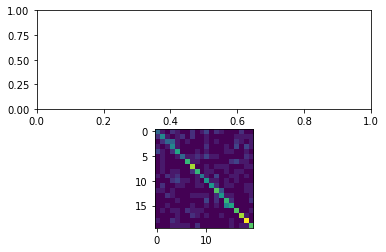

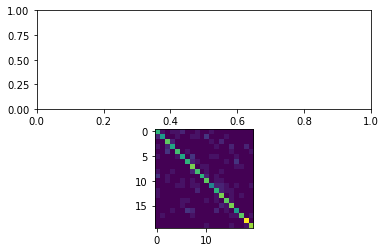

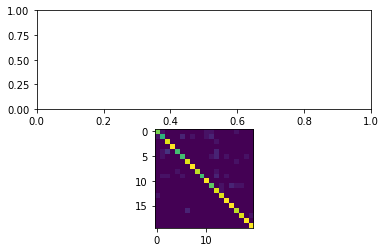

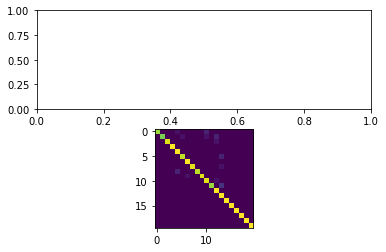

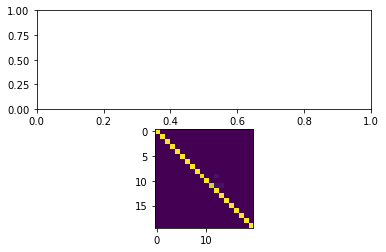

In [42]:
callhist_mixed = callhist_all[:,:,:, (callhist_type_all=='Burster_h') | (callhist_type_all=='Burster_l') | (callhist_type_all=='RS')]

nunits_list = [10, 25, 54, 110, 160]

accu_mixed = np.empty(len(nunits_list))
accu_mixed.fill(np.nan)

for i in range(len(nunits_list)):
    accu_mixed[i] = sim_decode(callhist_mixed,nsims,nunits_list[i],LDA=False)

accu_mixed

(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.35294118 0.         0.         0.
 0.01470588 0.         0.04411765 0.        ]
X_leftout: (20, 10)
y_leftout: (20,)
[0.         0.00816993 0.18627451 0.00490196 0.02614379 0.00653595
 0.00163399 0.00163399 0.00816993 0.00490196]
[0.         0.         0.23529412 0.         0.         0.02941176
 0.         0.         0.         0.        ]
[[1.         0.98367653]
 [0.98367653 1.       

[[1.         0.91902493]
 [0.91902493 1.        ]]
[[1.         0.55246668]
 [0.55246668 1.        ]]
[0.         0.         0.07352941 0.05882353 0.         0.05882353
 0.         0.         0.         0.        ]
[0.00490196 0.00816993 0.03104575 0.01960784 0.00653595 0.01633987
 0.00163399 0.00163399 0.00980392 0.00163399]
(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.01470588 0.         0.         0.         0.02941176 0.
 0.         0.         0.044

[[ 0.40968789  0.84279962  0.82539834  0.63590385  0.45957136  0.65798926
   0.83019164  0.19666129  0.82308518  0.49936913  0.8454838   0.80284824
   0.58751758  0.73531712  0.55514983  0.72245094  0.40697124  0.38781567
   0.71606136  0.67434258]
 [ 0.19044491  0.90892605  0.74179955  0.76580681  0.39595748  0.71153846
   0.81117487  0.11972903  0.80676485  0.52176578  0.90346509  0.93967139
   0.83608408  0.94553898  0.59217917  0.87177331  0.65835358  0.41133593
   0.89878223  0.85810941]
 [ 0.14570914  0.76819441  0.74534588  0.56130962  0.6149426   0.80838353
   0.75253461 -0.0938363   0.45032593  0.50151858  0.63070184  0.63146216
   0.47772515  0.49965341  0.34223336  0.56953314  0.460196    0.11313562
   0.60393661  0.62356146]
 [-0.00802986  0.79146745  0.57954469  0.76626728  0.18350144  0.5777238
   0.65843683 -0.01802935  0.67137222  0.50768254  0.87526818  0.8967568
   0.85335801  0.93030051  0.45709988  0.876288    0.68735641  0.34753088
   0.85399798  0.81338839]
 [-0.0

y_leftout: (20,)
[0.00490196 0.00163399 0.00816993 0.03594771 0.02941176 0.00490196
 0.01960784 0.00980392 0.01797386 0.        ]
[0.         0.         0.         0.01470588 0.04411765 0.
 0.05882353 0.         0.02941176 0.        ]
[[1.         0.65202442]
 [0.65202442 1.        ]]
[[ 0.65202442  0.46855656 -0.01787282  0.2044937   0.75555462  0.68371216
   0.01131616 -0.23923913 -0.01637365  0.20312266  0.51818773  0.03946685
   0.35260757  0.33929311  0.15018209  0.16277075 -0.0312356   0.16826607
  -0.17268636  0.4276896 ]
 [-0.09677686  0.17503481 -0.3213478  -0.07771957  0.37133133  0.19660827
  -0.17534046 -0.35831927 -0.00957376  0.248138    0.07835874 -0.17307359
   0.21366868  0.06812066 -0.15053532 -0.17215103 -0.20089984 -0.31624094
  -0.10445239  0.01630907]
 [ 0.61708438  0.73538515  0.87582125  0.98161827  0.20156489  0.55055545
   0.80495164  0.72632009  0.52979851  0.75056501  0.82267078  0.60004545
   0.66231085  0.9125052   0.96045082  0.89657679  0.53618968  0.428

[[-0.24984367 -0.2920038  -0.21362909 -0.41393497 -0.21092748 -0.27158832
  -0.26961676 -0.25074113 -0.45556587 -0.46227023 -0.21301509 -0.20252791
  -0.24533385 -0.36299288 -0.49106211  0.23621297 -0.40555987 -0.43725468
  -0.1840373  -0.21426691]
 [-0.20345919  0.69756462 -0.28997102  0.3165883   0.48216325  0.49049147
  -0.14839372 -0.40861517  0.04178029  0.11759506  0.36798638  0.62568406
   0.84345088  0.71077048  0.20412011  0.33756676  0.29117119 -0.02896925
   0.77535513  0.75018533]
 [ 0.65893791  0.18052987  0.49083732  0.35852408 -0.11800548  0.41820319
   0.56635179  0.90085221  0.66413579  0.43398135  0.38689046  0.25231025
  -0.31005965  0.03959622  0.30071052  0.12874801  0.22164011  0.62461456
  -0.22402988 -0.20243689]
 [ 0.01841323  0.64014191  0.17619478  0.66687285 -0.2186718   0.47687709
   0.40450603  0.09229067  0.35520267  0.23120659 -0.03020791  0.45463463
   0.62787871  0.54853923  0.19285681  0.18717187  0.61380226  0.1286801
   0.71146669  0.72881812]
 [ 0.

[[ 0.47706775 -0.06172073 -0.32263323 -0.3199201   0.46099605 -0.1186364
   0.32510018  0.24244603  0.19312889  0.2444766   0.34672254  0.19674062
   0.08588597  0.34589645  0.05806276 -0.08060035  0.34902893  0.50124931
  -0.17359478  0.35761178]
 [ 0.0229271   0.29313011  0.61585366 -0.06807534 -0.10672849  0.4489909
  -0.02056828 -0.05560972  0.07152684 -0.01011197  0.05758893 -0.01809752
   0.18695327 -0.09822811  0.06893934  0.51891826 -0.02985161 -0.06596954
   0.1855149  -0.13356398]
 [ 0.05383039  0.82086763  0.52075997  0.27019499  0.10611599  0.48804766
   0.61218597  0.51533892  0.63326403  0.60541671  0.69698922  0.54479616
   0.72825202  0.64975334  0.68622844  0.76285012  0.56070724  0.25688984
   0.55219359  0.53750919]
 [ 0.19039433  0.71698485  0.13968606  0.06497937  0.2557261   0.14285714
   0.72912379  0.74312936  0.89182783  0.839732    0.83501845  0.82917479
   0.92470012  0.89144918  0.74852132  0.72959089  0.74084398  0.50682634
   0.52809043  0.82822429]
 [-0.2

[[ 0.00507699  0.12547075  0.56901417  0.83057676  0.16414963  0.29229176
   0.6934072   0.26855335  0.67006034  0.50243592  0.18919181  0.67875766
   0.6401844   0.37751255  0.79827053  0.65666198  0.56607818  0.5872724
   0.52116172  0.37883213]
 [-0.31232073  0.24066161  0.08549838  0.29772848 -0.31177275 -0.10654503
   0.78801038  0.49571001  0.79487643  0.54114205  0.42321781  0.88305102
   0.61839733  0.56861914  0.60283244  0.74474129  0.79309787  0.7757281
   0.2802259   0.24796243]
 [ 0.51788673  0.08204387  0.74615206  0.51390537  0.23897349  0.35340317
   0.18931346 -0.18691176  0.26427776  0.14728838  0.0742262   0.47936417
   0.05581456  0.25197248  0.18111582  0.37433449  0.03752693  0.09809617
   0.26832463 -0.13839889]
 [-0.28095901  0.10744306  0.43670743  0.77064565  0.08752132  0.15584416
   0.70250053  0.43657892  0.68966516  0.56891377  0.28959048  0.6700683
   0.50251891  0.56807234  0.74478661  0.60962246  0.73512036  0.84011308
   0.51515152  0.51648113]
 [ 0.47

[[ 0.22379685  0.27161401 -0.23568587  0.01934577  0.45382345  0.21395715
  -0.05564388 -0.1175738   0.04614117  0.18931517  0.08795037  0.1633825
   0.23000938  0.15653472  0.13563989  0.0129098  -0.01027042  0.13240512
   0.06992316  0.01309634]
 [ 0.59249337  0.24862603 -0.04311721  0.00409252  0.21848169  0.61058617
   0.27602919  0.24477851  0.40107994  0.32100659  0.4099543   0.35384569
   0.34297339  0.29995735  0.23367941  0.26579658  0.21122711  0.30938924
   0.29326566  0.22146144]
 [ 0.28537906  0.17012676  0.04707753  0.18708758 -0.110064    0.24383033
  -0.00209346  0.30707135  0.16898339  0.07925159  0.09615385  0.36104125
   0.00182798  0.00107338  0.16210512  0.05780711 -0.04461854  0.18725413
   0.30734533  0.05782678]
 [ 0.28259602 -0.09184466  0.56589328  0.44448388 -0.11030738  0.17966445
   0.25455507  0.37727059  0.40606029  0.1387027   0.03350816  0.23273733
   0.36602762  0.08717773  0.44540734  0.38355396  0.13114532  0.29426487
   0.28034684  0.03090395]
 [ 0.

[[1.         0.29037604]
 [0.29037604 1.        ]]
[[1.       0.237194]
 [0.237194 1.      ]]
[0.         0.         0.05882353 0.         0.01470588 0.01470588
 0.         0.         0.01470588 0.         0.02941176 0.01470588
 0.         0.02941176 0.02941176 0.         0.04411765 0.02941176
 0.         0.02941176 0.         0.         0.02941176 0.
 0.04411765]
[0.00980392 0.00653595 0.01960784 0.02287582 0.00490196 0.00326797
 0.00163399 0.02124183 0.00163399 0.00816993 0.20915033 0.
 0.01633987 0.02777778 0.02124183 0.01143791 0.02941176 0.00653595
 0.02287582 0.04738562 0.00163399 0.00163399 0.01960784 0.00326797
 0.02124183]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 1

[[1.        0.5549589]
 [0.5549589 1.       ]]
[[1.         0.72639536]
 [0.72639536 1.        ]]
[0.         0.         0.         0.07352941 0.         0.
 0.         0.01470588 0.04411765 0.         0.         0.01470588
 0.05882353 0.         0.         0.         0.         0.
 0.05882353 0.01470588 0.01470588 0.01470588 0.         0.
 0.02941176]
[0.02287582 0.00980392 0.00163399 0.02287582 0.02614379 0.01470588
 0.00163399 0.00326797 0.01797386 0.00816993 0.01143791 0.03267974
 0.0245098  0.00816993 0.00816993 0.00326797 0.         0.00163399
 0.02777778 0.         0.00980392 0.00490196 0.00163399 0.00653595
 0.03594771]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11

[[-4.76016652e-02  3.84484086e-02  1.12994357e-02  2.33882512e-01
   4.14644856e-02  1.06945391e-01 -9.84698509e-02 -7.21555121e-02
   1.10001800e-01  7.97474401e-02 -8.67185103e-03  1.21404651e-01
  -6.49909615e-02  1.46800266e-02 -7.14249857e-02 -9.40746564e-02
  -6.53324503e-02 -6.70690867e-02  3.64175828e-02 -1.22597194e-02]
 [ 3.22102286e-01  4.68851045e-01  5.23039994e-01  2.87103232e-01
   1.18780625e-01  6.03817865e-01  3.85096216e-02  3.18688485e-01
   2.34599304e-01  2.13849787e-01  3.47614520e-01  4.32034164e-01
   2.29872213e-01  1.87172824e-01  2.07555930e-01  5.25517220e-01
  -1.57543724e-02  3.15990259e-01  2.67177736e-01  1.93741600e-01]
 [ 1.05064871e-04  1.63512544e-01 -1.34760730e-01 -7.95927805e-02
  -6.63500098e-02 -4.99810814e-02 -1.24981958e-01  1.28788922e-02
  -8.13650579e-02 -7.36986157e-02  3.71405565e-02 -4.70165096e-02
  -6.90920464e-02 -6.34140389e-02 -8.57212968e-02 -3.92667604e-02
  -9.09807369e-02 -1.18419339e-02  2.05546912e-02  1.29527727e-02]
 [ 3.18

[[1.         0.94088082]
 [0.94088082 1.        ]]
[[1.        0.7576367]
 [0.7576367 1.       ]]
[0.         0.         0.         0.05882353 0.         0.
 0.01470588 0.         0.         0.01470588 0.01470588 0.01470588
 0.         0.23529412 0.         0.         0.04411765 0.
 0.01470588 0.         0.         0.         0.         0.02941176
 0.        ]
[0.         0.00163399 0.01960784 0.01960784 0.02287582 0.00816993
 0.0130719  0.         0.00490196 0.         0.03267974 0.0245098
 0.00163399 0.18627451 0.00490196 0.00816993 0.00326797 0.00163399
 0.0245098  0.00163399 0.00490196 0.00490196 0.00163399 0.00653595
 0.        ]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 1

[[ 3.76288575e-01  6.59413352e-02  1.63407884e-01  1.98407255e-01
   2.22851260e-01  4.52502284e-01 -5.53196404e-02  1.44706041e-01
   1.91288570e-01  6.64013117e-02 -2.05612663e-02  2.78435432e-01
   2.63408524e-01  3.81155525e-02  8.83274996e-02  2.20660213e-01
  -6.46793558e-02  1.31140552e-01  1.48993407e-01  4.16365053e-02]
 [ 4.22313761e-01  3.88907374e-01  6.23654220e-01  4.07888198e-01
   6.28641327e-01  5.69135846e-01  1.59059280e-01  5.76600110e-01
   3.68660431e-01  4.13289743e-01  4.44882391e-01  7.29781747e-01
   2.77416431e-01  3.36715507e-01  3.09353650e-01  4.29635018e-01
   7.89880149e-02  5.25294827e-01  2.12416064e-01  1.44186400e-01]
 [ 2.62662321e-01  6.48023521e-01  3.12722266e-01  6.80347843e-01
   1.97928387e-01  4.52605449e-01  1.98862245e-01  3.04294410e-01
   4.65101425e-01  2.64807525e-01  2.58502979e-01  5.44168566e-01
   4.92229099e-01  4.08985290e-01  4.97082259e-01  6.23328743e-01
   8.04503718e-02  2.40986420e-01  5.51607007e-01  4.48543503e-01]
 [ 1.89

Accu: 0.3875
(20, 9, 54)
X: (180, 54)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.04411765 0.02941176 0.         0.         0.         0.
 0.01470588 0.         0.01470588 0.         0.         0.
 0.         0.         0.         0.         0.35294118 0.04411765
 0.         0.01470588 0.         0.         0.         0.
 0.         0.         0.01470588 0.13235294 0.         0.
 0.05882353 0.02941176 0.02941176 0.         0.01470588 0.01470588
 0.01470588 0.         0.       

[[ 0.90920871  0.61673491  0.02395274 -0.04380091  0.29625413  0.8283068
   0.24807127  0.56350056  0.36835346  0.3964532   0.21632814  0.19367064
   0.25954053  0.26988072  0.41307975  0.32856859  0.15784012  0.5271839
   0.36477285  0.20821938]
 [ 0.46041641  0.62826166  0.17567097  0.17223055  0.38722817  0.47437423
   0.43363927  0.34438919  0.35160932  0.48592402  0.63547553  0.32566042
   0.39800218  0.62703212  0.34888519  0.42314324  0.39264417  0.34604217
   0.45353587  0.45241854]
 [ 0.10706675  0.27021889  0.71762851  0.73808401  0.0890406   0.11856793
   0.13672732  0.1521499   0.0901625   0.18252636  0.15746311  0.30359379
   0.27342055  0.21497206  0.18561165  0.24947429  0.06598925  0.1476554
   0.24327221  0.19120361]
 [-0.04151918  0.12270013  0.59892063  0.80021231 -0.04387815  0.03195809
   0.18127136  0.15067329  0.18520611  0.23825855  0.08923192  0.26203798
   0.16718359  0.13338189  0.24839841  0.28835651  0.13779021  0.08488443
   0.19349248  0.22871017]
 [ 0.35

[[1.         0.82165058]
 [0.82165058 1.        ]]
[[1.         0.76951164]
 [0.76951164 1.        ]]
[0.         0.         0.01470588 0.         0.02941176 0.
 0.         0.01470588 0.         0.05882353 0.         0.
 0.         0.01470588 0.         0.         0.02941176 0.
 0.23529412 0.         0.         0.01470588 0.         0.
 0.         0.         0.01470588 0.02941176 0.         0.01470588
 0.         0.04411765 0.         0.         0.         0.01470588
 0.         0.         0.04411765 0.01470588 0.         0.
 0.05882353 0.         0.         0.04411765 0.01470588 0.
 0.13235294 0.02941176 0.         0.02941176 0.05882353 0.        ]
[0.0375817  0.00653595 0.0245098  0.0245098  0.03104575 0.02287582
 0.         0.01797386 0.00163399 0.04411765 0.00163399 0.
 0.00490196 0.02941176 0.00490196 0.00326797 0.00163399 0.00163399
 0.18627451 0.02124183 0.00326797 0.00490196 0.00163399 0.00816993
 0.00163399 0.         0.0245098  0.01633987 0.00816993 0.01470588
 0.00163399 0.0

[[ 0.92076831  0.52602197  0.0039036  -0.02235345  0.21191052  0.82194416
   0.1715794   0.56639037  0.358109    0.27671618  0.19056993  0.15459519
   0.18950895  0.2339784   0.46693524  0.42933664  0.05259094  0.58016412
   0.35849224  0.14224657]
 [ 0.68986795  0.57159551  0.21078912  0.11267629  0.20267764  0.61674055
   0.31554382  0.43820718  0.26041953  0.37032211  0.41437324  0.24825336
   0.44372387  0.4747278   0.4609113   0.49006822  0.23528362  0.48660365
   0.41220903  0.33167517]
 [ 0.38495512  0.18795834  0.50639935  0.49786824  0.0218687   0.26990368
   0.17810496  0.30934821  0.08448704  0.28876175  0.19381142  0.18841937
   0.18191569  0.21123568  0.33899386  0.31581173  0.06774784  0.2689813
   0.10037301  0.03176044]
 [-0.00743608  0.13403302  0.6455859   0.67994782 -0.00631822  0.05968567
   0.1836945   0.30793678  0.30482698  0.24542493  0.25668012  0.37965757
   0.26988059  0.34790657  0.39626963  0.40409653  0.10735104  0.19342027
   0.19667651  0.19958307]
 [ 0.

[[ 0.82866865  0.51782816  0.1743058  -0.04380693  0.18515508  0.75944519
   0.13426231  0.41341622  0.18540984  0.27585977  0.0538247   0.11790215
   0.19595342  0.15074654  0.25823337  0.31204724  0.03770509  0.49294367
   0.3274838   0.15637487]
 [ 0.80147088  0.63393676  0.05024687  0.0326486   0.33349201  0.78939941
   0.32863003  0.51520059  0.30059525  0.44527944  0.4303605   0.28611173
   0.34220165  0.44105509  0.45160242  0.52260124  0.23011099  0.5011142
   0.45514534  0.36822252]
 [-0.05809925  0.18307953  0.70912161  0.70668747  0.0165505  -0.00835876
   0.14735818  0.11179087  0.14465134  0.17502417  0.16280458  0.3390443
   0.2612506   0.20403702  0.16933456  0.21617328  0.1005626   0.12203525
   0.13845143  0.15655724]
 [-0.10512002  0.11034014  0.55271089  0.72075197  0.07514339 -0.0618268
   0.06088002 -0.07577583 -0.00912129  0.09894809  0.07871022  0.16361582
   0.20877196  0.12161957  0.12200297  0.19709024  0.07447585  0.03369583
   0.18604729  0.24029016]
 [ 0.08

[[1.         0.82133602]
 [0.82133602 1.        ]]
[[1.         0.65602944]
 [0.65602944 1.        ]]
[0.05882353 0.         0.         0.         0.01470588 0.
 0.         0.         0.         0.02941176 0.01470588 0.
 0.         0.         0.23529412 0.01470588 0.05882353 0.
 0.05882353 0.         0.         0.         0.01470588 0.01470588
 0.         0.         0.01470588 0.         0.04411765 0.02941176
 0.         0.01470588 0.         0.         0.         0.02941176
 0.         0.         0.01470588 0.05882353 0.02941176 0.02941176
 0.         0.02941176 0.01470588 0.01470588 0.         0.
 0.02941176 0.         0.08823529 0.         0.         0.        ]
[0.01960784 0.         0.02287582 0.01960784 0.00653595 0.
 0.00163399 0.01143791 0.00326797 0.02124183 0.02941176 0.00326797
 0.00653595 0.01633987 0.18627451 0.00653595 0.03267974 0.00163399
 0.01960784 0.00163399 0.0245098  0.02124183 0.00980392 0.0130719
 0.00816993 0.00163399 0.02124183 0.00163399 0.03267974 0.00653595


[[ 3.18905435e-01  4.02632481e-01  7.76744207e-02  4.11665053e-02
   2.84216721e-01  3.83412599e-01  2.56962123e-01  3.62419259e-01
   3.21510881e-01  4.12729005e-01  3.46461437e-01  3.01233858e-01
   2.57876827e-01  3.16282280e-01  3.05899731e-01  3.41008348e-01
   1.32077673e-01  3.66751599e-01  1.69351692e-01  8.32325878e-02]
 [ 4.91684703e-02  4.81690100e-01  1.72832714e-01  2.87029148e-01
   2.67026056e-01  2.33462577e-01  1.32454711e-01  1.18089994e-01
   3.03559879e-01  3.06471334e-01  3.01463075e-01  6.19734294e-01
   8.45583343e-01  6.12160316e-01  2.60085330e-01  4.29293461e-01
   2.03936002e-01  2.78012145e-01  7.73409087e-01  7.66613320e-01]
 [ 1.05082179e-01  8.08644039e-02  4.81815136e-01  5.32443194e-01
   1.02140333e-02  3.98513103e-02  8.59743668e-02  2.10032696e-01
   1.47806937e-01  2.39114258e-01  1.62763379e-01  2.38979184e-01
   1.96135949e-01  1.08655559e-01  2.32846380e-01  2.94050794e-01
   4.17687118e-02  2.97816323e-01  5.49861440e-02  1.49604880e-02]
 [ 3.05

array([0.1875, 0.3875, 0.6225])

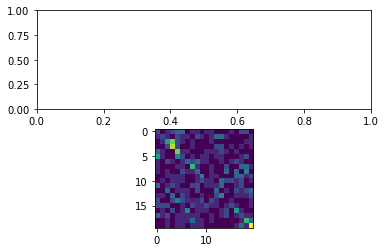

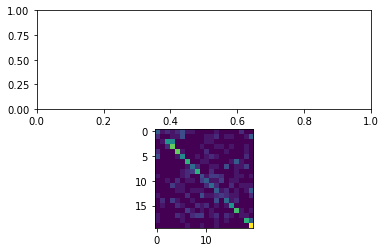

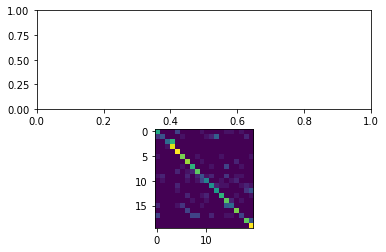

In [63]:
nsims = 20
nunits_list = [10, 25, 54]

accu_bu_t_collapse = np.empty(len(nunits_list))
accu_bu_t_collapse.fill(np.nan)

callhist_bu_t_collapse = np.expand_dims(np.mean(callhist_bu, 2),2)

for i in range(len(nunits_list)):
    accu_bu_t_collapse[i] = sim_decode(callhist_bu_t_collapse,nsims,nunits_list[i],LDA=False)

accu_bu_t_collapse

(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.36764706 0.         0.         0.04411765 0.         0.
 0.01470588 0.01470588 0.39705882 0.        ]
X_leftout: (20, 10)
y_leftout: (20,)
[0.05228758 0.00326797 0.00653595 0.04411765 0.00490196 0.00816993
 0.01143791 0.02124183 0.37418301 0.00326797]
[0.01470588 0.         0.         0.02941176 0.04411765 0.01470588
 0.01470588 0.01470588 0.27941176 0.        ]
[[1.         0.98186625]
 [0.98186625 1.       

[[1.         0.53107671]
 [0.53107671 1.        ]]
[[1.         0.27677351]
 [0.27677351 1.        ]]
[0.         0.         0.04411765 0.04411765 0.         0.
 0.07352941 0.04411765 0.04411765 0.01470588]
[0.00163399 0.00163399 0.02287582 0.         0.         0.00490196
 0.04575163 0.02614379 0.0130719  0.05065359]
(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.         0.01470588 0.         0.08823529
 0.         0.         0.   

[[1.         0.54541263]
 [0.54541263 1.        ]]
[[1.         0.78833624]
 [0.78833624 1.        ]]
[0.01470588 0.         0.         0.07352941 0.04411765 0.04411765
 0.         0.         0.         0.        ]
[0.00816993 0.00326797 0.00653595 0.02124183 0.05718954 0.02777778
 0.00653595 0.02614379 0.02287582 0.00490196]
(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.02941176 0.         0.         0.         0.         0.
 0.         0.         0.   

[[1.         0.98240167]
 [0.98240167 1.        ]]
[[1.         0.38866279]
 [0.38866279 1.        ]]
[0.         0.08823529 0.         0.01470588 0.         0.
 0.04411765 0.02941176 0.         0.08823529]
[0.00816993 0.04738562 0.00490196 0.00653595 0.00326797 0.00490196
 0.02777778 0.01960784 0.         0.05882353]
(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.01470588 0.         0.01470588 0.
 0.         0.         0.39705882 0.

[[1.         0.69945607]
 [0.69945607 1.        ]]
[[1.         0.63035414]
 [0.63035414 1.        ]]
[0.         0.02941176 0.05882353 0.02941176 0.         0.01470588
 0.01470588 0.01470588 0.         0.04411765]
[0.00163399 0.01470588 0.04575163 0.02777778 0.00653595 0.02614379
 0.00816993 0.02777778 0.         0.00980392]
(20, 9, 10)
X: (180, 10)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.02941176 0.23529412 0.         0.         0.08823529 0.
 0.01470588 0.01470588 0.   

[[ 0.91988019  0.91580102  0.51928727  0.51332022  0.94917693  0.91009519
   0.95253624  0.94278685  0.89668966  0.93296537  0.78935541  0.86981941
   0.93377428  0.92972308  0.83338499  0.60535053  0.92229177  0.92832784
   0.83774667  0.90960708]
 [ 0.99475129  0.99413665  0.50446536  0.46522796  0.97121348  0.98950929
   0.90656521  0.95050344  0.98674706  0.92178934  0.8111408   0.75106302
   0.8764217   0.86690569  0.8809564   0.50860196  0.7965849   0.93130491
   0.80460831  0.85461369]
 [ 0.08050146  0.07341002  0.60508638  0.65695069  0.23958755  0.19409309
  -0.03652579  0.11955725  0.16753176  0.12515589  0.27649464  0.24050741
   0.11505684  0.2881987   0.29722785  0.06313054  0.10189206  0.3471377
   0.53152581  0.37565025]
 [ 0.19834924  0.18599522  0.78728948  0.82713786  0.3531062   0.21994844
   0.36223725  0.25836355  0.25859061  0.52211991  0.28785306  0.61576594
   0.45158047  0.5365877   0.34444632  0.32744611  0.59013057  0.42574278
   0.56473526  0.66189358]
 [-0.

 0.         0.01470588 0.07352941 0.07352941]
[[1.         0.43017786]
 [0.43017786 1.        ]]
[[0.43017786 0.51596066 0.17417667 0.35801234 0.337224   0.415203
  0.22304861 0.27149151 0.32587559 0.27160444 0.22433652 0.36270096
  0.42149548 0.03364497 0.32741588 0.15801814 0.25409694 0.14966163
  0.41428496 0.06095342]
 [0.7344813  0.70842444 0.3356805  0.81048488 0.66007329 0.75324358
  0.56064863 0.48760675 0.71486407 0.58612798 0.58266121 0.67841309
  0.67655385 0.53155587 0.59943433 0.42374002 0.55852898 0.39127285
  0.65829125 0.15897872]
 [0.70363446 0.59525901 0.8386767  0.72462772 0.75840483 0.62074711
  0.87709382 0.81846696 0.70511624 0.75673928 0.67683694 0.83027519
  0.72404701 0.60752803 0.71931037 0.79900887 0.88973375 0.73654084
  0.80738434 0.76550803]
 [0.7401972  0.6570092  0.91236554 0.77557796 0.96613852 0.79414112
  0.90069516 0.98128848 0.8375411  0.59816644 0.81677585 0.91717421
  0.942624   0.75554325 0.92910646 0.93014681 0.9572821  0.94474091
  0.95111935 0

(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.39705882 0.         0.         0.02941176 0.02941176 0.
 0.         0.01470588 0.         0.01470588 0.         0.
 0.         0.         0.         0.01470588 0.         0.02941176
 0.         0.         0.04411765 0.         0.         0.02941176
 0.08823529]
X_leftout: (20, 25)
y_leftout: (20,)
[0.36601307 0.00980392 0.00326797 0.02287582 0.02614379 0.00326797
 0.02124183 0.03104575 0.00163399 0.02287582 0

[[1.         0.94425464]
 [0.94425464 1.        ]]
[[1.         0.98579137]
 [0.98579137 1.        ]]
[0.01470588 0.04411765 0.         0.         0.         0.02941176
 0.         0.02941176 0.41176471 0.01470588 0.         0.
 0.         0.         0.         0.02941176 0.02941176 0.
 0.04411765 0.         0.         0.         0.         0.04411765
 0.        ]
[0.00653595 0.02124183 0.05718954 0.00326797 0.09150327 0.01797386
 0.00653595 0.03594771 0.35947712 0.         0.         0.00326797
 0.00163399 0.00653595 0.0130719  0.0245098  0.05065359 0.00490196
 0.         0.00326797 0.00326797 0.         0.00163399 0.04738562
 0.00653595]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11

[[ 0.36381982 -0.09034569 -0.1210576  -0.12640297 -0.04000394  0.21712257
   0.05700469  0.3077482   0.02778554  0.02798951 -0.09211706 -0.11172344
  -0.10660236 -0.05023359 -0.02141554 -0.08432141  0.09793971  0.28752148
  -0.11882548 -0.22999231]
 [ 0.59159207  0.23796643 -0.12068047 -0.12302182 -0.17790273  0.12204722
   0.05933056 -0.03739462 -0.02902427  0.05595048  0.09090229 -0.17633531
  -0.13833559  0.02369772 -0.11242227 -0.0766443   0.06499992 -0.00221125
  -0.11675539 -0.1069396 ]
 [ 0.26359539  0.49343616  0.39866021  0.51681109  0.574682    0.22871553
   0.24677647  0.31101059  0.66625605  0.56196807  0.10314133  0.35034177
   0.23810614  0.42856302  0.17117466  0.13478461  0.20801924  0.61645968
   0.53249913  0.45600997]
 [ 0.27912336  0.48346343  0.71417351  0.69094057  0.579493    0.44056533
   0.47190075  0.52440182  0.75887733  0.47782092  0.48917302  0.62076443
   0.51020821  0.51780711  0.43883345  0.42144061  0.51458382  0.4429003
   0.4578522   0.49584691]
 [ 0.

[[1.         0.17919134]
 [0.17919134 1.        ]]
[[ 1.         -0.03200955]
 [-0.03200955  1.        ]]
[0.07352941 0.01470588 0.         0.04411765 0.         0.
 0.         0.         0.         0.01470588 0.         0.
 0.02941176 0.         0.         0.         0.01470588 0.
 0.         0.         0.04411765 0.         0.         0.
 0.        ]
[0.0130719  0.         0.03267974 0.0130719  0.00163399 0.04084967
 0.00163399 0.05392157 0.01633987 0.01143791 0.         0.
 0.04411765 0.00490196 0.00653595 0.0130719  0.0245098  0.00163399
 0.00326797 0.00326797 0.02777778 0.01633987 0.00980392 0.00490196
 0.0130719 ]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 1

[[1.         0.79471512]
 [0.79471512 1.        ]]
[[1.         0.98028896]
 [0.98028896 1.        ]]
[0.01470588 0.02941176 0.         0.         0.11764706 0.
 0.         0.         0.         0.01470588 0.07352941 0.04411765
 0.05882353 0.         0.         0.04411765 0.         0.
 0.         0.19117647 0.         0.27941176 0.         0.04411765
 0.        ]
[0.02777778 0.07189542 0.         0.00490196 0.04411765 0.00653595
 0.00326797 0.00163399 0.00653595 0.03104575 0.06045752 0.04738562
 0.11928105 0.03921569 0.00326797 0.         0.0130719  0.01797386
 0.00163399 0.02941176 0.0130719  0.37418301 0.00490196 0.00816993
 0.        ]
(20, 9, 25)
X: (180, 25)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11

[[ 0.45686573  0.39089851  0.12255446  0.21388645  0.32419969  0.45750715
   0.36280789  0.07894189  0.07696756  0.45917137  0.73588163  0.71622277
   0.36146982  0.2690719   0.14975246  0.13317932  0.22261101  0.43009096
   0.01798764  0.11780163]
 [ 0.39886267  0.38926632  0.24771202  0.21411888  0.2941683   0.59462016
   0.49277205  0.17100215  0.17831812  0.48103549  0.65225018  0.73154616
   0.42631058  0.17775621  0.1579915   0.26184164  0.17936502  0.25357563
   0.13669135  0.08748259]
 [-0.04205084 -0.05630066  0.73146244  0.76674894  0.3547373   0.4218351
   0.03940262  0.06153727 -0.05152596  0.22469009  0.20220311  0.2371307
   0.22055629  0.28403634  0.3353548   0.32334761  0.15710032  0.16316711
   0.39370947  0.78742557]
 [ 0.09199573 -0.0051695   0.64611889  0.75954798  0.39170324  0.44098428
   0.14461569  0.08957293  0.08262039  0.29473091  0.26827826  0.32221067
   0.2971543   0.33986318  0.42457161  0.41997458  0.28146822  0.08929246
   0.39353041  0.7037813 ]
 [ 0.3

Accu: 0.3275
(20, 9, 54)
X: (180, 54)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.         0.         0.07352941 0.04411765
 0.         0.         0.02941176 0.04411765 0.02941176 0.
 0.         0.         0.         0.         0.         0.01470588
 0.         0.01470588 0.         0.         0.01470588 0.02941176
 0.         0.         0.         0.10294118 0.         0.01470588
 0.02941176 0.         0.         0.         0.04411765 0.
 0.         0.  

[[ 3.39628679e-01  4.96684080e-02  2.27865502e-01  1.43671510e-01
   9.19222740e-02  2.14450931e-01  2.54292309e-01  1.69378295e-01
   9.98283180e-02  5.45888435e-02  3.27085688e-02  6.47254643e-02
  -4.61196878e-02 -2.48403813e-02  2.18271040e-02 -3.12869027e-02
   8.04213209e-02  4.22768214e-01 -2.98307943e-02 -3.29918162e-02]
 [ 4.85195159e-01  3.49479246e-01  2.84755541e-01  2.83729849e-01
   2.16389243e-01  2.50648686e-01  2.30920487e-01  1.26541907e-01
   2.45468070e-01  2.44553158e-01  1.74877042e-02  1.19038317e-01
   5.05156737e-02  5.86550175e-02  2.31614688e-02  6.59705933e-04
   9.26228747e-02  3.20246878e-01  1.99310683e-01  1.20417917e-01]
 [ 3.79942113e-01  3.20414971e-01  6.97680385e-01  6.33129322e-01
   3.79685236e-01  3.85682077e-01  5.60963251e-01  3.61217202e-01
   3.98916781e-01  4.00297169e-01  3.72697788e-01  3.08872584e-01
   2.29218774e-01  1.95915935e-01  3.84504034e-01  2.76639783e-01
   4.01094171e-01  3.83839792e-01  2.86867992e-01  4.16425016e-01]
 [ 2.53

[[1.         0.51954317]
 [0.51954317 1.        ]]
[[1.         0.36108486]
 [0.36108486 1.        ]]
[0.         0.         0.         0.01470588 0.         0.
 0.01470588 0.05882353 0.02941176 0.         0.         0.
 0.         0.         0.04411765 0.02941176 0.         0.01470588
 0.         0.         0.         0.02941176 0.         0.04411765
 0.02941176 0.01470588 0.04411765 0.         0.11764706 0.13235294
 0.         0.         0.05882353 0.04411765 0.         0.01470588
 0.05882353 0.         0.08823529 0.         0.         0.
 0.         0.01470588 0.         0.         0.04411765 0.
 0.26470588 0.         0.01470588 0.         0.         0.04411765]
[0.00163399 0.         0.00653595 0.06045752 0.00980392 0.01143791
 0.01470588 0.01797386 0.03594771 0.00653595 0.00490196 0.00490196
 0.02124183 0.         0.0245098  0.00980392 0.01633987 0.00326797
 0.         0.04738562 0.00163399 0.01960784 0.00980392 0.04738562
 0.02287582 0.05228758 0.02777778 0.04084967 0.0620915  0.

[[1.         0.45213251]
 [0.45213251 1.        ]]
[[1.         0.30979466]
 [0.30979466 1.        ]]
[0.         0.         0.04411765 0.         0.         0.02941176
 0.01470588 0.01470588 0.         0.         0.01470588 0.02941176
 0.01470588 0.02941176 0.         0.         0.         0.
 0.36764706 0.02941176 0.         0.01470588 0.         0.
 0.01470588 0.         0.01470588 0.19117647 0.04411765 0.
 0.08823529 0.         0.01470588 0.         0.         0.
 0.         0.         0.04411765 0.         0.02941176 0.01470588
 0.07352941 0.         0.         0.         0.         0.
 0.         0.23529412 0.         0.         0.         0.        ]
[0.00163399 0.         0.03594771 0.00163399 0.00490196 0.05882353
 0.07026144 0.00163399 0.00653595 0.04901961 0.02124183 0.00980392
 0.03104575 0.02124183 0.02287582 0.         0.00653595 0.00490196
 0.0130719  0.05065359 0.00326797 0.         0.00326797 0.00163399
 0.         0.00816993 0.00816993 0.11601307 0.02614379 0.00326797

[[0.91302451 0.91435936 0.29757907 0.26232404 0.67436254 0.85844745
  0.53958845 0.54644461 0.65479419 0.62292417 0.50247177 0.40442258
  0.50503991 0.53262427 0.46938264 0.3893403  0.47413067 0.74271208
  0.61250755 0.55720986]
 [0.86869438 0.89368687 0.39167295 0.28279114 0.66326417 0.86894308
  0.5796293  0.62698596 0.58525742 0.565685   0.45869939 0.39182199
  0.4793889  0.47167759 0.47031368 0.40093171 0.50482397 0.64746652
  0.62777529 0.57695147]
 [0.43551664 0.43711435 0.64479884 0.75416057 0.62436299 0.47594866
  0.50205859 0.50180947 0.47181237 0.40696647 0.43880857 0.3414114
  0.42604962 0.49611358 0.42326185 0.46766693 0.42665378 0.40589967
  0.55680896 0.55411417]
 [0.35914915 0.31125975 0.75520775 0.79511129 0.57485599 0.3119717
  0.69467386 0.63098085 0.4686968  0.51600779 0.60607295 0.56801541
  0.62936493 0.59543772 0.64433223 0.64823539 0.66118026 0.44446574
  0.59555069 0.71874954]
 [0.77726651 0.80599058 0.26582377 0.22130219 0.68477371 0.84155263
  0.51876197 0.521

(20, 9, 54)
X: (180, 54)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.01470588 0.02941176 0.         0.
 0.02941176 0.         0.01470588 0.         0.02941176 0.04411765
 0.         0.39705882 0.         0.         0.14705882 0.
 0.02941176 0.         0.         0.02941176 0.13235294 0.
 0.02941176 0.         0.08823529 0.         0.         0.
 0.13235294 0.         0.04411765 0.01470588 0.01470588 0.
 0.01470588 0.02941176 0.         0.         0.      

[[0.72288329 0.48982458 0.30062676 0.35055458 0.60913225 0.70750587
  0.42993952 0.38669913 0.63243073 0.56138809 0.44131289 0.36368641
  0.44463073 0.43734619 0.31550787 0.23794877 0.40312287 0.58781127
  0.52514331 0.47480143]
 [0.40199906 0.80756514 0.21142089 0.18697922 0.31495687 0.34957999
  0.26328417 0.31509719 0.38468345 0.35244705 0.16606933 0.22945538
  0.17105546 0.22895205 0.26357743 0.16203329 0.26703265 0.47303119
  0.43464394 0.21236816]
 [0.21537953 0.08040102 0.7768859  0.6746794  0.3820941  0.18944135
  0.57702175 0.44593713 0.42762751 0.53470769 0.64203297 0.53108491
  0.61843579 0.51482907 0.55988624 0.59238216 0.65762365 0.39088292
  0.41263062 0.53369739]
 [0.38113333 0.18413521 0.61334663 0.69651708 0.42963539 0.34933271
  0.5731379  0.44310434 0.56879898 0.49967984 0.66971361 0.55498898
  0.62209634 0.54095873 0.50010567 0.48744761 0.57353553 0.46098905
  0.57562402 0.60384028]
 [0.53537117 0.30933419 0.68567327 0.66625699 0.65058284 0.49147684
  0.64953523 0.5

(20, 9, 110)
X: (180, 110)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.05882353 0.         0.         0.01470588 0.         0.13235294
 0.10294118 0.         0.         0.         0.         0.
 0.39705882 0.         0.01470588 0.36764706 0.         0.04411765
 0.         0.01470588 0.04411765 0.         0.01470588 0.
 0.         0.01470588 0.         0.         0.14705882 0.
 0.         0.02941176 0.01470588 0.02941176 0.         0.02941176
 0.         0.         0.         0

[[1.         0.85549724]
 [0.85549724 1.        ]]
[[1.         0.90986506]
 [0.90986506 1.        ]]
[0.         0.         0.05882353 0.         0.01470588 0.
 0.         0.01470588 0.05882353 0.         0.01470588 0.
 0.08823529 0.         0.08823529 0.         0.01470588 0.
 0.         0.         0.         0.01470588 0.         0.05882353
 0.01470588 0.04411765 0.         0.01470588 0.13235294 0.
 0.         0.20588235 0.44117647 0.         0.         0.02941176
 0.         0.         0.         0.07352941 0.         0.
 0.02941176 0.01470588 0.         0.02941176 0.02941176 0.
 0.04411765 0.         0.04411765 0.         0.01470588 0.04411765
 0.02941176 0.01470588 0.         0.01470588 0.         0.
 0.         0.         0.         0.         0.         0.01470588
 0.         0.         0.         0.         0.         0.01470588
 0.         0.         0.         0.         0.04411765 0.01470588
 0.01470588 0.01470588 0.02941176 0.01470588 0.         0.01470588
 0.         0.01

[[1.         0.65423488]
 [0.65423488 1.        ]]
[[1.         0.87116945]
 [0.87116945 1.        ]]
[0.         0.05882353 0.         0.01470588 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02941176 0.07352941 0.01470588
 0.         0.02941176 0.05882353 0.         0.11764706 0.01470588
 0.10294118 0.         0.         0.14705882 0.         0.04411765
 0.         0.         0.         0.07352941 0.04411765 0.
 0.01470588 0.         0.01470588 0.04411765 0.         0.04411765
 0.02941176 0.         0.         0.05882353 0.01470588 0.
 0.01470588 0.41176471 0.04411765 0.01470588 0.04411765 0.
 0.         0.02941176 0.01470588 0.         0.         0.
 0.         0.         0.         0.01470588 0.         0.
 0.         0.05882353 0.         0.         0.01470588 0.07352941
 0.01470588 0.01470588 0.         0.04411765 0.         0.01470588
 0.14705882 0.07352941 0.01470588 0.01470588 0.         0.01470588
 0.         0.36

[[0.80154278 0.54522138 0.10765578 0.10460043 0.35237862 0.69745305
  0.34041149 0.34038568 0.3685089  0.29532694 0.24116668 0.29777593
  0.14736505 0.1468378  0.24561174 0.12872715 0.24568804 0.44676717
  0.36185796 0.27144443]
 [0.67148332 0.84605537 0.11521062 0.09195514 0.32413607 0.64619352
  0.27038703 0.34898743 0.3377897  0.25138958 0.15686269 0.24162995
  0.09806068 0.07863413 0.22044787 0.08460993 0.20638092 0.46877269
  0.44482077 0.2742558 ]
 [0.30875158 0.20343281 0.47964425 0.48496029 0.51170241 0.26117717
  0.40683331 0.3912571  0.37428864 0.44313438 0.31136726 0.40315551
  0.31688011 0.2937948  0.3226413  0.28871493 0.3083464  0.5090755
  0.46137512 0.34401439]
 [0.3399003  0.2126629  0.39165944 0.48820787 0.36338636 0.30476219
  0.40905002 0.34407285 0.29869542 0.28889781 0.26313715 0.33336443
  0.17253749 0.17338663 0.27690933 0.1863403  0.29020322 0.40699207
  0.43123238 0.43345814]
 [0.38953889 0.3116464  0.39947137 0.47619624 0.63987863 0.4705796
  0.48774828 0.559

[[0.75867754 0.5774233  0.23741783 0.23756845 0.39053149 0.67395804
  0.40726495 0.37958843 0.46134388 0.32089722 0.23448024 0.2996626
  0.13536353 0.1551609  0.24846221 0.11765543 0.28204287 0.54380902
  0.38647854 0.31045833]
 [0.51433208 0.7527675  0.16656941 0.15773264 0.21279284 0.42254734
  0.36675293 0.29629235 0.39782969 0.30945228 0.24794084 0.25143688
  0.10882058 0.13367389 0.22974444 0.11836703 0.2702299  0.46294385
  0.37350482 0.23721252]
 [0.26688243 0.10849887 0.4891288  0.53905067 0.322972   0.22555919
  0.50560324 0.34901183 0.38713809 0.25911028 0.36670126 0.41776785
  0.15880037 0.18606965 0.2959916  0.19911638 0.39263781 0.36430822
  0.3635897  0.3723227 ]
 [0.26572416 0.15246895 0.39273456 0.48804514 0.30277147 0.22999658
  0.36683492 0.23857784 0.35979601 0.2339606  0.25996905 0.32735099
  0.10745707 0.10120725 0.13655261 0.06888984 0.2618765  0.28411506
  0.32519506 0.32875698]
 [0.35369613 0.32066134 0.53752962 0.56839589 0.72218795 0.50747427
  0.51187439 0.61

[0.         0.02614379 0.00163399 0.         0.0130719  0.00490196
 0.00163399 0.07843137 0.00980392 0.00980392 0.0245098  0.00980392
 0.         0.02287582 0.05882353 0.00653595 0.02287582 0.00326797
 0.02287582 0.04738562 0.02124183 0.0130719  0.00816993 0.00980392
 0.00980392 0.00490196 0.00653595 0.00326797 0.00653595 0.00490196
 0.00980392 0.00980392 0.00163399 0.00326797 0.04084967 0.00326797
 0.0130719  0.03104575 0.01797386 0.00163399 0.         0.00816993
 0.05065359 0.00326797 0.04411765 0.07843137 0.00980392 0.00653595
 0.00326797 0.02124183 0.00816993 0.02287582 0.0130719  0.07026144
 0.01797386 0.00163399 0.00490196 0.02777778 0.01797386 0.01633987
 0.00653595 0.01797386 0.01633987 0.00326797 0.00326797 0.0130719
 0.01470588 0.01143791 0.         0.00326797 0.         0.03594771
 0.         0.00163399 0.         0.00163399 0.12254902 0.00326797
 0.04575163 0.01797386 0.05392157 0.01143791 0.00326797 0.00326797
 0.3627451  0.02124183 0.00326797 0.00490196 0.05065359 0.
 0.0

[[1.         0.85379582]
 [0.85379582 1.        ]]
[[1.         0.90050243]
 [0.90050243 1.        ]]
[0.01470588 0.05882353 0.08823529 0.         0.         0.07352941
 0.         0.01470588 0.02941176 0.         0.         0.
 0.01470588 0.01470588 0.         0.04411765 0.13235294 0.
 0.05882353 0.         0.02941176 0.         0.         0.
 0.         0.         0.02941176 0.         0.02941176 0.
 0.02941176 0.         0.         0.         0.         0.13235294
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04411765 0.05882353 0.02941176 0.02941176
 0.         0.         0.04411765 0.         0.         0.10294118
 0.20588235 0.01470588 0.         0.04411765 0.01470588 0.
 0.01470588 0.         0.04411765 0.         0.         0.
 0.         0.         0.         0.01470588 0.         0.
 0.         0.38235294 0.         0.01470588 0.         0.
 0.         0.08823529 0.02941176 0.05882353 0.04411765 0.05882353
 0.         0.01470588 0.       

[[1.         0.84881344]
 [0.84881344 1.        ]]
[[1.        0.7608022]
 [0.7608022 1.       ]]
[0.         0.         0.04411765 0.         0.01470588 0.04411765
 0.         0.         0.02941176 0.01470588 0.         0.04411765
 0.01470588 0.         0.         0.08823529 0.         0.
 0.01470588 0.01470588 0.01470588 0.         0.02941176 0.
 0.02941176 0.         0.04411765 0.         0.         0.
 0.         0.13235294 0.11764706 0.14705882 0.         0.
 0.         0.         0.         0.         0.         0.01470588
 0.02941176 0.02941176 0.         0.01470588 0.         0.
 0.         0.02941176 0.         0.         0.         0.05882353
 0.         0.04411765 0.01470588 0.20588235 0.         0.
 0.01470588 0.         0.         0.         0.02941176 0.
 0.01470588 0.01470588 0.         0.         0.         0.
 0.13235294 0.         0.         0.         0.01470588 0.
 0.02941176 0.         0.         0.         0.         0.
 0.         0.04411765 0.41176471 0.01470588

array([0.1325, 0.3275, 0.4225, 0.5325])

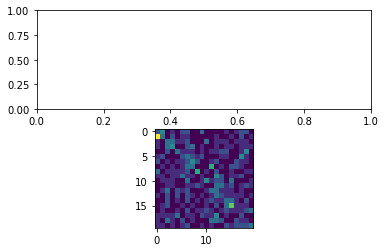

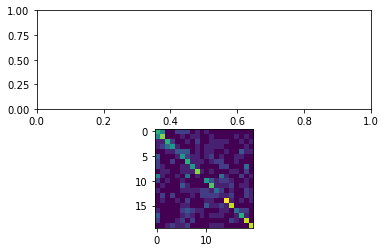

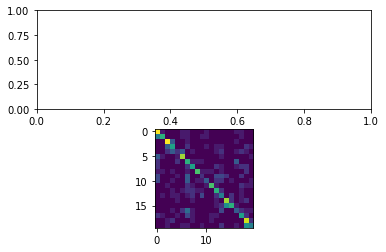

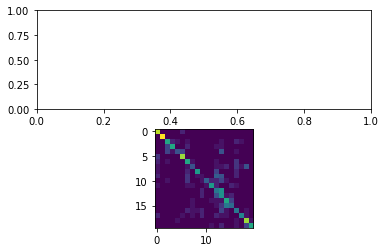

In [67]:
nsims = 20
nunits_list = [10, 25, 54, 110]

accu_RS_t_collapse = np.empty(len(nunits_list))
accu_RS_t_collapse.fill(np.nan)

callhist_RS_t_collapse = np.expand_dims(np.mean(callhist_RS, 2),2)

for i in range(len(nunits_list)):
    accu_RS_t_collapse[i] = sim_decode(callhist_RS_t_collapse,nsims,nunits_list[i],LDA=False)

accu_RS_t_collapse

(20, 9, 68)
X: (180, 68)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.03703704 0.03703704 0.         0.05555556
 0.07407407 0.07407407 0.05555556 0.09259259 0.07407407 0.01851852
 0.03703704 0.07407407 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.         0.01851852 0.         0.01851852 0.
 0.09259259 0.         0.01851852 0.         0.01851852 0.03703704
 0.03703704 0.         0.0185

 0.         0.        ]
[0.00617284 0.01234568 0.01028807 0.01646091 0.02674897 0.01028807
 0.01646091 0.00617284 0.01028807 0.0308642  0.0308642  0.0308642
 0.04938272 0.08641975 0.08230453 0.07407407 0.05349794 0.04938272
 0.01851852 0.02057613 0.01234568 0.01234568 0.01851852 0.01028807
 0.01646091 0.01028807 0.01440329 0.01234568 0.00411523 0.00411523
 0.01234568 0.00617284 0.01028807 0.01028807 0.00823045 0.02469136
 0.01851852 0.01851852 0.01234568 0.01028807 0.01646091 0.01028807
 0.01028807 0.00823045 0.00617284 0.01234568 0.00823045 0.00617284
 0.01851852 0.00205761 0.00411523 0.00617284 0.00411523 0.01234568
 0.00823045 0.00411523 0.00205761 0.00205761 0.00411523 0.00823045
 0.00823045 0.00411523 0.00205761 0.00411523 0.00411523 0.01028807
 0.01028807 0.00411523]
(20, 9, 68)
X: (180, 68)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6 

[[1.         0.54790393]
 [0.54790393 1.        ]]
[[1.         0.43067913]
 [0.43067913 1.        ]]
[0.01851852 0.01851852 0.05555556 0.         0.         0.01851852
 0.         0.         0.01851852 0.01851852 0.01851852 0.03703704
 0.05555556 0.05555556 0.05555556 0.07407407 0.07407407 0.05555556
 0.01851852 0.         0.03703704 0.         0.01851852 0.01851852
 0.05555556 0.01851852 0.01851852 0.         0.         0.
 0.         0.01851852 0.         0.01851852 0.         0.
 0.         0.         0.01851852 0.         0.         0.01851852
 0.         0.03703704 0.         0.         0.01851852 0.01851852
 0.03703704 0.         0.         0.         0.         0.
 0.         0.         0.         0.01851852 0.01851852 0.
 0.         0.03703704 0.01851852 0.         0.         0.07407407
 0.01851852 0.        ]
[0.00617284 0.01028807 0.00617284 0.01646091 0.02674897 0.01028807
 0.01646091 0.00617284 0.00823045 0.0308642  0.03292181 0.0308642
 0.05144033 0.09259259 0.09053498 0.

[[ 6.86291636e-01 -3.95833825e-02 -1.48826754e-02  1.44897264e-01
   1.61034946e-01  2.71345056e-02 -2.23172114e-02  2.10844082e-01
   3.78024310e-02 -1.05474149e-01  2.23899494e-01  1.07993064e-01
   1.52281875e-01  1.17006724e-01  2.34404473e-01  2.86736840e-01
   6.78578696e-02 -2.10424188e-01  4.37816399e-01  1.90257057e-01]
 [-6.92900713e-03  3.84253284e-01 -5.43654046e-02  8.35132625e-02
  -7.72004850e-02  1.54015376e-01  1.45018938e-01 -1.76735880e-02
   1.95960651e-01 -2.09954611e-01  4.21841251e-01  1.21569922e-01
   1.69432008e-01  2.64413044e-01 -1.10399698e-01  7.08505176e-02
   1.59951794e-01  3.98245376e-02  1.23140504e-01 -4.83306150e-02]
 [-1.96468874e-02  1.74896834e-01  6.10662198e-01  3.09243217e-01
   9.59212436e-02  3.90461351e-01  4.60197652e-02  1.58243908e-01
  -2.91971737e-02 -9.13528845e-02  3.60670984e-01  3.90480774e-01
   3.99044986e-01  2.60576217e-01  2.14954873e-01 -1.18409587e-01
   7.72093670e-04  2.09650344e-01  4.28051248e-02  1.71715583e-01]
 [ 6.70

[[1.         0.70281538]
 [0.70281538 1.        ]]
[[1.         0.28880469]
 [0.28880469 1.        ]]
[0.         0.         0.03703704 0.03703704 0.07407407 0.03703704
 0.05555556 0.         0.         0.03703704 0.09259259 0.01851852
 0.03703704 0.16666667 0.11111111 0.11111111 0.05555556 0.01851852
 0.03703704 0.01851852 0.         0.03703704 0.03703704 0.01851852
 0.01851852 0.01851852 0.         0.         0.01851852 0.01851852
 0.01851852 0.         0.         0.01851852 0.05555556 0.07407407
 0.07407407 0.01851852 0.01851852 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01851852 0.03703704
 0.01851852 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01851852 0.
 0.         0.        ]
[0.00823045 0.01234568 0.00823045 0.01234568 0.01851852 0.00823045
 0.01028807 0.00617284 0.01028807 0.02880658 0.02469136 0.03292181
 0.05349794 0.08024691 0.08436214 0

 0.         0.        ]
X_leftout: (20, 68)
y_leftout: (20,)
[0.00617284 0.01234568 0.01234568 0.01234568 0.02674897 0.01234568
 0.01440329 0.00411523 0.01028807 0.0308642  0.03497942 0.03292181
 0.05761317 0.09259259 0.08436214 0.06995885 0.06378601 0.04938272
 0.01851852 0.02263374 0.02057613 0.01234568 0.01851852 0.01028807
 0.01646091 0.01028807 0.01440329 0.01028807 0.00617284 0.00411523
 0.01234568 0.00823045 0.01440329 0.01028807 0.01234568 0.02263374
 0.02263374 0.01646091 0.01646091 0.01028807 0.01440329 0.00823045
 0.01028807 0.00617284 0.00617284 0.01440329 0.00823045 0.00617284
 0.01851852 0.00617284 0.00411523 0.00617284 0.00411523 0.01234568
 0.00823045 0.00411523 0.00205761 0.00205761 0.00205761 0.00617284
 0.00823045 0.00411523 0.00205761 0.00617284 0.00411523 0.01028807
 0.00411523 0.00411523]
[0.01851852 0.         0.         0.03703704 0.         0.
 0.01851852 0.01851852 0.         0.01851852 0.         0.01851852
 0.         0.05555556 0.11111111 0.03703704 0.     

[[ 5.63857995e-01  5.49889285e-02 -4.12375713e-02  5.30975601e-03
   7.76299099e-02  1.14672036e-01 -1.57430914e-02  1.33703134e-01
   3.49028180e-02 -2.15834080e-01  2.02790756e-01  1.88835912e-01
   6.71717573e-02  9.23419926e-02  3.47156434e-01  8.64341877e-02
   2.64751122e-02 -1.97834637e-01  3.55576245e-01  2.25689845e-01]
 [-3.08112857e-02  2.12671135e-01 -7.55346293e-02  3.02878989e-02
   4.72551381e-02 -1.22846857e-02 -7.91963371e-02 -1.71353138e-01
  -1.33259272e-01  9.83164595e-02  1.25299061e-01 -2.08534661e-01
   7.08783509e-02 -8.07727285e-02 -1.01320584e-01 -2.07742436e-01
  -1.45882065e-01 -1.56238295e-01  2.25292022e-01  3.84988202e-02]
 [-5.67527683e-02 -1.97601023e-01  2.59048283e-01 -1.97977480e-02
   2.72114820e-01  1.53179778e-02  8.90558611e-02  1.17689864e-01
   7.68243108e-02 -8.18501934e-02 -1.89543257e-01  6.52793042e-02
  -9.40360163e-02  2.62410143e-01 -1.33111959e-01  2.75292841e-02
   1.93426733e-02  2.01298829e-01 -1.16675941e-01  2.69479915e-02]
 [ 4.17

array([0.81])

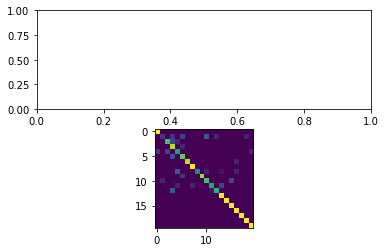

In [69]:
nsims = 20
nunits_list = [1]

accu_bu_unit_collapse = np.empty(len(nunits_list))
accu_bu_unit_collapse.fill(np.nan)

callhist_bu_unit_collapse = np.expand_dims(np.mean(callhist_bu, 3),3)

for i in range(len(nunits_list)):
    accu_bu_unit_collapse[i] = sim_decode(callhist_bu_unit_collapse,nsims,nunits_list[i],LDA=False)

accu_bu_unit_collapse

(20, 9, 68)
X: (180, 68)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.01818182 0.01818182 0.02727273 0.01818182 0.04545455 0.02727273
 0.01818182 0.03636364 0.05454545 0.02727273 0.04545455 0.01818182
 0.02727273 0.01818182 0.02727273 0.05454545 0.01818182 0.03636364
 0.02727273 0.03636364 0.03636364 0.01818182 0.01818182 0.05454545
 0.02727273 0.         0.03636364 0.03636364 0.00909091 0.00909091
 0.02727273 0.00909091 0.01818182 0.00909091 0.01818182 0.02727273
 0.01818182 0

(20, 9, 68)
X: (180, 68)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0.01818182 0.01818182 0.02727273 0.01818182 0.04545455 0.02727273
 0.01818182 0.03636364 0.05454545 0.02727273 0.04545455 0.01818182
 0.02727273 0.01818182 0.02727273 0.05454545 0.01818182 0.03636364
 0.02727273 0.03636364 0.03636364 0.01818182 0.01818182 0.05454545
 0.02727273 0.         0.03636364 0.03636364 0.00909091 0.00909091
 0.02727273 0.00909091 0.01818182 0.00909091 0.01818182 0.02727273
 0.01818182 0

[[ 0.00482635  0.12903159  0.01456541 -0.05994578 -0.08635489  0.01880949
  -0.05538383  0.24219954  0.27168503  0.09432517  0.01705616 -0.02795711
   0.1772593   0.04133351  0.07667427  0.04161106 -0.04914499  0.17095853
  -0.09295602 -0.01933695]
 [-0.04754508  0.04206091  0.11464843  0.10554041  0.15360761 -0.02341072
  -0.12455672 -0.00602994  0.25568266  0.09114661  0.04565898  0.04219335
   0.07528281 -0.06387765 -0.20150185 -0.251572   -0.09681008  0.05386965
   0.11449603 -0.04312839]
 [ 0.16740767  0.06911933  0.14080121  0.09069657  0.11407978  0.25849309
   0.0879796   0.04994808  0.04950863 -0.01080076  0.04817562  0.04327464
   0.16375546  0.1973255   0.2938789   0.24626783 -0.05083395  0.00805777
  -0.01579981  0.32604567]
 [ 0.08529832  0.04815851  0.33979827  0.37121182  0.29707667  0.20386145
  -0.08201655 -0.12324652 -0.16168497 -0.0348723  -0.12217236 -0.1125177
  -0.06227774 -0.11757624  0.05405218 -0.07084062 -0.05508579 -0.01456658
   0.37469341  0.18621344]
 [-0.

[[ 1.         -0.00665927]
 [-0.00665927  1.        ]]
[[ 1.         -0.01356717]
 [-0.01356717  1.        ]]
[0.01818182 0.00909091 0.00909091 0.02727273 0.03636364 0.00909091
 0.00909091 0.01818182 0.02727273 0.01818182 0.         0.00909091
 0.03636364 0.02727273 0.05454545 0.00909091 0.01818182 0.00909091
 0.01818182 0.02727273 0.00909091 0.03636364 0.03636364 0.02727273
 0.03636364 0.02727273 0.00909091 0.01818182 0.         0.01818182
 0.02727273 0.02727273 0.01818182 0.00909091 0.02727273 0.00909091
 0.01818182 0.00909091 0.01818182 0.04545455 0.         0.01818182
 0.01818182 0.01818182 0.02727273 0.02727273 0.01818182 0.00909091
 0.02727273 0.00909091 0.00909091 0.01818182 0.00909091 0.
 0.00909091 0.01818182 0.02727273 0.00909091 0.02727273 0.02727273
 0.01818182 0.02727273 0.         0.00909091 0.         0.
 0.00909091 0.03636364]
[0.01818182 0.01515152 0.01818182 0.01818182 0.02121212 0.01313131
 0.01919192 0.02525253 0.02323232 0.02020202 0.02727273 0.02424242
 0.03636364

[[ 0.00482635  0.12903159  0.01456541 -0.05994578 -0.08635489  0.01880949
  -0.05538383  0.24219954  0.27168503  0.09432517  0.01705616 -0.02795711
   0.1772593   0.04133351  0.07667427  0.04161106 -0.04914499  0.17095853
  -0.09295602 -0.01933695]
 [-0.04754508  0.04206091  0.11464843  0.10554041  0.15360761 -0.02341072
  -0.12455672 -0.00602994  0.25568266  0.09114661  0.04565898  0.04219335
   0.07528281 -0.06387765 -0.20150185 -0.251572   -0.09681008  0.05386965
   0.11449603 -0.04312839]
 [ 0.16740767  0.06911933  0.14080121  0.09069657  0.11407978  0.25849309
   0.0879796   0.04994808  0.04950863 -0.01080076  0.04817562  0.04327464
   0.16375546  0.1973255   0.2938789   0.24626783 -0.05083395  0.00805777
  -0.01579981  0.32604567]
 [ 0.08529832  0.04815851  0.33979827  0.37121182  0.29707667  0.20386145
  -0.08201655 -0.12324652 -0.16168497 -0.0348723  -0.12217236 -0.1125177
  -0.06227774 -0.11757624  0.05405218 -0.07084062 -0.05508579 -0.01456658
   0.37469341  0.18621344]
 [-0.

[[ 0.19385717  0.1630649   0.17482962  0.05881911  0.12189555  0.05223032
   0.22537125 -0.09114638 -0.12440853  0.0173761   0.05280349 -0.03283591
   0.19824058  0.0869719   0.08619816  0.00389971 -0.10474819  0.26559611
   0.10564776  0.12961575]
 [ 0.19083168 -0.02113158 -0.10405733 -0.07529309 -0.20138206 -0.24437626
  -0.00785573  0.31414507  0.1305611  -0.0447535  -0.04028453  0.02888609
  -0.07936595 -0.11852774 -0.13208093 -0.01608951  0.03823253  0.15938508
   0.01205634 -0.23942687]
 [ 0.18406841 -0.04102896  0.19833604  0.27231658  0.23403145  0.06005838
   0.0802273  -0.12321158 -0.1121247  -0.14674669  0.00223894 -0.13775843
  -0.16663717 -0.15359445  0.0865965  -0.05442465 -0.05687179  0.20796977
   0.23885187  0.07429434]
 [ 0.05623114 -0.06423344  0.2261743   0.10286859 -0.00621983  0.06932103
  -0.12319687 -0.16108911  0.04327276  0.21122504 -0.0100497  -0.10868029
  -0.24314329 -0.24042369  0.11462884 -0.13069621 -0.20469093  0.11213675
   0.02273038 -0.00935107]
 [-0

[[ 1.15847965e-01 -2.08506147e-01 -8.16483868e-03  1.88606421e-03
  -1.62539353e-01 -2.57163721e-02 -8.66083041e-03 -1.28582929e-01
   8.73864772e-02  2.23529581e-01  9.37146102e-02  7.40148133e-02
  -3.83788054e-02  4.48361121e-02  1.72329283e-01  1.83415628e-01
   4.10895373e-02  7.09726820e-02 -1.28635581e-01  6.53068684e-02]
 [ 9.20773966e-02  1.92321013e-01 -3.92499638e-02 -7.52093096e-02
   5.38939831e-02  9.07285031e-02 -3.48677935e-02  1.93342031e-02
   9.35476931e-02 -1.15859690e-01 -1.63795959e-01  9.56731284e-02
  -1.26488552e-01  7.46446921e-02  9.42568045e-02  5.43069228e-02
  -8.59483092e-02  2.67052048e-01 -9.52044040e-02 -5.90583620e-02]
 [ 2.74754585e-01  1.63579102e-02  2.41717586e-01  2.56207041e-01
   2.60799676e-01  2.14681811e-01  1.73994646e-01 -1.05353482e-02
   1.23526649e-01  9.11412320e-02  5.79005977e-03  3.28976506e-02
   1.91717339e-01  1.24452967e-01  1.44165217e-01  2.66181575e-02
  -1.78329554e-01  6.49070044e-02  1.01135445e-01  9.87447416e-02]
 [-4.62

array([0.445])

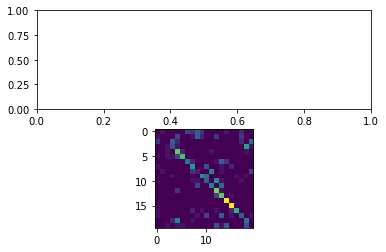

In [70]:
nsims = 20
nunits_list = [1]

accu_RS_unit_collapse = np.empty(len(nunits_list))
accu_RS_unit_collapse.fill(np.nan)

callhist_RS_unit_collapse = np.expand_dims(np.mean(callhist_RS, 3),3)

for i in range(len(nunits_list)):
    accu_RS_unit_collapse[i] = sim_decode(callhist_RS_unit_collapse,nsims,nunits_list[i],LDA=False)

accu_RS_unit_collapse

In [ ]:
path = os.path.join(decode_dir, animalID[i]+'_batch','decode_figdata.mat')
mdic = {"accu50_bu": accu50_bu, "accu50_RS": accu50_RS, "accu_bu": accu_bu, }
io.savemat(path,mdic)